## Problem:
$$\begin{cases}
-\Delta u = 0 &\text{on } \Omega\\
u = r^{2/3} \sin(\frac{2\theta+\pi}{3}) &\text{on } \partial\Omega
\end{cases}$$

where $\Omega$ is the backwards L-shape domain. We have weak form
$$
\mathcal{J}(v) = \int_\Omega \big( \frac{1}{2}|\nabla v|^2\big)\text{d}\boldsymbol{x}
$$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cbook as cbook
import matplotlib.patches as patches
from ipywidgets import IntProgress
from IPython.display import display
import time
import os

--------------------------------------------------------------------------------------------------------------------------------

# Architectures

## Shallow Ritz NN, Tanh Activation

In [2]:
class srnn_Tanh(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.input(x))
        x = self.tanh(self.hidden(x))
        x = self.output(x)
        return x

## Shallow Ritz NN, ReLU Activation

In [3]:
class srnn_ReLU(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

## Deep Ritz Feedforward NN, Tanh Activation

In [4]:
class drfnn_Tanh(nn.Module):
    """
    drfnn2 -- Deep Ritz Feedforward Neural Network

    Implements a feedforward network with 8 hidden layers

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.phi = nn.Tanh()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.phi(self.stack[i](x))
        x = self.output(x)
        return x

## Deep Ritz Feedforward NN, ReLU Activation

In [5]:
class drfnn_ReLU(nn.Module):
    """
    drnn -- Deep Ritz Feedforward Neural Network

    Implements a feedforward network with 8 hidden layers

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.relu(self.stack[i](x))
        x = self.output(x)
        return x

## Deep Ritz Residual NN, Tanh Activation

In [6]:
class Block(nn.Module):
    """
    Implementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [7]:
class drrnn_Tanh(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_Tanh, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

## Deep Ritz Residual NN, ReLU Activation

In [8]:
class BlockReLU(nn.Module):
    """
    Implementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(BlockReLU, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.ReLU()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [9]:
class drrnn_ReLU(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_ReLU, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        #self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(BlockReLU(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

--------------------------------------------------------------------------------------------------------------------------------

# Sampling in $\mathbb{R}^2$

In [10]:
# BACKWARDS L-SHAPE DOMAIN: \Omega = (-1,1)^2 \ [-1,0]x[0,1]
def get_interior_points_l_shape(N=129):
    """
    randomly sample N points from interior of (-1,1)^2 \ [-1,0]x[0,1]
    """
    sq1 = torch.rand(N//3,2)                          # Top Right
    sq2 = torch.rand(N//3,2) - torch.tensor((0,1))    # Bottom Right
    sq3 = torch.rand(N//3,2) - torch.tensor((1,1))    # Bottom Left
    return torch.cat((sq1, sq2, sq3), dim=0)

def get_boundary_points_l_shape(N=32):
    """
    randomly sample N points from boundary of (-1,1)^2 \ [-1,0]x[0,1]
    """
    index = torch.rand(N//2,1)              # Short Edges
    index1 = torch.rand(N,1) * 2 - 1     # Long Edges
    
    xb1 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb2 = torch.cat((index, torch.ones_like(index)), dim=1)
    xb3 = torch.cat((torch.zeros_like(index), index), dim=1)
    xb4 = torch.cat((index - 1, torch.zeros_like(index)), dim=1)
    xb5 = torch.cat((torch.full_like(index, -1), index - 1), dim=1)
    xb6 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5, xb6), dim=0)

    return xb

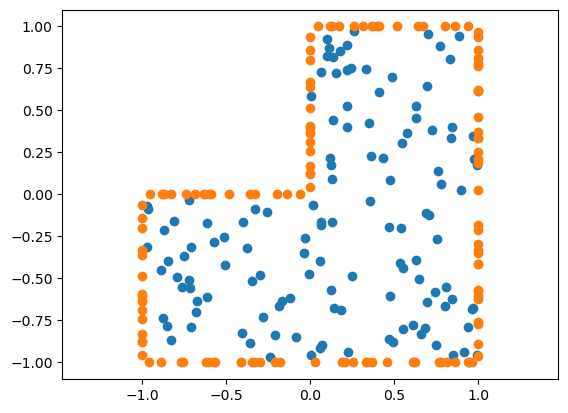

In [11]:
X = get_interior_points_l_shape()
Y = get_boundary_points_l_shape()
plt.scatter(X[:,0],X[:,1])
plt.scatter(Y[:,0],Y[:,1])
plt.axis('equal')
plt.show()

In [16]:
# REGULAR BACKWARDS L-SHAPE DOMAIN: \Omega = (-1,1)^2 \ [-1,0]x[0,1]
def get_interior_points_l_shape_reg(N=19):
    """
    randomly sample N points from interior of (-1,1)^2 \ [-1,0]x[0,1]
    """
    
    x = torch.linspace(1/(N-1), 1-1/(N-1), N-2)
    y = torch.linspace(0, 1-1/(N-1), N-1)
    Y, X = torch.meshgrid(y, x)
    sq1 = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
    Y, X = torch.meshgrid(x, y)
    sq2 = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1) - torch.tensor((0,1))
    Y, X = torch.meshgrid(x, x)
    sq3 = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1) - torch.tensor((1,1))
    
                    
    return torch.cat((sq1, sq2, sq3), dim=0)

def get_boundary_points_l_shape_reg(N=32):
    """
    randomly sample N points from boundary of (-1,1)^2 \ [-1,0]x[0,1]
    """
    index = torch.rand(N//2,1)              # Short Edges
    index1 = torch.rand(N,1) * 2 - 1     # Long Edges
    
    index = torch.linspace(0, 1, 16).reshape((-1,1))
    index1 = torch.linspace(-1,1,31).reshape((-1,1))
    #print(index)
    
    xb1 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb2 = torch.cat((index, torch.ones_like(index)), dim=1)
    xb3 = torch.cat((torch.zeros_like(index), index), dim=1)
    xb4 = torch.cat((index - 1, torch.zeros_like(index)), dim=1)
    xb5 = torch.cat((torch.full_like(index, -1), index - 1), dim=1)
    xb6 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
                    
    # Adapted Sampling: include more points near centre
    xb7 = torch.cat((torch.zeros_like(index1), (index1 + 1)/2), dim=1)
    xb8 = torch.cat(((index1 - 1)/2, torch.zeros_like(index1)), dim=1)
    
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5, xb6), dim=0)

    return xb

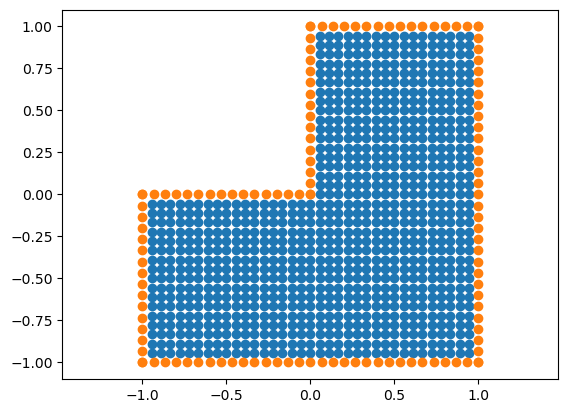

In [17]:
from matplotlib.pyplot import figure
X = get_interior_points_l_shape_reg()
Y = get_boundary_points_l_shape_reg()
plt.scatter(X[:,0],X[:,1])
plt.scatter(Y[:,0],Y[:,1])
plt.axis('equal')
plt.show()

In [21]:
# SWITCHBOARD FOR DOMAINS
def get_points(domain='sq', density=19):
    """
    Switchboard for domains
    """
    if domain == 'l_shape':
        xr = get_interior_points_l_shape()
        xb = get_boundary_points_l_shape()
        
    else:# domain == 'l_shape_reg':
        xr = get_interior_points_l_shape_reg(density)
        xb = get_boundary_points_l_shape_reg()
        
    return xr, xb

--------------------------------------------------------------------------------------------------------------------------------

# Initialisation and Training

In [22]:
def weights_init(m):  # Initialise weights
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)      # Initialisation technique using normal dist. introduced by Xavier Glorot
        nn.init.constant_(m.bias, 0)        # Initialise bias vectors as zero

In [24]:
def main(domain = 'l_shape_reg', density=19, arch = 'drrnn_Tanh', epochs = 5000, m = 10, lr=3e-4, pretrain=0):    
    """
    main -- Training Module

    Trains a chosen model with random sampling in domain and boundary.

    Parameters:
        domain -- domain of the problem
        arch   -- architecture to be used
        m      -- width of layers
    """

    in_N = 2      # Input Dimensions
    out_N = 1     # Output Dimensions

    device = torch.device('cpu')
    
    if arch == 'srnn_ReLU':
        model = srnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'srnn_Tanh':
        model = srnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drfnn_ReLU':
        model = drfnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'drfnn_Tanh':
        model = drfnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drrnn_ReLU':
        model = drrnn_ReLU(in_N, m, out_N).to(device)
    else:
        arch = 'drrnn_Tanh'
        model = drrnn_Tanh(in_N, m, out_N).to(device)
        


    
    # Initialise weights
    if pretrain == 1:
        model.load_state_dict(torch.load('pretrained_models/'+domain+'_'+arch+'.mdl'))
    else:
        model.apply(weights_init)  
        
        # PLOT EXAMPLE DATA
        X, Y = get_points(domain, density)
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(Y[:,0],Y[:,1])
        plt.axis('equal')
        plt.show()
        

    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(arch)  #print(model)                                
    
    save_loss = torch.zeros((epochs//100, 1))                 # saving loss and error values as the model is trained
    save_error = torch.zeros((epochs//100, 1))    
    best_loss, best_error, best_epoch = 100000, 100000, 0     # Tracking best iteration
    
    f = IntProgress(min=0, max=epochs//100) # instantiate the bar
    display(f) # display the bar
    
    for epoch in range(epochs+1):

        xr, xb = get_points(domain, density)                           # Generate data
        xr = xr.to(device)
        xb = xb.to(device)
        
        xr.requires_grad_()
        output_r = model(xr)
        output_b = model(xb)
        # Compute the gradient term \nabla v
        grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Integrand of variational problem (average)
        loss_r = 0.5*torch.sum(torch.pow(grads, 2),dim=1)
        loss_r = torch.mean(loss_r)
        
        true_sol_b = torch.zeros_like(output_b)
        true_sol_b = true_sol_b + torch.pow(torch.sum(torch.pow(xb,2),dim=1),1/3).reshape_as(output_b) \
                        * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3) \
                        * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
        true_sol_b = true_sol_b + torch.pow(torch.sum(torch.pow(xb,2),dim=1),1/3).reshape_as(output_b) \
                        * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
        true_sol_b = true_sol_b + torch.pow(torch.sum(torch.pow(xb,2),dim=1),1/3).reshape_as(output_b) \
                        * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))
        
        
        loss_b = torch.pow(true_sol_b - output_b,2)
        loss_b = torch.mean(loss_b)
        
        loss = 3 * loss_r + 500 * 8 * loss_b   
        # 3 = area of Omega, 8 = length of boundary

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            #'''
            print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (3 * loss_r).item(), 'loss_b:', (500 * 8 * loss_b).item())
            save_loss[epoch//100 - 1] = loss.item()
            
            #'''
            xe = get_interior_points_l_shape(500)   # sample for computing L2 error on interior
            xe = xe.to(device)
            output_e = model(xe)
            switch = -2*(xe[:,1:] == 0) + 1
            true_sol = torch.pow(torch.pow(xe[:,:1],2)+torch.pow(xe[:,1:],2),1/3) \
                            * torch.sin((switch*2*torch.atan2(xe[:,1:],xe[:,:1])+torch.pi)/3)
            
            error = torch.sqrt(3*torch.mean(torch.pow((output_e - true_sol),2)))
            error = error/torch.sqrt(3*torch.mean(torch.pow(true_sol,2)))
            print('Interior L2 error:', error.item())
            save_error[epoch//100 - 1] = error.item()
            
            xeb = get_boundary_points_l_shape_reg()   # sample for computing error on boundary
            xeb = xeb.to(device)
            output_eb = model(xeb)
            switch = -2*(xeb[:,1:] == 0) + 1
            true_sol = torch.pow(torch.pow(xeb[:,:1],2)+torch.pow(xeb[:,1:],2),1/3) \
                            * torch.sin((switch*2*torch.atan2(xeb[:,1:],xeb[:,:1])+torch.pi)/3)
            
            error_b = torch.sqrt(8*torch.mean(torch.pow((output_eb - true_sol),2)))
            print('Boundary L2 error:', error_b.item())
            #'''
            f.value += 1 # signal to increment the progress bar
            time.sleep(.1)
            #'''
            
            # Find minimum absolute loss in final 20% of training process
            if epoch > int(4 * epochs / 5):
                if (loss.item() < best_loss): #(error.item() < best_error):       # Most negative value of loss
                    best_loss = loss.item()
                    best_epoch = epoch
                    best_error = error.item()
                    if pretrain == 2:
                        torch.save(model.state_dict(), 'pretrained_models/'+domain+'_'+arch+'.mdl')   
                    torch.save(model.state_dict(), 'saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl')
    print('best epoch:', best_epoch, 'best loss:', best_loss, 'L2 error:', best_error)

    # plot figure
    model.load_state_dict(torch.load('saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl'))
    print('load from ckpt!')
    
    num_points=1001
    x = torch.linspace(-1, 1, num_points)
    Y, X = torch.meshgrid(x, x)

    # CHOOSE DOMAIN
    # L-shape mask
    mask1 = (X >= 0) #or (Y <= 0)
    mask2 = (Y <= 0)
    mask = torch.max(mask1, mask2)
    extent1=[-1, 1, -1, 1]

    # EVALUATE MODEL IN [-1,1]^2
    Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
    Z = Z.to(device)
    with torch.no_grad():
        pred = model(Z)
    true_sol = torch.pow(torch.pow(X,2)+torch.pow(Y,2),1/3) * torch.sin((2*torch.atan2(Y,X)+torch.pi)/3)

    # CROP/MASK TO DOMAIN USING NaN
    pred_full = np.empty((num_points, num_points))
    pred_full.fill(np.nan)
    np.putmask(pred_full, mask, pred.cpu().numpy())
    error_full = np.empty((num_points, num_points))
    error_full.fill(np.nan)
    np.putmask(error_full, mask, np.abs(pred.cpu().numpy() - torch.flatten(true_sol).numpy().reshape((-1,1))))

    # PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(pred_full, interpolation='nearest', cmap='jet',
               extent = extent1,
               origin='lower', aspect='equal',
               vmin=np.nanmin(pred_full), vmax=np.nanmax(pred_full))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    plt.savefig('network_solutions_relative/'+domain+'_'+arch+str(epochs)+'_pred.png')
    plt.show()
    
    # ERROR PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(error_full, interpolation='nearest', cmap='jet',
               extent = extent1,
               origin='lower', aspect='equal',
               vmin=np.nanmin(error_full), vmax=np.nanmax(error_full))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    plt.savefig('network_errors_relative/'+domain+'_'+arch+str(epochs)+'_error.png')
    plt.show()
    
    # Loss and Error profile
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Iterations (100s)')
    ax1.set_ylabel('Loss', color=color)
    ax1.set_yscale('log')
    ax1.plot(save_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Training Loss and Error Profiles")
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Relative L2 Error From Sample', color=color)  
    ax2.set_yscale('log')
    ax2.plot(save_error, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  
    plt.savefig('convergence_plots_relative/'+domain+'_'+arch+str(epochs)+'_combined.png')
    plt.show()

### SRNN ReLU

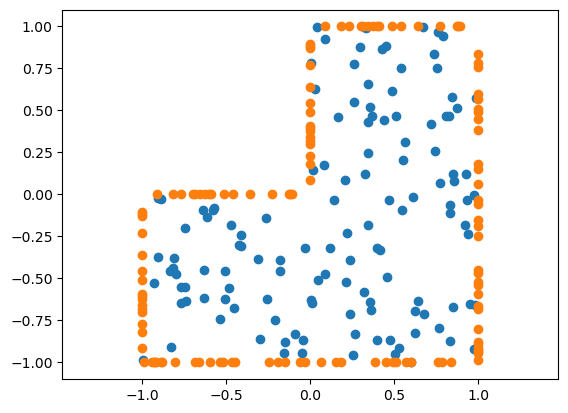

srnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 2292.62109375 loss_r: 0.01748161017894745 loss_b: 2292.603515625
Interior L2 error: 1.0162968635559082
Boundary L2 error: 2.100051164627075


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 114.0180892944336 loss_r: 0.7028369903564453 loss_b: 113.31525421142578
Interior L2 error: 0.1825985163450241
Boundary L2 error: 0.459886372089386
epoch: 200 loss: 28.952608108520508 loss_r: 1.0299676656723022 loss_b: 27.922639846801758
Interior L2 error: 0.10255960375070572
Boundary L2 error: 0.2519488036632538
epoch: 300 loss: 24.45651626586914 loss_r: 1.0578206777572632 loss_b: 23.39869499206543
Interior L2 error: 0.09102816134691238
Boundary L2 error: 0.21038568019866943
epoch: 400 loss: 12.822823524475098 loss_r: 1.1519626379013062 loss_b: 11.67086124420166
Interior L2 error: 0.06475213915109634
Boundary L2 error: 0.164063960313797
epoch: 500 loss: 8.158869743347168 loss_r: 1.0213186740875244 loss_b: 7.1375508308410645
Interior L2 error: 0.05828310549259186
Boundary L2 error: 0.1206098347902298
epoch: 600 loss: 5.293665409088135 loss_r: 0.9036836624145508 loss_b: 4.389981746673584
Interior L2 error: 0.053157370537519455
Boundary L2 error: 0.0899021103978157
epoch:

epoch: 5000 loss: 1.1397364139556885 loss_r: 0.9292075634002686 loss_b: 0.21052880585193634
Interior L2 error: 0.08651748299598694
Boundary L2 error: 0.020067766308784485
best epoch: 4600 best loss: 0.9441821575164795 L2 error: 0.08918001502752304
load from ckpt!


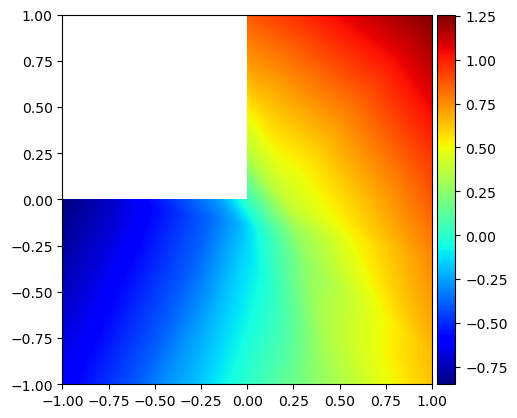

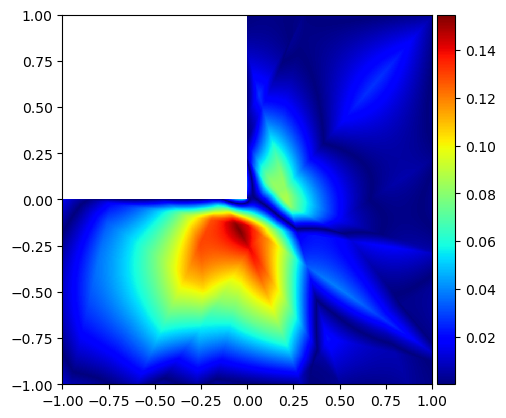

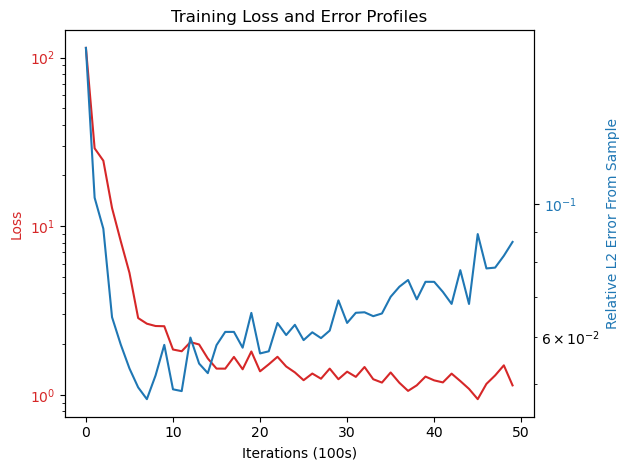

In [25]:
main(arch='srnn_ReLU', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

srnn_ReLU


IntProgress(value=0, max=150)

epoch: 0 loss: 1.449019193649292 loss_r: 1.0870531797409058 loss_b: 0.36196595430374146
Interior L2 error: 0.08876933157444
Boundary L2 error: 0.04249885678291321


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.1223182678222656 loss_r: 1.0143681764602661 loss_b: 0.10795006155967712
Interior L2 error: 0.07355823367834091
Boundary L2 error: 0.020055003464221954
epoch: 200 loss: 1.1547284126281738 loss_r: 1.0182068347930908 loss_b: 0.13652153313159943
Interior L2 error: 0.08502614498138428
Boundary L2 error: 0.019436411559581757
epoch: 300 loss: 1.2533581256866455 loss_r: 1.1393322944641113 loss_b: 0.11402588337659836
Interior L2 error: 0.07764242589473724
Boundary L2 error: 0.019850458949804306
epoch: 400 loss: 1.2091600894927979 loss_r: 0.9353049993515015 loss_b: 0.27385514974594116
Interior L2 error: 0.08954600989818573
Boundary L2 error: 0.019417645409703255
epoch: 500 loss: 1.14595365524292 loss_r: 1.0151537656784058 loss_b: 0.13079993426799774
Interior L2 error: 0.0882934108376503
Boundary L2 error: 0.020022930577397346
epoch: 600 loss: 1.57723867893219 loss_r: 1.1812280416488647 loss_b: 0.3960106670856476
Interior L2 error: 0.09031868726015091
Boundary L2 error: 0.02018

epoch: 5000 loss: 1.3988255262374878 loss_r: 1.192864179611206 loss_b: 0.20596133172512054
Interior L2 error: 0.1167507916688919
Boundary L2 error: 0.021830325946211815
epoch: 5100 loss: 1.4359021186828613 loss_r: 1.2853155136108398 loss_b: 0.1505865454673767
Interior L2 error: 0.11778297275304794
Boundary L2 error: 0.019257493317127228
epoch: 5200 loss: 1.1203340291976929 loss_r: 0.9655344486236572 loss_b: 0.15479955077171326
Interior L2 error: 0.1276012659072876
Boundary L2 error: 0.019829820841550827
epoch: 5300 loss: 1.460858702659607 loss_r: 1.2101609706878662 loss_b: 0.2506977617740631
Interior L2 error: 0.11979617923498154
Boundary L2 error: 0.02089499495923519
epoch: 5400 loss: 1.4344351291656494 loss_r: 1.2664581537246704 loss_b: 0.16797693073749542
Interior L2 error: 0.11328208446502686
Boundary L2 error: 0.01953854411840439
epoch: 5500 loss: 1.4347339868545532 loss_r: 1.1725904941558838 loss_b: 0.2621435225009918
Interior L2 error: 0.11723259836435318
Boundary L2 error: 0.01

epoch: 9900 loss: 1.5119491815567017 loss_r: 1.3365304470062256 loss_b: 0.17541874945163727
Interior L2 error: 0.11230992525815964
Boundary L2 error: 0.018645910546183586
epoch: 10000 loss: 1.4291554689407349 loss_r: 1.2918291091918945 loss_b: 0.13732634484767914
Interior L2 error: 0.12149922549724579
Boundary L2 error: 0.01898115500807762
epoch: 10100 loss: 1.4298510551452637 loss_r: 1.2032086849212646 loss_b: 0.2266424298286438
Interior L2 error: 0.11758127808570862
Boundary L2 error: 0.01952366530895233
epoch: 10200 loss: 1.3502994775772095 loss_r: 1.0690885782241821 loss_b: 0.28121089935302734
Interior L2 error: 0.11751369386911392
Boundary L2 error: 0.019178319722414017
epoch: 10300 loss: 1.0558866262435913 loss_r: 0.8986775279045105 loss_b: 0.1572091281414032
Interior L2 error: 0.1129341870546341
Boundary L2 error: 0.02189100719988346
epoch: 10400 loss: 1.5612609386444092 loss_r: 1.3978283405303955 loss_b: 0.16343265771865845
Interior L2 error: 0.11663573980331421
Boundary L2 err

epoch: 14800 loss: 1.0438880920410156 loss_r: 0.8794761300086975 loss_b: 0.16441190242767334
Interior L2 error: 0.1073475033044815
Boundary L2 error: 0.019754476845264435
epoch: 14900 loss: 1.4371212720870972 loss_r: 1.1440019607543945 loss_b: 0.293119341135025
Interior L2 error: 0.10724671930074692
Boundary L2 error: 0.018735377117991447
epoch: 15000 loss: 1.209060788154602 loss_r: 0.9466959238052368 loss_b: 0.26236483454704285
Interior L2 error: 0.10298431664705276
Boundary L2 error: 0.019232118502259254
best epoch: 14800 best loss: 1.0438880920410156 L2 error: 0.1073475033044815
load from ckpt!


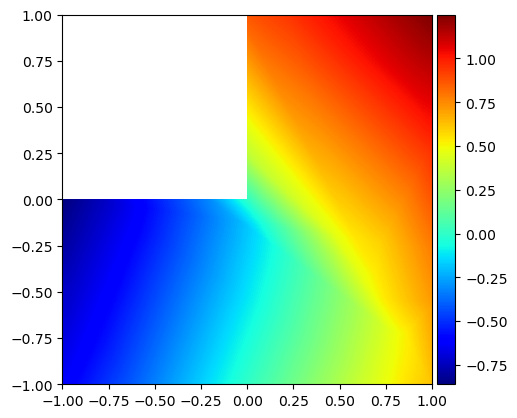

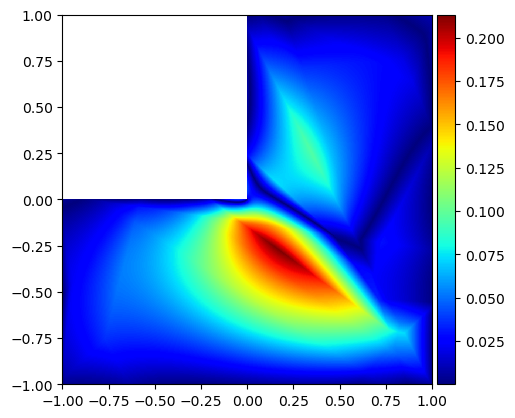

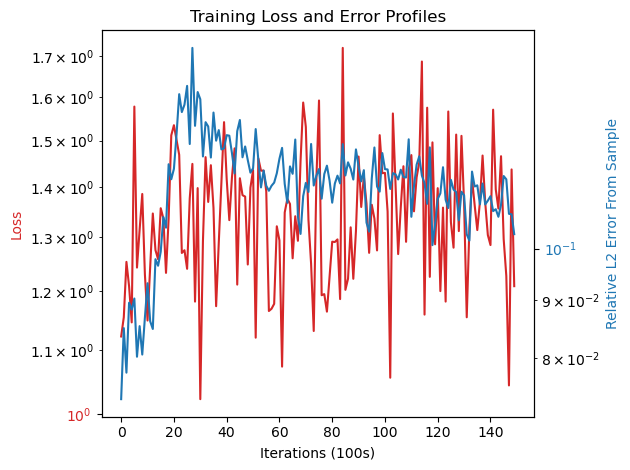

In [26]:
main(arch='srnn_ReLU', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

### SRNN Tanh

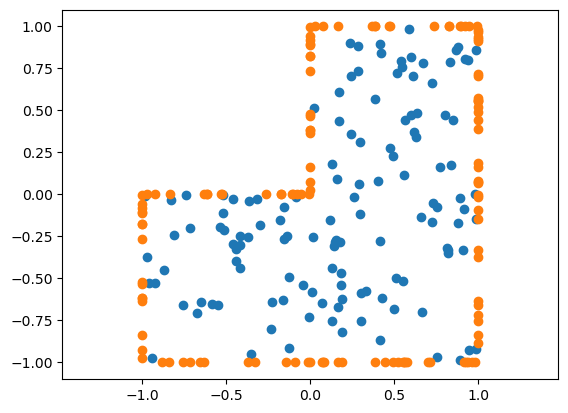

srnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 538.528564453125 loss_r: 1.16010320186615 loss_b: 537.3684692382812
Interior L2 error: 0.4861013889312744
Boundary L2 error: 0.9884177446365356


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 109.250244140625 loss_r: 0.957750141620636 loss_b: 108.29249572753906
Interior L2 error: 0.19374379515647888
Boundary L2 error: 0.4768705368041992
epoch: 200 loss: 98.33589172363281 loss_r: 0.9956036806106567 loss_b: 97.34028625488281
Interior L2 error: 0.18683017790317535
Boundary L2 error: 0.4477885365486145
epoch: 300 loss: 68.7782211303711 loss_r: 0.963733971118927 loss_b: 67.81448364257812
Interior L2 error: 0.16687358915805817
Boundary L2 error: 0.3810116648674011
epoch: 400 loss: 44.326011657714844 loss_r: 1.0173847675323486 loss_b: 43.30862808227539
Interior L2 error: 0.1341504156589508
Boundary L2 error: 0.26930034160614014
epoch: 500 loss: 14.931923866271973 loss_r: 1.1537541151046753 loss_b: 13.778169631958008
Interior L2 error: 0.10775595158338547
Boundary L2 error: 0.1819574534893036
epoch: 600 loss: 9.972739219665527 loss_r: 1.0233404636383057 loss_b: 8.9493989944458
Interior L2 error: 0.09912838786840439
Boundary L2 error: 0.1423923671245575
epoch: 700 l

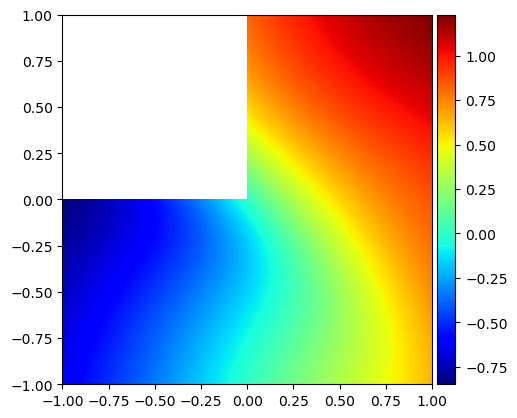

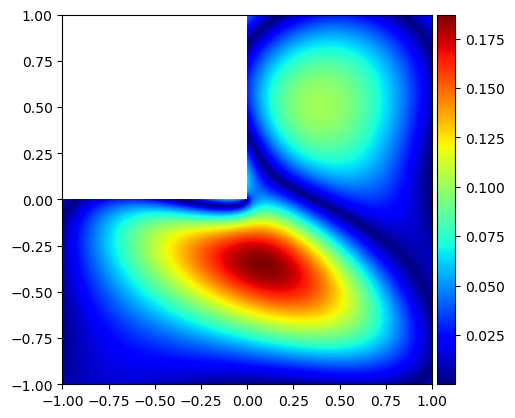

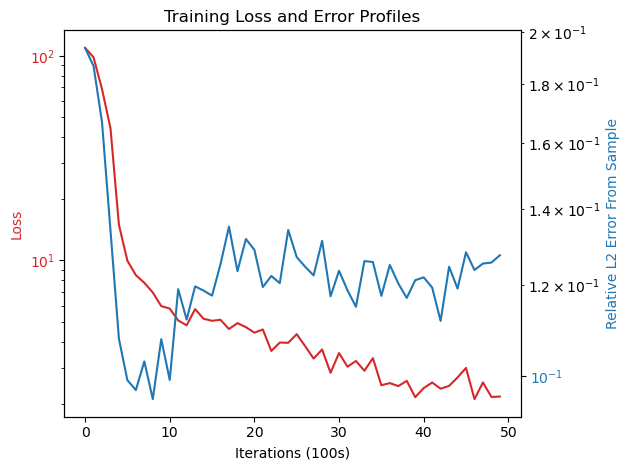

In [27]:
main(arch='srnn_Tanh', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

srnn_Tanh


IntProgress(value=0, max=150)

epoch: 0 loss: 2.560166835784912 loss_r: 1.121293306350708 loss_b: 1.4388736486434937
Interior L2 error: 0.10355310142040253
Boundary L2 error: 0.06886386126279831


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.962638020515442 loss_r: 1.076558232307434 loss_b: 0.8860797882080078
Interior L2 error: 0.11911549419164658
Boundary L2 error: 0.05352851003408432
epoch: 200 loss: 2.453489065170288 loss_r: 0.9478999972343445 loss_b: 1.5055891275405884
Interior L2 error: 0.12023945897817612
Boundary L2 error: 0.05181637778878212
epoch: 300 loss: 2.3855466842651367 loss_r: 1.102969765663147 loss_b: 1.2825770378112793
Interior L2 error: 0.12096749991178513
Boundary L2 error: 0.05004802718758583
epoch: 400 loss: 2.4759650230407715 loss_r: 1.0425078868865967 loss_b: 1.4334572553634644
Interior L2 error: 0.11963669955730438
Boundary L2 error: 0.05097990855574608
epoch: 500 loss: 2.1771507263183594 loss_r: 1.008055329322815 loss_b: 1.1690953969955444
Interior L2 error: 0.12224969267845154
Boundary L2 error: 0.04836194962263107
epoch: 600 loss: 2.2698898315429688 loss_r: 1.0230671167373657 loss_b: 1.2468225955963135
Interior L2 error: 0.11787731200456619
Boundary L2 error: 0.047903276979923

epoch: 5000 loss: 1.311712622642517 loss_r: 1.1235283613204956 loss_b: 0.1881842315196991
Interior L2 error: 0.07626684755086899
Boundary L2 error: 0.02460211142897606
epoch: 5100 loss: 1.3425472974777222 loss_r: 1.0804026126861572 loss_b: 0.26214468479156494
Interior L2 error: 0.07766667008399963
Boundary L2 error: 0.023402424529194832
epoch: 5200 loss: 1.203639268875122 loss_r: 1.0533232688903809 loss_b: 0.1503160446882248
Interior L2 error: 0.0747656375169754
Boundary L2 error: 0.022966664284467697
epoch: 5300 loss: 1.3253527879714966 loss_r: 1.1098661422729492 loss_b: 0.21548661589622498
Interior L2 error: 0.07694590091705322
Boundary L2 error: 0.024341920390725136
epoch: 5400 loss: 1.3787543773651123 loss_r: 0.9818893074989319 loss_b: 0.39686504006385803
Interior L2 error: 0.07124331593513489
Boundary L2 error: 0.023920873180031776
epoch: 5500 loss: 1.4829967021942139 loss_r: 1.1830742359161377 loss_b: 0.29992249608039856
Interior L2 error: 0.08208922296762466
Boundary L2 error: 0

epoch: 9900 loss: 1.2804434299468994 loss_r: 1.0586822032928467 loss_b: 0.22176121175289154
Interior L2 error: 0.05399271845817566
Boundary L2 error: 0.014896346256136894
epoch: 10000 loss: 1.1827597618103027 loss_r: 1.0262974500656128 loss_b: 0.15646237134933472
Interior L2 error: 0.0535096637904644
Boundary L2 error: 0.0163945984095335
epoch: 10100 loss: 0.9565404653549194 loss_r: 0.9037322998046875 loss_b: 0.052808165550231934
Interior L2 error: 0.061462510377168655
Boundary L2 error: 0.01571221649646759
epoch: 10200 loss: 1.3129748106002808 loss_r: 1.1155954599380493 loss_b: 0.19737930595874786
Interior L2 error: 0.05179547518491745
Boundary L2 error: 0.014304812997579575
epoch: 10300 loss: 1.2614258527755737 loss_r: 1.071150779724121 loss_b: 0.19027511775493622
Interior L2 error: 0.04675884544849396
Boundary L2 error: 0.013951802626252174
epoch: 10400 loss: 1.037450909614563 loss_r: 0.9265016913414001 loss_b: 0.11094921082258224
Interior L2 error: 0.05794377624988556
Boundary L2 e

epoch: 14700 loss: 0.9295605421066284 loss_r: 0.9061304330825806 loss_b: 0.02343008480966091
Interior L2 error: 0.03858724981546402
Boundary L2 error: 0.009526744484901428
epoch: 14800 loss: 1.1209115982055664 loss_r: 1.0120970010757446 loss_b: 0.10881462693214417
Interior L2 error: 0.03762088716030121
Boundary L2 error: 0.009503934532403946
epoch: 14900 loss: 1.0644760131835938 loss_r: 1.0155909061431885 loss_b: 0.048885148018598557
Interior L2 error: 0.03348882123827934
Boundary L2 error: 0.010428564622998238
epoch: 15000 loss: 1.1992268562316895 loss_r: 1.1424075365066528 loss_b: 0.05681927129626274
Interior L2 error: 0.036148253828287125
Boundary L2 error: 0.008673328906297684
best epoch: 14700 best loss: 0.9295605421066284 L2 error: 0.03858724981546402
load from ckpt!


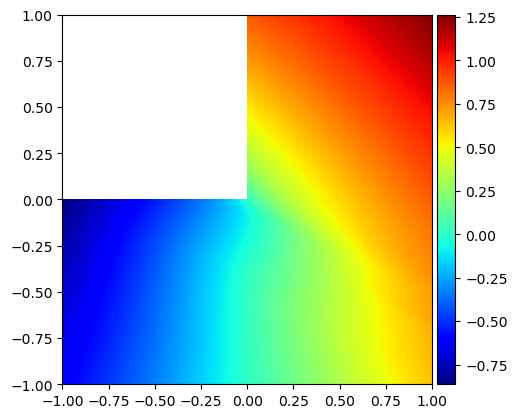

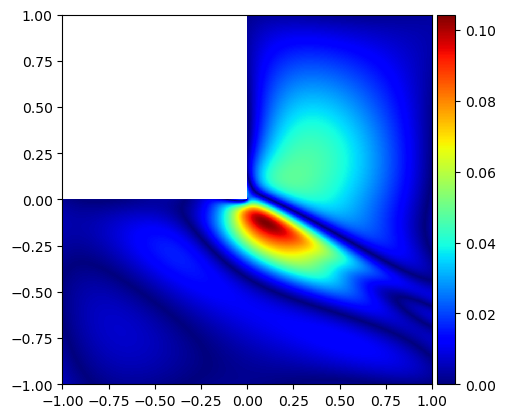

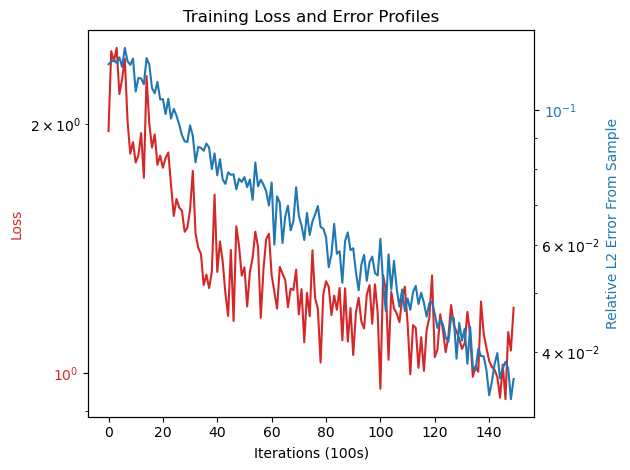

In [28]:
main(arch='srnn_Tanh', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

### DRRNN ReLU

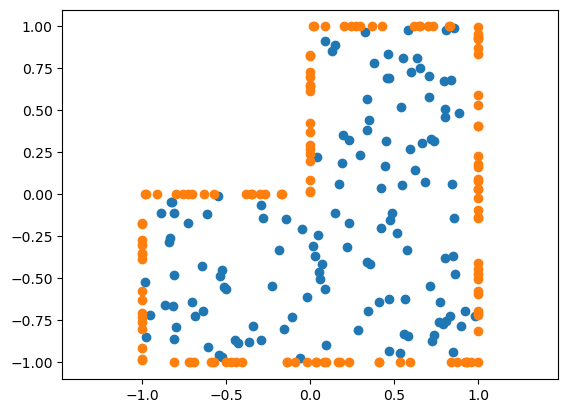

drrnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 2670.61669921875 loss_r: 0.2953640818595886 loss_b: 2670.3212890625
Interior L2 error: 1.0697078704833984
Boundary L2 error: 2.242152690887451


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 14.756589889526367 loss_r: 1.014769434928894 loss_b: 13.741820335388184
Interior L2 error: 0.0755578875541687
Boundary L2 error: 0.1803152859210968
epoch: 200 loss: 2.4606964588165283 loss_r: 0.9908266067504883 loss_b: 1.46986985206604
Interior L2 error: 0.04159888997673988
Boundary L2 error: 0.05779726058244705
epoch: 300 loss: 1.3406869173049927 loss_r: 0.9248383641242981 loss_b: 0.41584858298301697
Interior L2 error: 0.044459521770477295
Boundary L2 error: 0.03819670528173447
epoch: 400 loss: 1.186375617980957 loss_r: 0.9366855025291443 loss_b: 0.24969017505645752
Interior L2 error: 0.04204593598842621
Boundary L2 error: 0.029797988012433052
epoch: 500 loss: 1.1567304134368896 loss_r: 0.8897789716720581 loss_b: 0.26695138216018677
Interior L2 error: 0.04465349391102791
Boundary L2 error: 0.025255301967263222
epoch: 600 loss: 1.2417021989822388 loss_r: 1.0966449975967407 loss_b: 0.14505717158317566
Interior L2 error: 0.04536106437444687
Boundary L2 error: 0.022353986

epoch: 5000 loss: 1.123085379600525 loss_r: 1.0628671646118164 loss_b: 0.06021823734045029
Interior L2 error: 0.057161845266819
Boundary L2 error: 0.011150578036904335
best epoch: 4300 best loss: 0.9168140888214111 L2 error: 0.059385549277067184
load from ckpt!


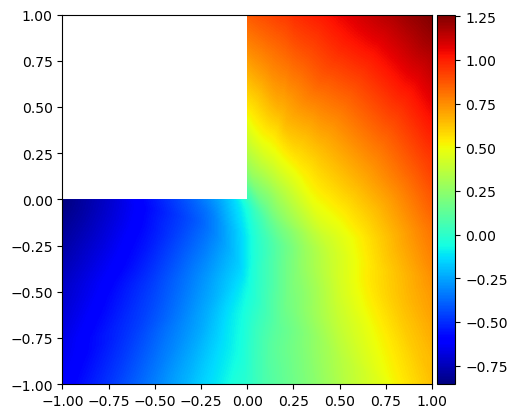

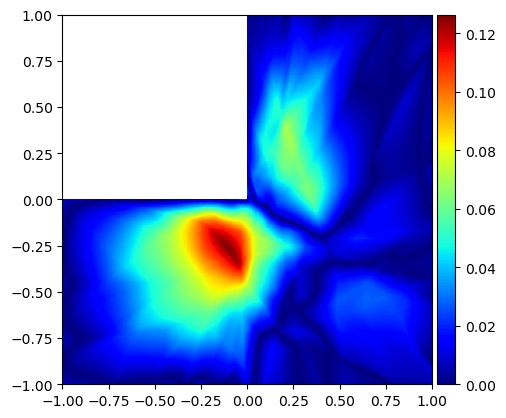

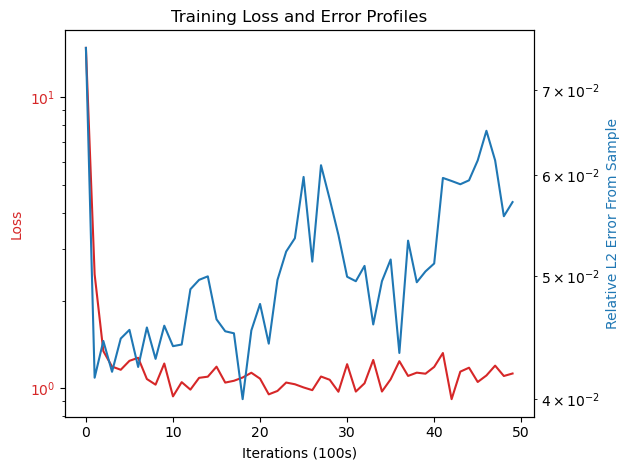

In [29]:
main(arch='drrnn_ReLU', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

drrnn_ReLU


IntProgress(value=0, max=150)

epoch: 0 loss: 1.2211887836456299 loss_r: 1.1000500917434692 loss_b: 0.12113866209983826
Interior L2 error: 0.09811312705278397
Boundary L2 error: 0.14863309264183044


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.0139189958572388 loss_r: 0.9524672031402588 loss_b: 0.061451829969882965
Interior L2 error: 0.055901993066072464
Boundary L2 error: 0.01142759807407856
epoch: 200 loss: 1.1921237707138062 loss_r: 1.0846573114395142 loss_b: 0.10746650397777557
Interior L2 error: 0.06447068601846695
Boundary L2 error: 0.010959912091493607
epoch: 300 loss: 1.1717040538787842 loss_r: 1.1488664150238037 loss_b: 0.022837620228528976
Interior L2 error: 0.05893895402550697
Boundary L2 error: 0.01143315713852644
epoch: 400 loss: 1.1720350980758667 loss_r: 1.0534162521362305 loss_b: 0.11861879378557205
Interior L2 error: 0.061303891241550446
Boundary L2 error: 0.010244235396385193
epoch: 500 loss: 1.0437941551208496 loss_r: 0.9791092872619629 loss_b: 0.06468488276004791
Interior L2 error: 0.05455366149544716
Boundary L2 error: 0.01079822238534689
epoch: 600 loss: 0.9105186462402344 loss_r: 0.8666237592697144 loss_b: 0.04389491677284241
Interior L2 error: 0.05753979831933975
Boundary L2 error: 

epoch: 5000 loss: 1.062690258026123 loss_r: 0.9262517094612122 loss_b: 0.13643860816955566
Interior L2 error: 0.09451174736022949
Boundary L2 error: 0.016624815762043
epoch: 5100 loss: 1.4787747859954834 loss_r: 1.027283787727356 loss_b: 0.45149102807044983
Interior L2 error: 0.10055646300315857
Boundary L2 error: 0.02230151928961277
epoch: 5200 loss: 1.2134696245193481 loss_r: 1.1002968549728394 loss_b: 0.1131727397441864
Interior L2 error: 0.10028443485498428
Boundary L2 error: 0.013673081994056702
epoch: 5300 loss: 1.477549433708191 loss_r: 0.9748967885971069 loss_b: 0.502652645111084
Interior L2 error: 0.10012320429086685
Boundary L2 error: 0.0235599372535944
epoch: 5400 loss: 1.3795192241668701 loss_r: 1.0770480632781982 loss_b: 0.3024711608886719
Interior L2 error: 0.09739858657121658
Boundary L2 error: 0.01698147878050804
epoch: 5500 loss: 1.342769980430603 loss_r: 1.1429535150527954 loss_b: 0.19981645047664642
Interior L2 error: 0.09400055557489395
Boundary L2 error: 0.01556990

epoch: 9900 loss: 1.4385120868682861 loss_r: 1.1965525150299072 loss_b: 0.2419596165418625
Interior L2 error: 0.08847199380397797
Boundary L2 error: 0.018463199958205223
epoch: 10000 loss: 1.4101173877716064 loss_r: 1.1732476949691772 loss_b: 0.2368697077035904
Interior L2 error: 0.09426483511924744
Boundary L2 error: 0.018075983971357346
epoch: 10100 loss: 1.2893726825714111 loss_r: 1.171770453453064 loss_b: 0.11760221421718597
Interior L2 error: 0.10140703618526459
Boundary L2 error: 0.025963181629776955
epoch: 10200 loss: 1.177736520767212 loss_r: 1.0082985162734985 loss_b: 0.16943804919719696
Interior L2 error: 0.09506022930145264
Boundary L2 error: 0.02193082496523857
epoch: 10300 loss: 1.3635478019714355 loss_r: 1.1029822826385498 loss_b: 0.2605655789375305
Interior L2 error: 0.08895138651132584
Boundary L2 error: 0.021237848326563835
epoch: 10400 loss: 1.429074764251709 loss_r: 1.126932144165039 loss_b: 0.30214259028434753
Interior L2 error: 0.10217396914958954
Boundary L2 error

epoch: 14800 loss: 1.523360013961792 loss_r: 1.2331125736236572 loss_b: 0.29024747014045715
Interior L2 error: 0.11544086784124374
Boundary L2 error: 0.01990799978375435
epoch: 14900 loss: 1.7103370428085327 loss_r: 1.317932367324829 loss_b: 0.392404705286026
Interior L2 error: 0.12489550560712814
Boundary L2 error: 0.02328323759138584
epoch: 15000 loss: 1.4386556148529053 loss_r: 1.0656108856201172 loss_b: 0.37304478883743286
Interior L2 error: 0.11385064572095871
Boundary L2 error: 0.021016348153352737
best epoch: 14000 best loss: 1.1981350183486938 L2 error: 0.1256546676158905
load from ckpt!


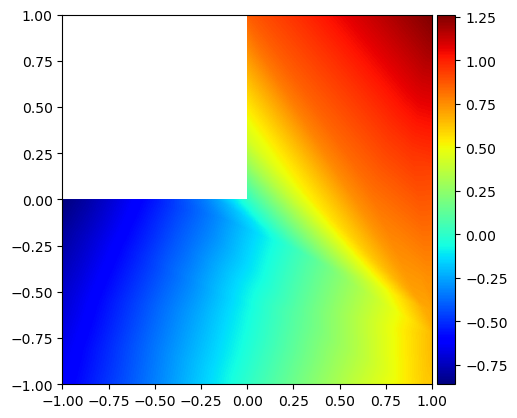

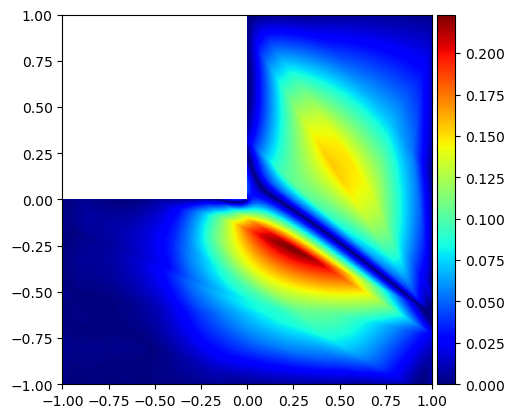

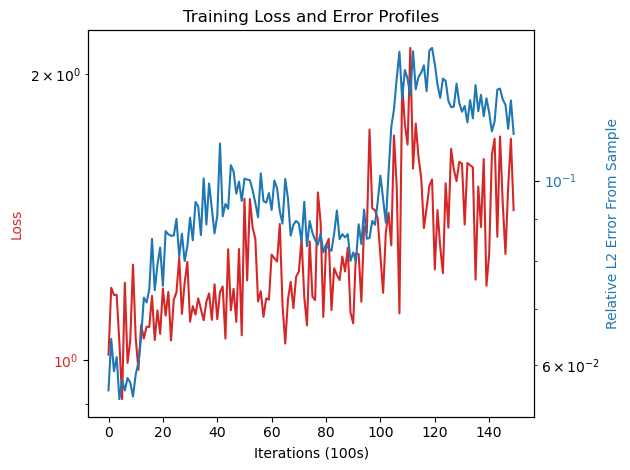

In [30]:
main(arch='drrnn_ReLU', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

### DRRNN Tanh

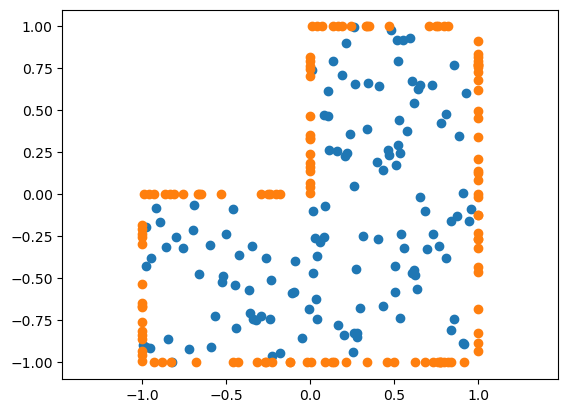

drrnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 1724.303466796875 loss_r: 0.17889009416103363 loss_b: 1724.1246337890625
Interior L2 error: 0.7576671242713928
Boundary L2 error: 1.5788023471832275


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 9.012907981872559 loss_r: 0.9808963537216187 loss_b: 8.032011985778809
Interior L2 error: 0.09205172210931778
Boundary L2 error: 0.1271401196718216
epoch: 200 loss: 5.144984245300293 loss_r: 1.0542476177215576 loss_b: 4.090736389160156
Interior L2 error: 0.11556368321180344
Boundary L2 error: 0.08935648202896118
epoch: 300 loss: 3.1822423934936523 loss_r: 1.0242925882339478 loss_b: 2.157949686050415
Interior L2 error: 0.11057063192129135
Boundary L2 error: 0.07310368120670319
epoch: 400 loss: 3.160975694656372 loss_r: 0.9762784838676453 loss_b: 2.184697151184082
Interior L2 error: 0.10322923958301544
Boundary L2 error: 0.06400730460882187
epoch: 500 loss: 2.468188524246216 loss_r: 0.9211315512657166 loss_b: 1.5470569133758545
Interior L2 error: 0.11020898073911667
Boundary L2 error: 0.05935356393456459
epoch: 600 loss: 2.548736572265625 loss_r: 0.9707851409912109 loss_b: 1.577951431274414
Interior L2 error: 0.09636958688497543
Boundary L2 error: 0.053176265209913254
ep

epoch: 5000 loss: 1.2336169481277466 loss_r: 0.9732922315597534 loss_b: 0.26032474637031555
Interior L2 error: 0.03957671672105789
Boundary L2 error: 0.022530635818839073
best epoch: 4800 best loss: 1.0217921733856201 L2 error: 0.045245807617902756
load from ckpt!


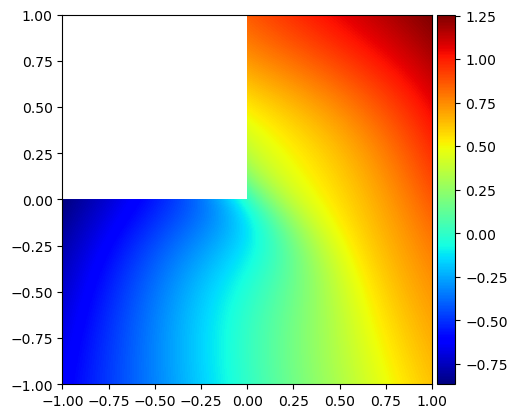

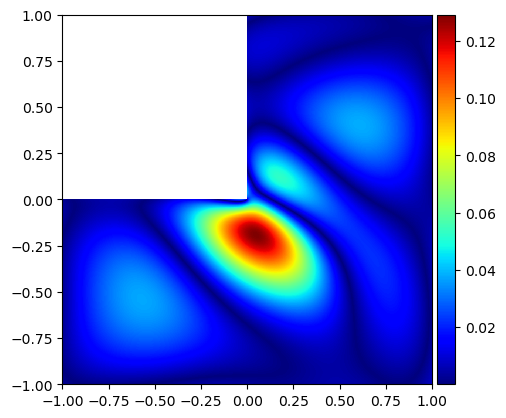

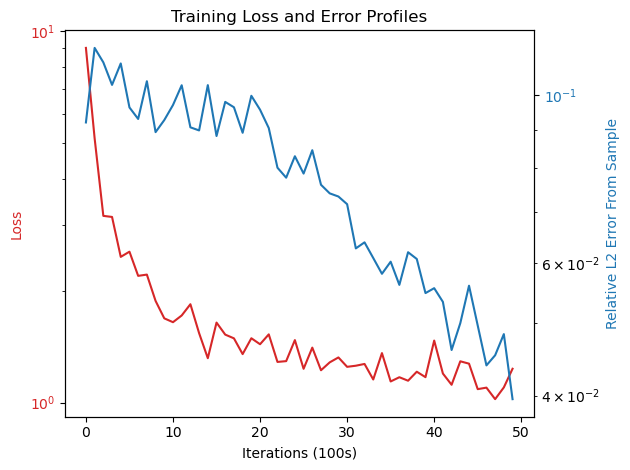

In [31]:
main(arch='drrnn_Tanh', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

drrnn_Tanh


IntProgress(value=0, max=150)

epoch: 0 loss: 1.278820276260376 loss_r: 1.0965317487716675 loss_b: 0.1822884976863861
Interior L2 error: 0.1451694667339325
Boundary L2 error: 0.2343999445438385


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.0086959600448608 loss_r: 0.874943733215332 loss_b: 0.1337522268295288
Interior L2 error: 0.046722445636987686
Boundary L2 error: 0.015600769780576229
epoch: 200 loss: 1.1369316577911377 loss_r: 0.9645975828170776 loss_b: 0.17233413457870483
Interior L2 error: 0.048785530030727386
Boundary L2 error: 0.01574711687862873
epoch: 300 loss: 1.0507264137268066 loss_r: 0.9698036909103394 loss_b: 0.08092272281646729
Interior L2 error: 0.04690880700945854
Boundary L2 error: 0.016558652743697166
epoch: 400 loss: 1.169647455215454 loss_r: 1.0130491256713867 loss_b: 0.15659835934638977
Interior L2 error: 0.04953136295080185
Boundary L2 error: 0.015906238928437233
epoch: 500 loss: 1.1745727062225342 loss_r: 1.0649325847625732 loss_b: 0.10964010655879974
Interior L2 error: 0.04205536097288132
Boundary L2 error: 0.015356818214058876
epoch: 600 loss: 1.2083916664123535 loss_r: 0.9933684468269348 loss_b: 0.21502327919006348
Interior L2 error: 0.04154641553759575
Boundary L2 error: 0.0

epoch: 5000 loss: 0.9656876921653748 loss_r: 0.9185988903045654 loss_b: 0.04708881303668022
Interior L2 error: 0.03268895670771599
Boundary L2 error: 0.011065686121582985
epoch: 5100 loss: 1.0351978540420532 loss_r: 0.9716421365737915 loss_b: 0.0635557696223259
Interior L2 error: 0.03580008074641228
Boundary L2 error: 0.011254970915615559
epoch: 5200 loss: 1.2287635803222656 loss_r: 0.8652160167694092 loss_b: 0.36354759335517883
Interior L2 error: 0.03805585578083992
Boundary L2 error: 0.026249215006828308
epoch: 5300 loss: 1.057466745376587 loss_r: 1.0220518112182617 loss_b: 0.03541499376296997
Interior L2 error: 0.03496171534061432
Boundary L2 error: 0.008407161571085453
epoch: 5400 loss: 0.94035404920578 loss_r: 0.9005494117736816 loss_b: 0.039804648607969284
Interior L2 error: 0.03280051425099373
Boundary L2 error: 0.008552049286663532
epoch: 5500 loss: 1.1263649463653564 loss_r: 1.051428198814392 loss_b: 0.07493669539690018
Interior L2 error: 0.02831869199872017
Boundary L2 error:

epoch: 9800 loss: 0.9575369358062744 loss_r: 0.8436572551727295 loss_b: 0.11387971043586731
Interior L2 error: 0.01414185855537653
Boundary L2 error: 0.010174966417253017
epoch: 9900 loss: 0.9477733373641968 loss_r: 0.9175670146942139 loss_b: 0.03020631894469261
Interior L2 error: 0.01898920349776745
Boundary L2 error: 0.007555015385150909
epoch: 10000 loss: 0.9235132932662964 loss_r: 0.8742924928665161 loss_b: 0.049220819026231766
Interior L2 error: 0.017013143748044968
Boundary L2 error: 0.005793040618300438
epoch: 10100 loss: 1.2333406209945679 loss_r: 1.0092401504516602 loss_b: 0.22410045564174652
Interior L2 error: 0.016664976254105568
Boundary L2 error: 0.016767656430602074
epoch: 10200 loss: 0.8507263660430908 loss_r: 0.8378808498382568 loss_b: 0.01284552551805973
Interior L2 error: 0.01774446852505207
Boundary L2 error: 0.006839700974524021
epoch: 10300 loss: 1.1281414031982422 loss_r: 1.039226770401001 loss_b: 0.08891461789608002
Interior L2 error: 0.014922097325325012
Boundar

epoch: 14600 loss: 1.1358469724655151 loss_r: 1.0507441759109497 loss_b: 0.08510279655456543
Interior L2 error: 0.010917465202510357
Boundary L2 error: 0.010319358669221401
epoch: 14700 loss: 0.9740819931030273 loss_r: 0.9514217376708984 loss_b: 0.022660240530967712
Interior L2 error: 0.007878287695348263
Boundary L2 error: 0.005837859120219946
epoch: 14800 loss: 0.9913558959960938 loss_r: 0.8860009908676147 loss_b: 0.1053549200296402
Interior L2 error: 0.012602104805409908
Boundary L2 error: 0.015359116718173027
epoch: 14900 loss: 0.9784479141235352 loss_r: 0.9500628709793091 loss_b: 0.028385037556290627
Interior L2 error: 0.00889263954013586
Boundary L2 error: 0.006096096243709326
epoch: 15000 loss: 0.9335616827011108 loss_r: 0.8852722644805908 loss_b: 0.04828944802284241
Interior L2 error: 0.009645839221775532
Boundary L2 error: 0.005423229653388262
best epoch: 12400 best loss: 0.8787906765937805 L2 error: 0.011935804039239883
load from ckpt!


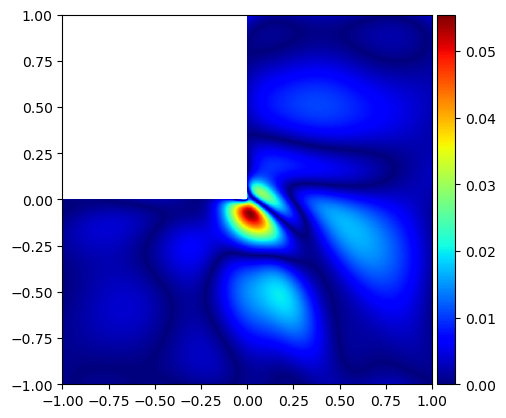

In [32]:
main(arch='drrnn_Tanh', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

### DRFNN ReLU

drfnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 2078.172607421875 loss_r: 7.088100392138585e-05 loss_b: 2078.172607421875
Interior L2 error: 0.9903249740600586
Boundary L2 error: 2.055966377258301


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 517.5088500976562 loss_r: 0.6362186670303345 loss_b: 516.8726196289062
Interior L2 error: 0.43327975273132324
Boundary L2 error: 1.0115739107131958
epoch: 200 loss: 399.0506896972656 loss_r: 0.7141722440719604 loss_b: 398.3365173339844
Interior L2 error: 0.36423400044441223
Boundary L2 error: 0.8594904541969299
epoch: 300 loss: 264.81182861328125 loss_r: 0.6978292465209961 loss_b: 264.114013671875
Interior L2 error: 0.29457613825798035
Boundary L2 error: 0.734104335308075
epoch: 400 loss: 193.47544860839844 loss_r: 0.7677936553955078 loss_b: 192.70765686035156
Interior L2 error: 0.23875568807125092
Boundary L2 error: 0.6258366107940674
epoch: 500 loss: 132.0588836669922 loss_r: 0.7453487515449524 loss_b: 131.31353759765625
Interior L2 error: 0.19490422308444977
Boundary L2 error: 0.5327582955360413
epoch: 600 loss: 99.72026062011719 loss_r: 0.9761734008789062 loss_b: 98.74408721923828
Interior L2 error: 0.14561128616333008
Boundary L2 error: 0.4530349373817444
epoch: 7

epoch: 5000 loss: 1.1618918180465698 loss_r: 0.9837461709976196 loss_b: 0.1781456023454666
Interior L2 error: 0.075107142329216
Boundary L2 error: 0.02281785197556019
best epoch: 4100 best loss: 0.9101654291152954 L2 error: 0.06735137850046158
load from ckpt!


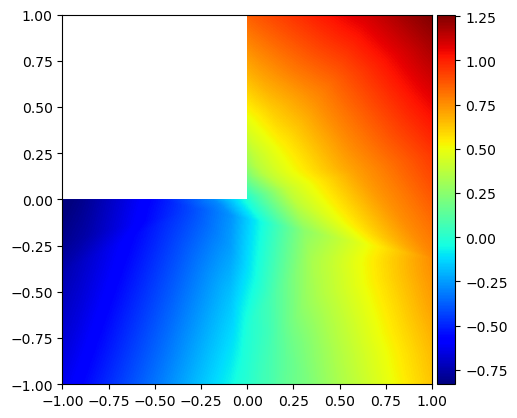

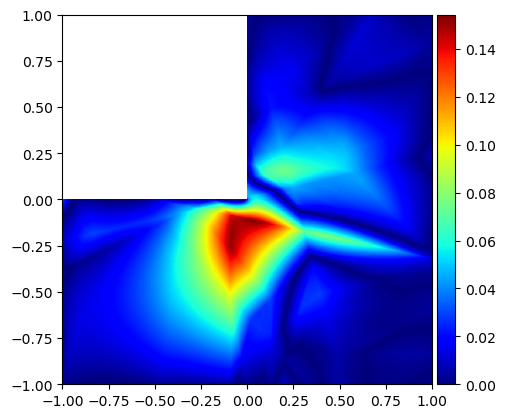

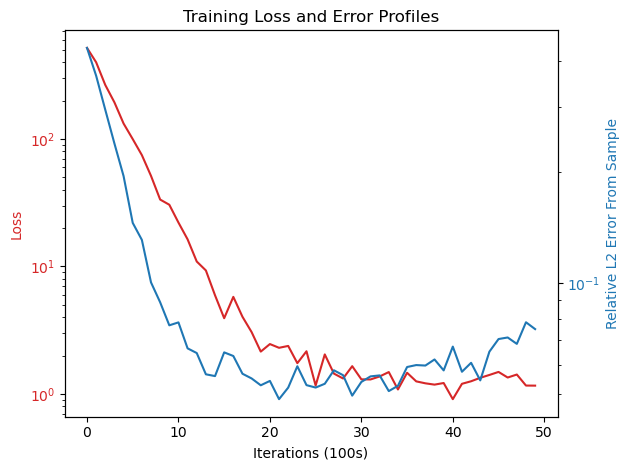

In [33]:
main(arch='drfnn_ReLU', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

drfnn_ReLU


IntProgress(value=0, max=150)

epoch: 0 loss: 1.3075082302093506 loss_r: 1.0999462604522705 loss_b: 0.20756201446056366
Interior L2 error: 0.0998464897274971
Boundary L2 error: 0.16714666783809662


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.3467473983764648 loss_r: 1.1978569030761719 loss_b: 0.14889048039913177
Interior L2 error: 0.06087221950292587
Boundary L2 error: 0.01971777342259884
epoch: 200 loss: 1.1209256649017334 loss_r: 0.9060813188552856 loss_b: 0.21484440565109253
Interior L2 error: 0.06658647954463959
Boundary L2 error: 0.019219432026147842
epoch: 300 loss: 1.142228126525879 loss_r: 0.9919875860214233 loss_b: 0.1502404808998108
Interior L2 error: 0.07053251564502716
Boundary L2 error: 0.018920229747891426
epoch: 400 loss: 1.2117712497711182 loss_r: 1.032288670539856 loss_b: 0.1794826239347458
Interior L2 error: 0.06717511266469955
Boundary L2 error: 0.018622754141688347
epoch: 500 loss: 1.184911847114563 loss_r: 0.9877143502235413 loss_b: 0.19719745218753815
Interior L2 error: 0.06856192648410797
Boundary L2 error: 0.01966078393161297
epoch: 600 loss: 1.2988290786743164 loss_r: 1.0561864376068115 loss_b: 0.2426425963640213
Interior L2 error: 0.07406609505414963
Boundary L2 error: 0.0186732

epoch: 5000 loss: 1.476610779762268 loss_r: 1.0807085037231445 loss_b: 0.3959023058414459
Interior L2 error: 0.08325807750225067
Boundary L2 error: 0.017721028998494148
epoch: 5100 loss: 1.583329677581787 loss_r: 1.417880654335022 loss_b: 0.16544896364212036
Interior L2 error: 0.0867961198091507
Boundary L2 error: 0.016796616837382317
epoch: 5200 loss: 1.4684627056121826 loss_r: 1.310385823249817 loss_b: 0.15807689726352692
Interior L2 error: 0.08221323043107986
Boundary L2 error: 0.01874600350856781
epoch: 5300 loss: 1.119505524635315 loss_r: 1.0049837827682495 loss_b: 0.11452170461416245
Interior L2 error: 0.07947168499231339
Boundary L2 error: 0.01739366166293621
epoch: 5400 loss: 1.3183634281158447 loss_r: 1.0833015441894531 loss_b: 0.2350618839263916
Interior L2 error: 0.09159798175096512
Boundary L2 error: 0.01776808500289917
epoch: 5500 loss: 1.251626968383789 loss_r: 0.9797118902206421 loss_b: 0.27191510796546936
Interior L2 error: 0.09123966842889786
Boundary L2 error: 0.02348

epoch: 9900 loss: 1.6806992292404175 loss_r: 1.332737684249878 loss_b: 0.34796154499053955
Interior L2 error: 0.08829646557569504
Boundary L2 error: 0.021915661171078682
epoch: 10000 loss: 1.363034963607788 loss_r: 0.9426261186599731 loss_b: 0.4204089045524597
Interior L2 error: 0.08813200145959854
Boundary L2 error: 0.021846028044819832
epoch: 10100 loss: 1.4413951635360718 loss_r: 0.9875513315200806 loss_b: 0.4538438618183136
Interior L2 error: 0.09703772515058517
Boundary L2 error: 0.022576531395316124
epoch: 10200 loss: 1.5080432891845703 loss_r: 1.3248765468597412 loss_b: 0.1831667423248291
Interior L2 error: 0.08740885555744171
Boundary L2 error: 0.021060165017843246
epoch: 10300 loss: 1.2211544513702393 loss_r: 0.9613214731216431 loss_b: 0.2598329782485962
Interior L2 error: 0.0997147485613823
Boundary L2 error: 0.023388177156448364
epoch: 10400 loss: 1.1494076251983643 loss_r: 0.9532616138458252 loss_b: 0.19614607095718384
Interior L2 error: 0.09649966657161713
Boundary L2 erro

epoch: 14800 loss: 1.3623496294021606 loss_r: 1.1045851707458496 loss_b: 0.2577644884586334
Interior L2 error: 0.09497585892677307
Boundary L2 error: 0.026215331628918648
epoch: 14900 loss: 1.703805923461914 loss_r: 1.1610996723175049 loss_b: 0.5427062511444092
Interior L2 error: 0.0927644670009613
Boundary L2 error: 0.022472599521279335
epoch: 15000 loss: 1.3346152305603027 loss_r: 1.0328834056854248 loss_b: 0.30173176527023315
Interior L2 error: 0.09450555592775345
Boundary L2 error: 0.021951518952846527
best epoch: 14400 best loss: 1.145283818244934 L2 error: 0.09169970452785492
load from ckpt!


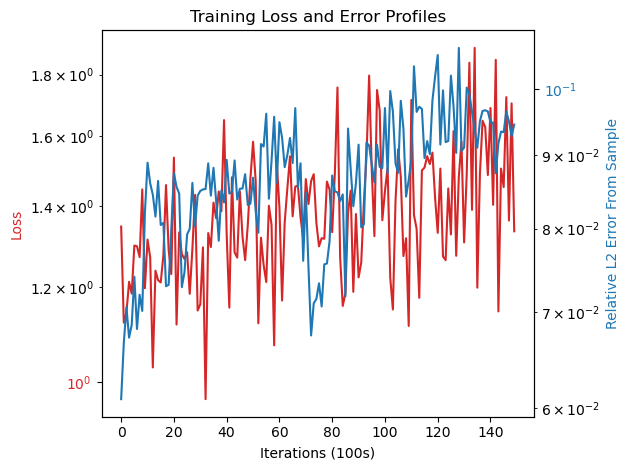

In [34]:
main(arch='drfnn_ReLU', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

### DRFNN Tanh

drfnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 2635.4658203125 loss_r: 0.018857799470424652 loss_b: 2635.447021484375
Interior L2 error: 1.0946547985076904
Boundary L2 error: 2.2607052326202393


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 23.446128845214844 loss_r: 0.9980909824371338 loss_b: 22.44803810119629
Interior L2 error: 0.19759146869182587
Boundary L2 error: 0.20530608296394348
epoch: 200 loss: 8.118507385253906 loss_r: 1.2951761484146118 loss_b: 6.823330879211426
Interior L2 error: 0.18465174734592438
Boundary L2 error: 0.11265948414802551
epoch: 300 loss: 4.6267595291137695 loss_r: 1.2266768217086792 loss_b: 3.400082588195801
Interior L2 error: 0.16436706483364105
Boundary L2 error: 0.10495365411043167
epoch: 400 loss: 3.921086549758911 loss_r: 1.165945053100586 loss_b: 2.755141496658325
Interior L2 error: 0.16829507052898407
Boundary L2 error: 0.09853701293468475
epoch: 500 loss: 6.327727317810059 loss_r: 1.0559903383255005 loss_b: 5.271737098693848
Interior L2 error: 0.16454073786735535
Boundary L2 error: 0.09288673847913742
epoch: 600 loss: 4.8836750984191895 loss_r: 1.1555066108703613 loss_b: 3.728168487548828
Interior L2 error: 0.1531028300523758
Boundary L2 error: 0.09076354652643204
epo

epoch: 5000 loss: 1.7202999591827393 loss_r: 1.2180477380752563 loss_b: 0.5022522211074829
Interior L2 error: 0.14060546457767487
Boundary L2 error: 0.03253538906574249
best epoch: 4900 best loss: 1.3850772380828857 L2 error: 0.1472586989402771
load from ckpt!


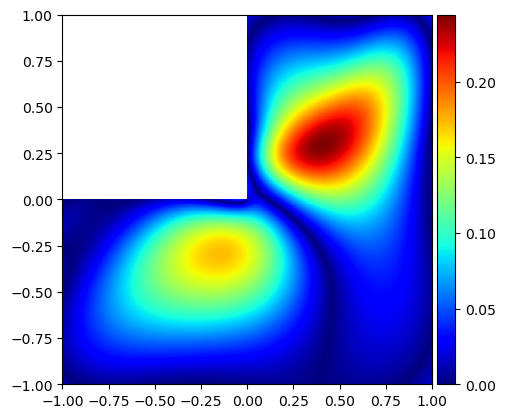

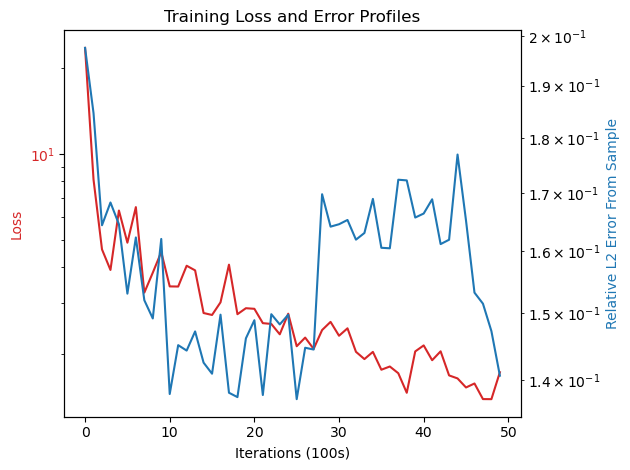

In [35]:
main(arch='drfnn_Tanh', domain='l_shape', lr =1e-3, epochs=5000, pretrain=2)

drfnn_Tanh


IntProgress(value=0, max=150)

epoch: 0 loss: 1.4979631900787354 loss_r: 1.079033613204956 loss_b: 0.4189295172691345
Interior L2 error: 0.20758840441703796
Boundary L2 error: 0.15952812135219574


/tmp/ipykernel_260/3885018512.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_260/3885018512.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_260/3885018512.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.5553929805755615 loss_r: 1.155896544456482 loss_b: 0.39949649572372437
Interior L2 error: 0.15651081502437592
Boundary L2 error: 0.02696416713297367
epoch: 200 loss: 1.4157854318618774 loss_r: 1.1204107999801636 loss_b: 0.2953746020793915
Interior L2 error: 0.16028594970703125
Boundary L2 error: 0.025647856295108795
epoch: 300 loss: 1.7301578521728516 loss_r: 1.2388492822647095 loss_b: 0.49130862951278687
Interior L2 error: 0.1314357966184616
Boundary L2 error: 0.02590545266866684
epoch: 400 loss: 1.7195618152618408 loss_r: 1.322181224822998 loss_b: 0.39738065004348755
Interior L2 error: 0.1419278383255005
Boundary L2 error: 0.025449516251683235
epoch: 500 loss: 1.4307446479797363 loss_r: 0.9694111347198486 loss_b: 0.4613335132598877
Interior L2 error: 0.13497166335582733
Boundary L2 error: 0.02804345078766346
epoch: 600 loss: 1.2762988805770874 loss_r: 1.0168904066085815 loss_b: 0.25940844416618347
Interior L2 error: 0.1239311620593071
Boundary L2 error: 0.028566511

epoch: 5000 loss: 1.0372400283813477 loss_r: 1.000391960144043 loss_b: 0.03684806451201439
Interior L2 error: 0.03929562494158745
Boundary L2 error: 0.00924755074083805
epoch: 5100 loss: 0.9543382525444031 loss_r: 0.9159760475158691 loss_b: 0.03836221992969513
Interior L2 error: 0.03342055529356003
Boundary L2 error: 0.010502245277166367
epoch: 5200 loss: 1.247308373451233 loss_r: 1.1469311714172363 loss_b: 0.1003771722316742
Interior L2 error: 0.03709271550178528
Boundary L2 error: 0.009107445366680622
epoch: 5300 loss: 1.0650357007980347 loss_r: 0.9859421253204346 loss_b: 0.07909361273050308
Interior L2 error: 0.03293248638510704
Boundary L2 error: 0.009870885871350765
epoch: 5400 loss: 1.0557730197906494 loss_r: 0.9577397108078003 loss_b: 0.0980333536863327
Interior L2 error: 0.03549070656299591
Boundary L2 error: 0.007935453206300735
epoch: 5500 loss: 1.0078850984573364 loss_r: 0.917756974697113 loss_b: 0.09012807905673981
Interior L2 error: 0.03385442495346069
Boundary L2 error: 0

epoch: 9800 loss: 0.977610170841217 loss_r: 0.9237383008003235 loss_b: 0.053871870040893555
Interior L2 error: 0.02597184106707573
Boundary L2 error: 0.007799311075359583
epoch: 9900 loss: 0.8477835655212402 loss_r: 0.8374319672584534 loss_b: 0.010351622477173805
Interior L2 error: 0.02965759113430977
Boundary L2 error: 0.007535560522228479
epoch: 10000 loss: 0.9412428140640259 loss_r: 0.9160410165786743 loss_b: 0.02520180121064186
Interior L2 error: 0.02478398010134697
Boundary L2 error: 0.006746137980371714
epoch: 10100 loss: 1.058847427368164 loss_r: 1.0204622745513916 loss_b: 0.03838516026735306
Interior L2 error: 0.02854343131184578
Boundary L2 error: 0.007209429517388344
epoch: 10200 loss: 0.8824679851531982 loss_r: 0.8641753792762756 loss_b: 0.018292585387825966
Interior L2 error: 0.026086831465363503
Boundary L2 error: 0.007041680160909891
epoch: 10300 loss: 1.1055577993392944 loss_r: 1.0123211145401 loss_b: 0.09323666244745255
Interior L2 error: 0.02518751472234726
Boundary L2

epoch: 14600 loss: 0.9110301733016968 loss_r: 0.8780444860458374 loss_b: 0.03298567607998848
Interior L2 error: 0.020855335518717766
Boundary L2 error: 0.006022456102073193
epoch: 14700 loss: 0.9413277506828308 loss_r: 0.8976851105690002 loss_b: 0.04364262893795967
Interior L2 error: 0.020836854353547096
Boundary L2 error: 0.010479415766894817
epoch: 14800 loss: 0.9713971614837646 loss_r: 0.865349292755127 loss_b: 0.10604787617921829
Interior L2 error: 0.020728059113025665
Boundary L2 error: 0.014105827547609806
epoch: 14900 loss: 1.0454074144363403 loss_r: 0.9140987396240234 loss_b: 0.1313086301088333
Interior L2 error: 0.019745105877518654
Boundary L2 error: 0.014390707947313786
epoch: 15000 loss: 0.9053700566291809 loss_r: 0.898486852645874 loss_b: 0.006883206777274609
Interior L2 error: 0.021218666806817055
Boundary L2 error: 0.0061076548881828785
best epoch: 12200 best loss: 0.8889707922935486 L2 error: 0.023952923715114594
load from ckpt!


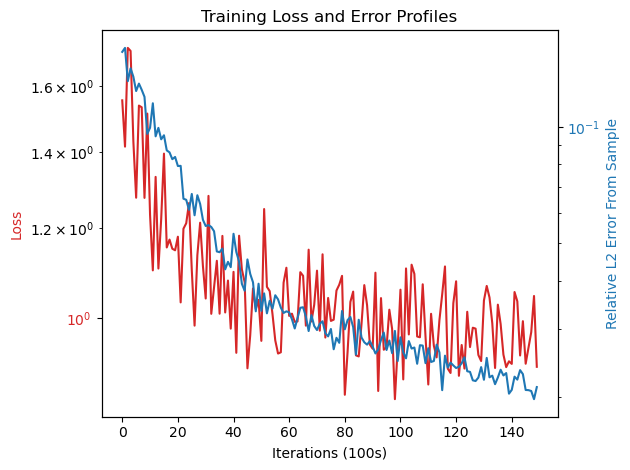

In [36]:
main(arch='drfnn_Tanh', domain='l_shape', lr =1e-3, epochs=15000, pretrain=1)

--------------------------------------------------------------------------------------------------------------------------------

# Exact Solution

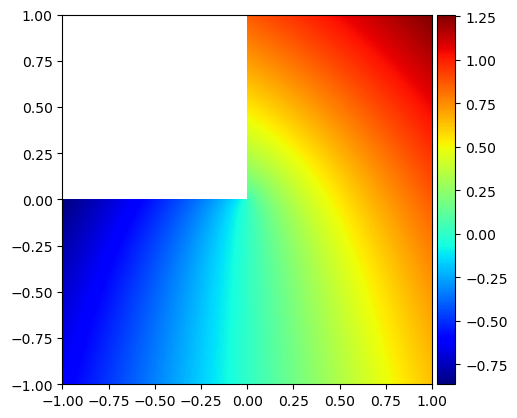

/tmp/ipykernel_191/3955148871.py:72: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf = ax.scatter(A[:,0], A[:,1], B, cmap=cm.jet, linewidth=0)


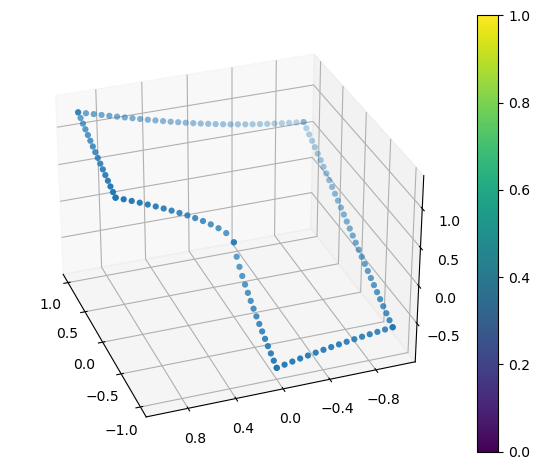

(126,)


/tmp/ipykernel_191/3955148871.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf1 = ax.scatter(A[:,0], A[:,1], B.numpy(), cmap=cm.jet, linewidth=0, color = 'r')
/tmp/ipykernel_191/3955148871.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf1 = ax.scatter(A2[:,0], A2[:,1], B2.numpy(), cmap=cm.jet, linewidth=0, color = 'r')
/tmp/ipykernel_191/3955148871.py:106: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf2 = ax.scatter(A[:,0], A[:,1], D.detach().numpy(), cmap=cm.jet, linewidth=0, color = 'b')
/tmp/ipykernel_191/3955148871.py:107: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf3 = ax.scatter(A2[:,0], A2[:,1], D2.detach().numpy(), cmap=cm.jet, linewidth=0, color = 'b')


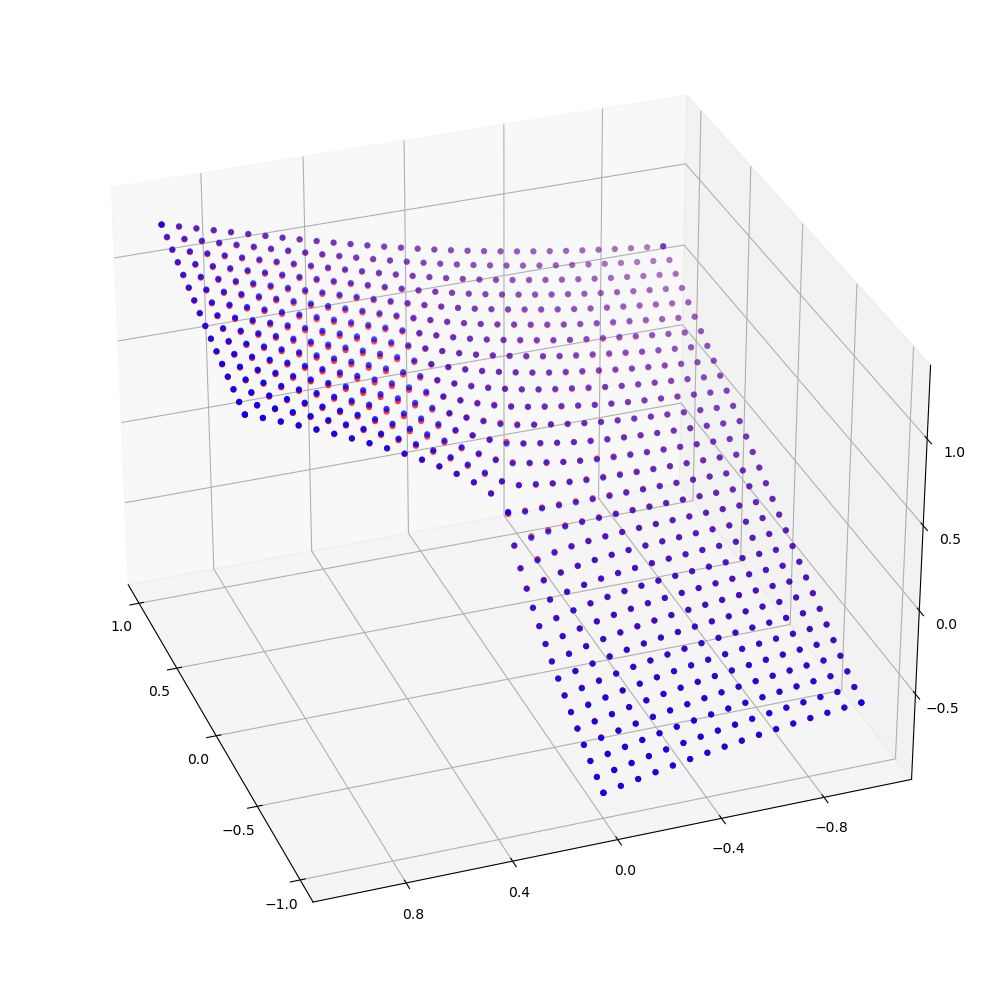

In [25]:
# PLOT OF THE TRUE SOLUTION
import numpy as np
import torch

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import figure

from numpy.random import randn
from scipy import array, newaxis

num_points=1001
x = torch.linspace(-1, 1, 1001)
Y, X = torch.meshgrid(x, x)

device = torch.device('cpu')
A = get_boundary_points_l_shape_reg(500)
A2 = get_interior_points_l_shape_reg(16)

Z = (X**2+Y**2)**(1/3)*torch.sin((2*torch.atan2(Y,X)+torch.pi)/3)


switch = -2*(A[:,1] == 0) + 1
switch2 = -2*(A2[:,1] == 0) + 1
#true_sol = torch.pow(torch.sum(torch.pow(xb,2),dim=1),1/3) \
#                    *torch.sin((switch*2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)

B = (A[:,0]**2+A[:,1]**2)**(1/3)*torch.sin((switch*2*torch.atan2(A[:,1],A[:,0])+torch.pi)/3)
B2 = (A2[:,0]**2+A2[:,1]**2)**(1/3)*torch.sin((switch2*2*torch.atan2(A2[:,1],A2[:,0])+torch.pi)/3)

mask1 = (X >= 0) #or (Y <= 0)
mask2 = (Y <= 0)
mask = mask1 + mask2 #+ 1

m1 = (A[:,0] >= 0)
m2 = (A[:,1] <= 0)
m = m1 + m2

#A = np.ma.array(A, mask=m)
#A.compressed()

Z2 = np.empty((1001, 1001))
Z2.fill(np.nan)
np.putmask(Z2, mask, Z)

C = np.empty_like(B)
C.fill(np.nan)
np.putmask(C, m, B)

# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(Z2, interpolation='nearest', cmap='jet',
               extent=[-1, 1, -1, 1],
               origin='lower', aspect='equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
plt.savefig('exact_solutions/L_shape.png')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.scatter(A[:,0], A[:,1], B, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.view_init(azim=160)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.savefig('pointwise_plots/L_shape_boundary.png')
plt.show()


model = drrnn_Tanh(2, 10, 1).to(device)
    
# PLOT SETUP
#model.load_state_dict(torch.load('new_best_deep_ritz_l_shape_reg_srnn_Tanh_40000.mdl'))
model.load_state_dict(torch.load('new_best_deep_ritz_l_shape_drrnn_Tanh_40000.mdl'))
D = model(A)
D2 = model(A2)
#model.load_state_dict(torch.load('new_best_deep_ritz_old_l_shape_reg_drrnn_Tanh_30000.mdl'))
#E = model(A)

#B = torch.pow(torch.sum(torch.pow(A,2),dim=1),1/3)*torch.sin((switch*2*torch.atan2(A[:,1:],A[:,:1])+torch.pi)/3)
print(B.numpy().shape)
fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf1 = ax.scatter(A[:,0], A[:,1], B.numpy(), cmap=cm.jet, linewidth=0, color = 'r')
surf1 = ax.scatter(A2[:,0], A2[:,1], B2.numpy(), cmap=cm.jet, linewidth=0, color = 'r')
surf2 = ax.scatter(A[:,0], A[:,1], D.detach().numpy(), cmap=cm.jet, linewidth=0, color = 'b')
surf3 = ax.scatter(A2[:,0], A2[:,1], D2.detach().numpy(), cmap=cm.jet, linewidth=0, color = 'b')
#fig.colorbar(surf)

ax.view_init(azim=160)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

#my_path = os.path.abspath(__file__)
plt.savefig('pointwise_plots/L_shape.png')
plt.show()

### Shallow NN, ReLU Activation

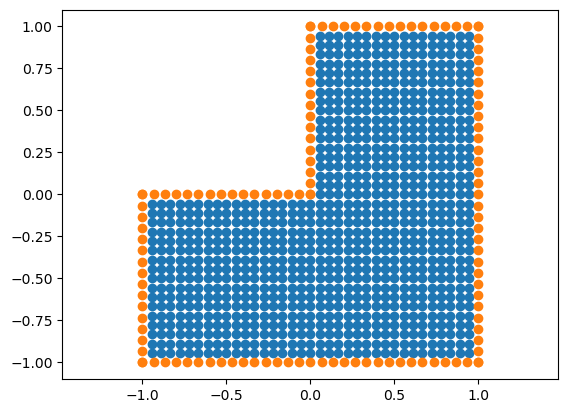

srnn_ReLU


IntProgress(value=0, max=400)

epoch: 0 loss: 2520.86962890625 loss_r: 0.03829089552164078 loss_b: 2520.831298828125
Interior L2 error: 1.113939642906189
Boundary L2 error: 2.1896755695343018


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 18.300121307373047 loss_r: 0.9916330575942993 loss_b: 17.308488845825195
Interior L2 error: 0.06846366077661514
Boundary L2 error: 0.18445448577404022
epoch: 200 loss: 6.545009613037109 loss_r: 1.0318660736083984 loss_b: 5.513143539428711
Interior L2 error: 0.04978614300489426
Boundary L2 error: 0.10469431430101395
epoch: 300 loss: 4.516756534576416 loss_r: 1.0370327234268188 loss_b: 3.4797239303588867
Interior L2 error: 0.0522274412214756
Boundary L2 error: 0.08324827998876572
epoch: 400 loss: 3.3244142532348633 loss_r: 1.0447700023651123 loss_b: 2.279644250869751
Interior L2 error: 0.05978250131011009
Boundary L2 error: 0.06737682968378067
epoch: 500 loss: 2.5379090309143066 loss_r: 1.0382885932922363 loss_b: 1.4996205568313599
Interior L2 error: 0.06362777203321457
Boundary L2 error: 0.054671116173267365
epoch: 600 loss: 2.1383302211761475 loss_r: 1.0315134525299072 loss_b: 1.1068167686462402
Interior L2 error: 0.06874585896730423
Boundary L2 error: 0.04698186740279

epoch: 5000 loss: 1.1983674764633179 loss_r: 1.0695929527282715 loss_b: 0.12877453863620758
Interior L2 error: 0.08326373994350433
Boundary L2 error: 0.015996214002370834
epoch: 5100 loss: 1.1961771249771118 loss_r: 1.0696172714233398 loss_b: 0.12655989825725555
Interior L2 error: 0.08851920813322067
Boundary L2 error: 0.01601065695285797
epoch: 5200 loss: 1.208426594734192 loss_r: 1.0771205425262451 loss_b: 0.1313060224056244
Interior L2 error: 0.0920419991016388
Boundary L2 error: 0.01596495695412159
epoch: 5300 loss: 1.20223069190979 loss_r: 1.0773860216140747 loss_b: 0.12484470754861832
Interior L2 error: 0.09026587754487991
Boundary L2 error: 0.0158675629645586
epoch: 5400 loss: 1.2049912214279175 loss_r: 1.0745460987091064 loss_b: 0.13044507801532745
Interior L2 error: 0.09374549239873886
Boundary L2 error: 0.01617451198399067
epoch: 5500 loss: 1.2066655158996582 loss_r: 1.068557620048523 loss_b: 0.13810785114765167
Interior L2 error: 0.09136854112148285
Boundary L2 error: 0.0162

epoch: 9900 loss: 1.2683614492416382 loss_r: 1.1089633703231812 loss_b: 0.15939807891845703
Interior L2 error: 0.09590255469083786
Boundary L2 error: 0.017915645614266396
epoch: 10000 loss: 1.2794747352600098 loss_r: 1.1051669120788574 loss_b: 0.17430776357650757
Interior L2 error: 0.09461289644241333
Boundary L2 error: 0.018485913053154945
epoch: 10100 loss: 1.2729374170303345 loss_r: 1.1096868515014648 loss_b: 0.16325055062770844
Interior L2 error: 0.0913650318980217
Boundary L2 error: 0.018096989020705223
epoch: 10200 loss: 1.2814044952392578 loss_r: 1.1056077480316162 loss_b: 0.17579680681228638
Interior L2 error: 0.0924440249800682
Boundary L2 error: 0.018217286095023155
epoch: 10300 loss: 1.2572458982467651 loss_r: 1.1010849475860596 loss_b: 0.15616096556186676
Interior L2 error: 0.08996326476335526
Boundary L2 error: 0.01769588142633438
epoch: 10400 loss: 1.2604076862335205 loss_r: 1.0991642475128174 loss_b: 0.1612434685230255
Interior L2 error: 0.09729284048080444
Boundary L2 e

epoch: 14700 loss: 1.272841215133667 loss_r: 1.109516978263855 loss_b: 0.16332417726516724
Interior L2 error: 0.08674122393131256
Boundary L2 error: 0.018205052241683006
epoch: 14800 loss: 1.310343623161316 loss_r: 1.1103076934814453 loss_b: 0.20003588497638702
Interior L2 error: 0.0853605717420578
Boundary L2 error: 0.019998889416456223
epoch: 14900 loss: 1.3054991960525513 loss_r: 1.122399091720581 loss_b: 0.18310008943080902
Interior L2 error: 0.08718554675579071
Boundary L2 error: 0.019145376980304718
epoch: 15000 loss: 1.349941611289978 loss_r: 1.1301884651184082 loss_b: 0.21975316107273102
Interior L2 error: 0.08643456548452377
Boundary L2 error: 0.019980281591415405
epoch: 15100 loss: 1.3210647106170654 loss_r: 1.1219602823257446 loss_b: 0.1991044282913208
Interior L2 error: 0.09027844667434692
Boundary L2 error: 0.019987646490335464
epoch: 15200 loss: 1.3213658332824707 loss_r: 1.1316993236541748 loss_b: 0.1896665096282959
Interior L2 error: 0.08510059118270874
Boundary L2 erro

epoch: 19600 loss: 1.304886817932129 loss_r: 1.106826901435852 loss_b: 0.19805996119976044
Interior L2 error: 0.10078949481248856
Boundary L2 error: 0.019770942628383636
epoch: 19700 loss: 1.2920536994934082 loss_r: 1.1074411869049072 loss_b: 0.1846124529838562
Interior L2 error: 0.09401945024728775
Boundary L2 error: 0.019310077652335167
epoch: 19800 loss: 1.2925857305526733 loss_r: 1.1065654754638672 loss_b: 0.18602021038532257
Interior L2 error: 0.09021938592195511
Boundary L2 error: 0.019287094473838806
epoch: 19900 loss: 1.2932013273239136 loss_r: 1.1086822748184204 loss_b: 0.18451906740665436
Interior L2 error: 0.09514286369085312
Boundary L2 error: 0.01933836191892624
epoch: 20000 loss: 1.289422631263733 loss_r: 1.102159023284912 loss_b: 0.18726356327533722
Interior L2 error: 0.09076811373233795
Boundary L2 error: 0.019653674215078354
epoch: 20100 loss: 1.3086165189743042 loss_r: 1.105817198753357 loss_b: 0.20279936492443085
Interior L2 error: 0.10465754568576813
Boundary L2 err

epoch: 24400 loss: 1.3104255199432373 loss_r: 1.1141021251678467 loss_b: 0.19632333517074585
Interior L2 error: 0.08356112241744995
Boundary L2 error: 0.020291706547141075
epoch: 24500 loss: 1.2805769443511963 loss_r: 1.1121771335601807 loss_b: 0.16839981079101562
Interior L2 error: 0.09439649432897568
Boundary L2 error: 0.018356408923864365
epoch: 24600 loss: 1.3338098526000977 loss_r: 1.1141226291656494 loss_b: 0.21968725323677063
Interior L2 error: 0.091875821352005
Boundary L2 error: 0.02071799337863922
epoch: 24700 loss: 1.292508602142334 loss_r: 1.1106352806091309 loss_b: 0.18187332153320312
Interior L2 error: 0.08789606392383575
Boundary L2 error: 0.019310319796204567
epoch: 24800 loss: 1.2779566049575806 loss_r: 1.1093041896820068 loss_b: 0.1686524599790573
Interior L2 error: 0.09347130358219147
Boundary L2 error: 0.018312938511371613
epoch: 24900 loss: 1.3126094341278076 loss_r: 1.1090576648712158 loss_b: 0.20355181396007538
Interior L2 error: 0.09091561287641525
Boundary L2 e

epoch: 29200 loss: 1.2927135229110718 loss_r: 1.1102008819580078 loss_b: 0.18251264095306396
Interior L2 error: 0.08618631213903427
Boundary L2 error: 0.019454091787338257
epoch: 29300 loss: 1.3007484674453735 loss_r: 1.1079087257385254 loss_b: 0.19283972680568695
Interior L2 error: 0.08880241960287094
Boundary L2 error: 0.019602980464696884
epoch: 29400 loss: 1.3397916555404663 loss_r: 1.1122922897338867 loss_b: 0.2274993360042572
Interior L2 error: 0.08444246649742126
Boundary L2 error: 0.021370675414800644
epoch: 29500 loss: 1.2852873802185059 loss_r: 1.1110750436782837 loss_b: 0.17421235144138336
Interior L2 error: 0.08754676580429077
Boundary L2 error: 0.018729470670223236
epoch: 29600 loss: 1.2939472198486328 loss_r: 1.110905647277832 loss_b: 0.18304157257080078
Interior L2 error: 0.09138940274715424
Boundary L2 error: 0.019432205706834793
epoch: 29700 loss: 1.2855607271194458 loss_r: 1.111648678779602 loss_b: 0.17391200363636017
Interior L2 error: 0.09037210792303085
Boundary L2

epoch: 34100 loss: 1.3313772678375244 loss_r: 1.1162467002868652 loss_b: 0.21513062715530396
Interior L2 error: 0.08689877390861511
Boundary L2 error: 0.024447869509458542
epoch: 34200 loss: 1.2956650257110596 loss_r: 1.1215885877609253 loss_b: 0.17407642304897308
Interior L2 error: 0.09111210703849792
Boundary L2 error: 0.01867026835680008
epoch: 34300 loss: 1.2937371730804443 loss_r: 1.1200501918792725 loss_b: 0.1736869364976883
Interior L2 error: 0.09064935892820358
Boundary L2 error: 0.018623201176524162
epoch: 34400 loss: 1.29496431350708 loss_r: 1.1200969219207764 loss_b: 0.17486733198165894
Interior L2 error: 0.08302021026611328
Boundary L2 error: 0.01861637458205223
epoch: 34500 loss: 1.2931784391403198 loss_r: 1.119971513748169 loss_b: 0.17320695519447327
Interior L2 error: 0.0843125656247139
Boundary L2 error: 0.018715137615799904
epoch: 34600 loss: 1.3569103479385376 loss_r: 1.1043988466262817 loss_b: 0.25251150131225586
Interior L2 error: 0.08322764933109283
Boundary L2 err

epoch: 38900 loss: 1.2840280532836914 loss_r: 1.1067157983779907 loss_b: 0.1773122400045395
Interior L2 error: 0.08053398877382278
Boundary L2 error: 0.01887582056224346
epoch: 39000 loss: 1.290202260017395 loss_r: 1.1103099584579468 loss_b: 0.17989225685596466
Interior L2 error: 0.08701849728822708
Boundary L2 error: 0.01873442716896534
epoch: 39100 loss: 1.2971913814544678 loss_r: 1.1104850769042969 loss_b: 0.1867062747478485
Interior L2 error: 0.08602748066186905
Boundary L2 error: 0.01955004781484604
epoch: 39200 loss: 1.2771235704421997 loss_r: 1.10787832736969 loss_b: 0.16924522817134857
Interior L2 error: 0.09043746441602707
Boundary L2 error: 0.018282832577824593
epoch: 39300 loss: 1.275648593902588 loss_r: 1.108799695968628 loss_b: 0.16684892773628235
Interior L2 error: 0.08388730138540268
Boundary L2 error: 0.018256710842251778
epoch: 39400 loss: 1.2809951305389404 loss_r: 1.1147637367248535 loss_b: 0.1662314236164093
Interior L2 error: 0.08198770135641098
Boundary L2 error: 

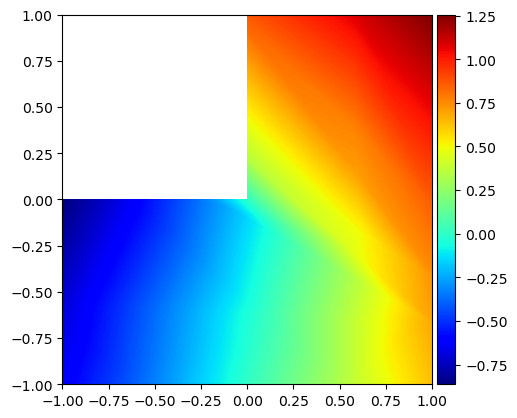

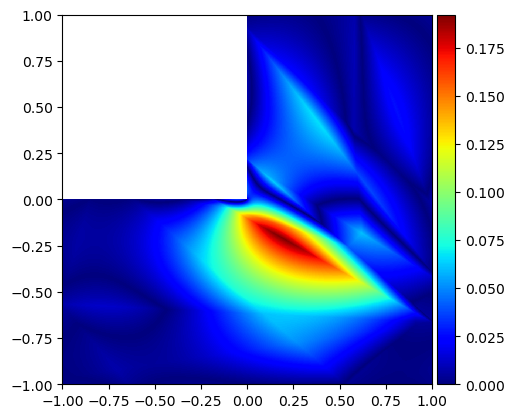

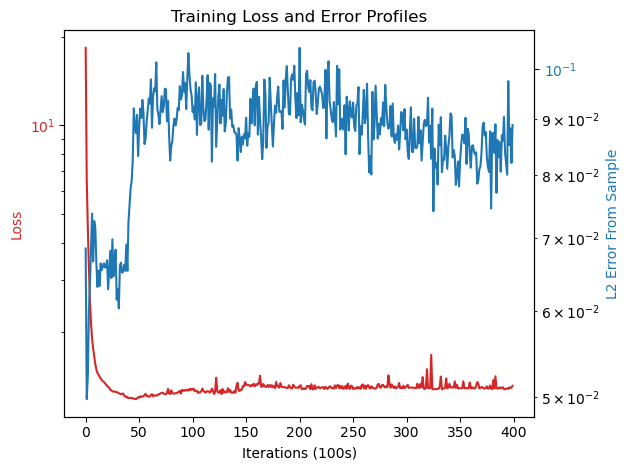

In [48]:
main(domain='l_shape_reg', density=19, arch='srnn_ReLU', epochs=40000, lr=3e-3, pretrain=0)

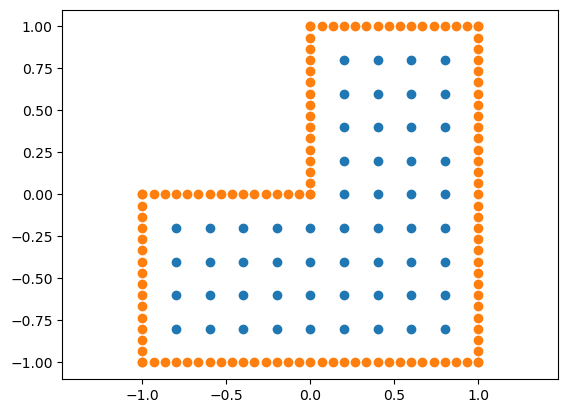

srnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 1623.6766357421875 loss_r: 0.03880981355905533 loss_b: 1623.6378173828125
Interior L2 error: 0.8762922883033752
Boundary L2 error: 1.766298532485962


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 10.752554893493652 loss_r: 0.99411940574646 loss_b: 9.758435249328613
Interior L2 error: 0.09283801168203354
Boundary L2 error: 0.13652995228767395
epoch: 200 loss: 2.1308975219726562 loss_r: 1.0593843460083008 loss_b: 1.071513295173645
Interior L2 error: 0.08159754425287247
Boundary L2 error: 0.04619807004928589
epoch: 300 loss: 1.9025771617889404 loss_r: 1.0671577453613281 loss_b: 0.8354193568229675
Interior L2 error: 0.08314091712236404
Boundary L2 error: 0.04083670303225517
epoch: 400 loss: 1.7997596263885498 loss_r: 1.0902891159057617 loss_b: 0.7094705700874329
Interior L2 error: 0.08162973076105118
Boundary L2 error: 0.03764079883694649
epoch: 500 loss: 1.703312635421753 loss_r: 1.1086890697479248 loss_b: 0.5946235656738281
Interior L2 error: 0.08086825907230377
Boundary L2 error: 0.03446100279688835
epoch: 600 loss: 1.6385711431503296 loss_r: 1.1228779554367065 loss_b: 0.515693187713623
Interior L2 error: 0.08115484565496445
Boundary L2 error: 0.0320902839303016

epoch: 5000 loss: 1.4440886974334717 loss_r: 1.1653220653533936 loss_b: 0.27876660227775574
Interior L2 error: 0.16278991103172302
Boundary L2 error: 0.023684214800596237
best epoch: 4600 best loss: 1.399429440498352 L2 error: 0.14758124947547913
load from ckpt!


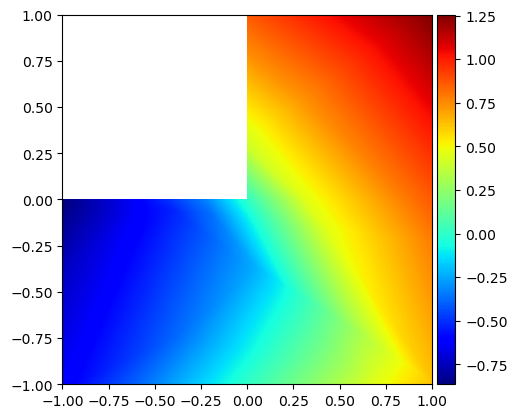

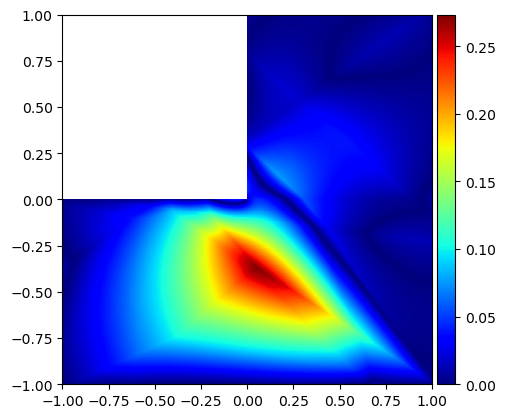

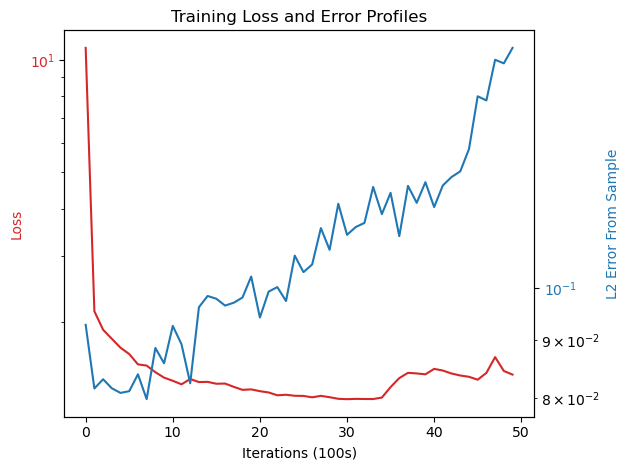

In [42]:
main(domain='l_shape_reg', density=6, arch='srnn_ReLU', epochs=5000, lr=3e-3, pretrain=0)

### Shallow NN, Tanh Activation

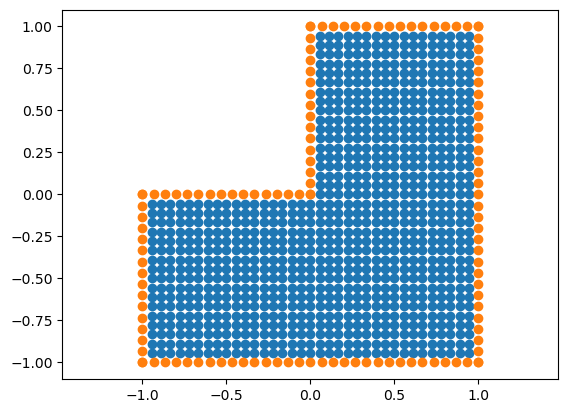

srnn_Tanh


IntProgress(value=0, max=400)

epoch: 0 loss: 771.4241943359375 loss_r: 0.4580226540565491 loss_b: 770.9661865234375
Interior L2 error: 0.5219635367393494
Boundary L2 error: 1.1465306282043457


/tmp/ipykernel_184/1348577284.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_184/1348577284.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_184/1348577284.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 70.74239349365234 loss_r: 1.0843050479888916 loss_b: 69.65808868408203
Interior L2 error: 0.17449010908603668
Boundary L2 error: 0.37188372015953064
epoch: 200 loss: 22.343103408813477 loss_r: 1.033319354057312 loss_b: 21.309783935546875
Interior L2 error: 0.12417539209127426
Boundary L2 error: 0.20489656925201416
epoch: 300 loss: 7.806066036224365 loss_r: 1.0706933736801147 loss_b: 6.735372543334961
Interior L2 error: 0.11926177889108658
Boundary L2 error: 0.1157676950097084
epoch: 400 loss: 6.2816057205200195 loss_r: 1.0912792682647705 loss_b: 5.190326690673828
Interior L2 error: 0.12152286618947983
Boundary L2 error: 0.10179991275072098
epoch: 500 loss: 5.583584308624268 loss_r: 1.0988779067993164 loss_b: 4.484706401824951
Interior L2 error: 0.1287430077791214
Boundary L2 error: 0.09464722871780396
epoch: 600 loss: 5.124302864074707 loss_r: 1.1048471927642822 loss_b: 4.019455432891846
Interior L2 error: 0.13280409574508667
Boundary L2 error: 0.08961792290210724
epoc

epoch: 5000 loss: 1.228904128074646 loss_r: 1.0501718521118164 loss_b: 0.17873229086399078
Interior L2 error: 0.10850215703248978
Boundary L2 error: 0.01890210248529911
epoch: 5100 loss: 1.2148618698120117 loss_r: 1.0441334247589111 loss_b: 0.17072850465774536
Interior L2 error: 0.08835013955831528
Boundary L2 error: 0.01847452111542225
epoch: 5200 loss: 1.2019115686416626 loss_r: 1.0379252433776855 loss_b: 0.16398636996746063
Interior L2 error: 0.08706724643707275
Boundary L2 error: 0.018097028136253357
epoch: 5300 loss: 1.1895244121551514 loss_r: 1.0319337844848633 loss_b: 0.15759064257144928
Interior L2 error: 0.08281239867210388
Boundary L2 error: 0.017750253900885582
epoch: 5400 loss: 1.185390591621399 loss_r: 1.0261898040771484 loss_b: 0.15920083224773407
Interior L2 error: 0.07815221697092056
Boundary L2 error: 0.018030304461717606
epoch: 5500 loss: 1.169836163520813 loss_r: 1.0215480327606201 loss_b: 0.14828816056251526
Interior L2 error: 0.08556990325450897
Boundary L2 error: 

epoch: 9900 loss: 0.9890320897102356 loss_r: 0.9615688920021057 loss_b: 0.027463218197226524
Interior L2 error: 0.034602582454681396
Boundary L2 error: 0.007454726845026016
epoch: 10000 loss: 0.9873981475830078 loss_r: 0.9610161781311035 loss_b: 0.02638196013867855
Interior L2 error: 0.03806446120142937
Boundary L2 error: 0.007251589559018612
epoch: 10100 loss: 0.9860279560089111 loss_r: 0.9603527784347534 loss_b: 0.02567518875002861
Interior L2 error: 0.03634011000394821
Boundary L2 error: 0.007135096937417984
epoch: 10200 loss: 0.9853330850601196 loss_r: 0.9587582945823669 loss_b: 0.026574769988656044
Interior L2 error: 0.034034427255392075
Boundary L2 error: 0.007449453230947256
epoch: 10300 loss: 0.9833035469055176 loss_r: 0.959023118019104 loss_b: 0.024280419573187828
Interior L2 error: 0.03552938625216484
Boundary L2 error: 0.006969554349780083
epoch: 10400 loss: 0.984596312046051 loss_r: 0.9592767953872681 loss_b: 0.0253195371478796
Interior L2 error: 0.0350479781627655
Boundary

epoch: 14700 loss: 0.9662315249443054 loss_r: 0.9374881982803345 loss_b: 0.028743334114551544
Interior L2 error: 0.019811823964118958
Boundary L2 error: 0.007297317031770945
epoch: 14800 loss: 0.9462437629699707 loss_r: 0.9379352331161499 loss_b: 0.008308528922498226
Interior L2 error: 0.02233072556555271
Boundary L2 error: 0.004114508628845215
epoch: 14900 loss: 0.9461039900779724 loss_r: 0.9373975396156311 loss_b: 0.00870646070688963
Interior L2 error: 0.02378847450017929
Boundary L2 error: 0.004021131433546543
epoch: 15000 loss: 0.9457865357398987 loss_r: 0.9374940991401672 loss_b: 0.008292446844279766
Interior L2 error: 0.020746005699038506
Boundary L2 error: 0.0040372577495872974
epoch: 15100 loss: 0.9505724310874939 loss_r: 0.9347598552703857 loss_b: 0.015812555328011513
Interior L2 error: 0.020455079153180122
Boundary L2 error: 0.004644022788852453
epoch: 15200 loss: 0.9498677253723145 loss_r: 0.9359731078147888 loss_b: 0.013894632458686829
Interior L2 error: 0.02430849894881248

epoch: 19500 loss: 0.9435681104660034 loss_r: 0.9310860633850098 loss_b: 0.012482039630413055
Interior L2 error: 0.019642364233732224
Boundary L2 error: 0.003641711315140128
epoch: 19600 loss: 0.9379422068595886 loss_r: 0.9329578876495361 loss_b: 0.00498434342443943
Interior L2 error: 0.020346255972981453
Boundary L2 error: 0.0031774479430168867
epoch: 19700 loss: 0.9379786252975464 loss_r: 0.9330906271934509 loss_b: 0.00488799624145031
Interior L2 error: 0.018075644969940186
Boundary L2 error: 0.00328941666521132
epoch: 19800 loss: 0.9376890063285828 loss_r: 0.9327259063720703 loss_b: 0.004963102284818888
Interior L2 error: 0.02005882002413273
Boundary L2 error: 0.0031198703218251467
epoch: 19900 loss: 0.941631019115448 loss_r: 0.9304479360580444 loss_b: 0.011183070950210094
Interior L2 error: 0.01936948485672474
Boundary L2 error: 0.003018902847543359
epoch: 20000 loss: 0.937653124332428 loss_r: 0.9327923059463501 loss_b: 0.00486084446310997
Interior L2 error: 0.020362408831715584
Bo

epoch: 24300 loss: 0.946196436882019 loss_r: 0.924454927444458 loss_b: 0.021741509437561035
Interior L2 error: 0.014630615711212158
Boundary L2 error: 0.005861702375113964
epoch: 24400 loss: 0.9431735277175903 loss_r: 0.9251905679702759 loss_b: 0.01798296347260475
Interior L2 error: 0.01581248641014099
Boundary L2 error: 0.0028807874768972397
epoch: 24500 loss: 0.932612955570221 loss_r: 0.9286746978759766 loss_b: 0.003938238136470318
Interior L2 error: 0.01798117533326149
Boundary L2 error: 0.0027308319695293903
epoch: 24600 loss: 0.9325955510139465 loss_r: 0.9286878108978271 loss_b: 0.003907742444425821
Interior L2 error: 0.015018267557024956
Boundary L2 error: 0.0027633868157863617
epoch: 24700 loss: 0.932434618473053 loss_r: 0.9285483956336975 loss_b: 0.003886218648403883
Interior L2 error: 0.01671569235622883
Boundary L2 error: 0.0027578333392739296
epoch: 24800 loss: 0.9353150129318237 loss_r: 0.9289044141769409 loss_b: 0.006410621106624603
Interior L2 error: 0.01649685949087143
B

epoch: 29100 loss: 1.00522780418396 loss_r: 0.9359928369522095 loss_b: 0.06923498958349228
Interior L2 error: 0.020313158631324768
Boundary L2 error: 0.013742132112383842
epoch: 29200 loss: 0.9286801815032959 loss_r: 0.9255110025405884 loss_b: 0.003169191535562277
Interior L2 error: 0.014923672191798687
Boundary L2 error: 0.0025527747347950935
epoch: 29300 loss: 0.9294723272323608 loss_r: 0.926296591758728 loss_b: 0.0031757366377860308
Interior L2 error: 0.014523112215101719
Boundary L2 error: 0.002805307973176241
epoch: 29400 loss: 0.9365447759628296 loss_r: 0.9240286350250244 loss_b: 0.012516112066805363
Interior L2 error: 0.015058869495987892
Boundary L2 error: 0.00587801169604063
epoch: 29500 loss: 0.9284398555755615 loss_r: 0.9251881837844849 loss_b: 0.003251686692237854
Interior L2 error: 0.015673909336328506
Boundary L2 error: 0.0024844727013260126
epoch: 29600 loss: 0.9283708333969116 loss_r: 0.9251338243484497 loss_b: 0.00323700625449419
Interior L2 error: 0.015524223446846008

epoch: 33900 loss: 0.9305245280265808 loss_r: 0.9231420755386353 loss_b: 0.007382425479590893
Interior L2 error: 0.014861668460071087
Boundary L2 error: 0.003353949636220932
epoch: 34000 loss: 0.9634848833084106 loss_r: 0.9164646863937378 loss_b: 0.04702017083764076
Interior L2 error: 0.013081937097012997
Boundary L2 error: 0.009764565154910088
epoch: 34100 loss: 0.9255776405334473 loss_r: 0.9227691888809204 loss_b: 0.0028084730729460716
Interior L2 error: 0.014136740937829018
Boundary L2 error: 0.0024546876084059477
epoch: 34200 loss: 0.9266242980957031 loss_r: 0.921319842338562 loss_b: 0.005304473917931318
Interior L2 error: 0.014668804593384266
Boundary L2 error: 0.002381771570071578
epoch: 34300 loss: 0.9256449937820435 loss_r: 0.9227709174156189 loss_b: 0.0028740791603922844
Interior L2 error: 0.015962043777108192
Boundary L2 error: 0.002552821533754468
epoch: 34400 loss: 0.9660497307777405 loss_r: 0.9154720902442932 loss_b: 0.05057763680815697
Interior L2 error: 0.013228359632194

epoch: 38600 loss: 0.9243638515472412 loss_r: 0.9213131666183472 loss_b: 0.003050674218684435
Interior L2 error: 0.015040065161883831
Boundary L2 error: 0.002448755782097578
epoch: 38700 loss: 0.9243091940879822 loss_r: 0.9221946001052856 loss_b: 0.0021146207582205534
Interior L2 error: 0.015121102333068848
Boundary L2 error: 0.002654618350788951
epoch: 38800 loss: 0.9241776466369629 loss_r: 0.9209228754043579 loss_b: 0.0032547498121857643
Interior L2 error: 0.014509614557027817
Boundary L2 error: 0.0024242736399173737
epoch: 38900 loss: 0.9239537119865417 loss_r: 0.9201330542564392 loss_b: 0.003820654470473528
Interior L2 error: 0.014723183587193489
Boundary L2 error: 0.002027201233431697
epoch: 39000 loss: 0.9236427545547485 loss_r: 0.921451210975647 loss_b: 0.0021915172692388296
Interior L2 error: 0.013483197428286076
Boundary L2 error: 0.00244219065643847
epoch: 39100 loss: 0.9233770370483398 loss_r: 0.9212241768836975 loss_b: 0.0021528617944568396
Interior L2 error: 0.014812456443

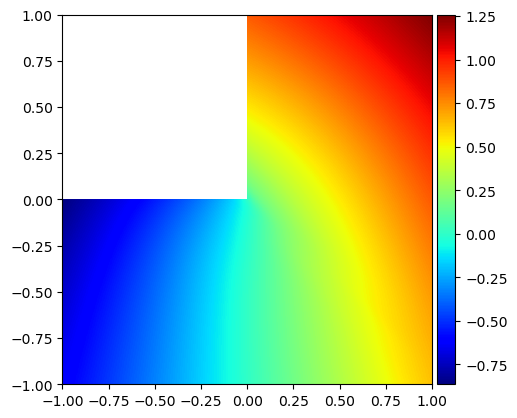

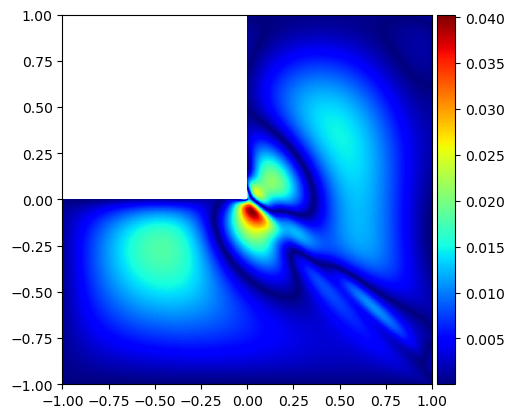

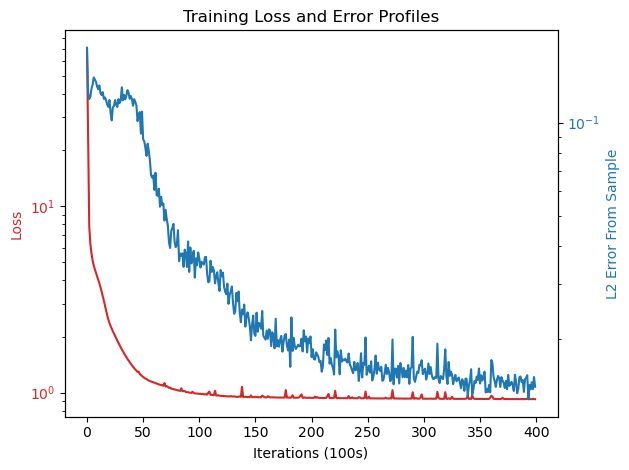

In [136]:
main(domain='l_shape_reg', density=19, arch='srnn_Tanh', epochs=40000, lr=3e-3, pretrain=0)

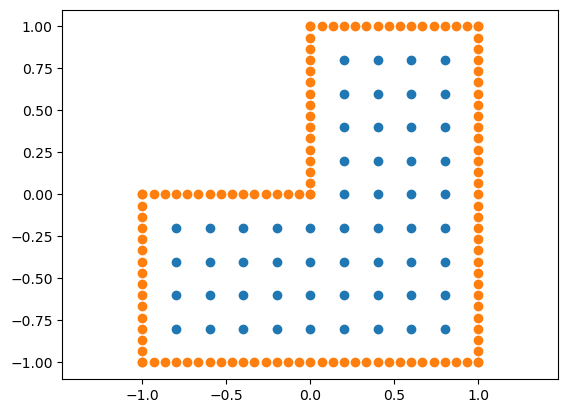

srnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 3335.35546875 loss_r: 0.10439433157444 loss_b: 3335.2509765625
Interior L2 error: 1.2471410036087036
Boundary L2 error: 2.498810291290283


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 86.01477813720703 loss_r: 1.0714809894561768 loss_b: 84.94329833984375
Interior L2 error: 0.1617046594619751
Boundary L2 error: 0.4112294018268585
epoch: 200 loss: 42.18121337890625 loss_r: 1.059693455696106 loss_b: 41.12152099609375
Interior L2 error: 0.11883705854415894
Boundary L2 error: 0.28521838784217834
epoch: 300 loss: 13.196219444274902 loss_r: 1.074341058731079 loss_b: 12.121878623962402
Interior L2 error: 0.1069178357720375
Boundary L2 error: 0.15495407581329346
epoch: 400 loss: 8.259190559387207 loss_r: 1.0923480987548828 loss_b: 7.166842460632324
Interior L2 error: 0.1149824932217598
Boundary L2 error: 0.11958586424589157
epoch: 500 loss: 7.346466064453125 loss_r: 1.0938866138458252 loss_b: 6.252579212188721
Interior L2 error: 0.11650017648935318
Boundary L2 error: 0.11177827417850494
epoch: 600 loss: 6.894522666931152 loss_r: 1.089646577835083 loss_b: 5.80487585067749
Interior L2 error: 0.11712878942489624
Boundary L2 error: 0.10771151632070541
epoch: 700

epoch: 5000 loss: 1.5366055965423584 loss_r: 1.0281116962432861 loss_b: 0.5084938406944275
Interior L2 error: 0.07844755798578262
Boundary L2 error: 0.031881168484687805
best epoch: 5000 best loss: 1.5366055965423584 L2 error: 0.07844755798578262
load from ckpt!


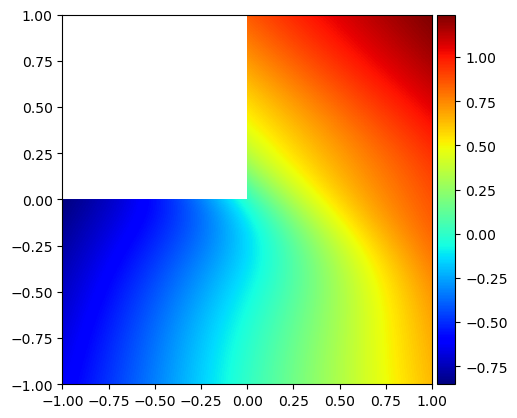

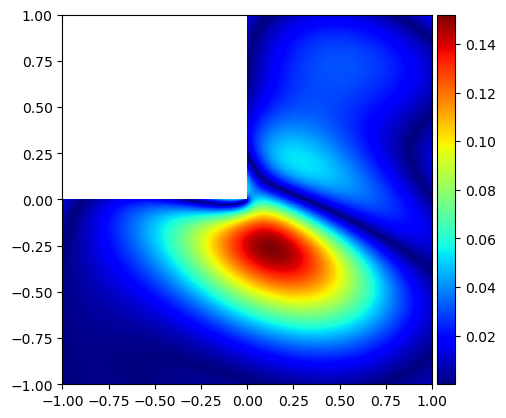

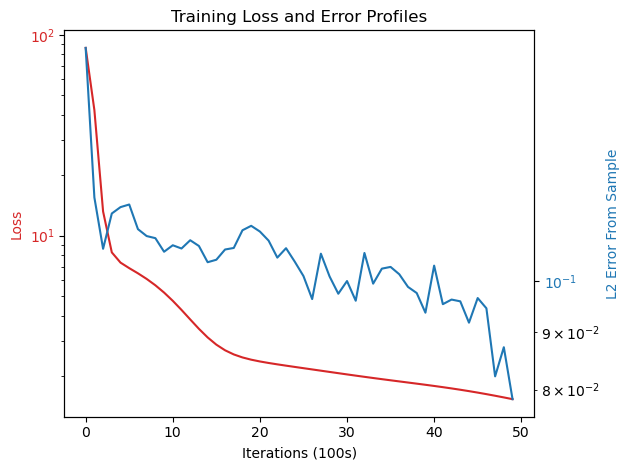

In [43]:
main(domain='l_shape_reg', density=6, arch='srnn_Tanh', epochs=5000, lr=3e-3, pretrain=0)

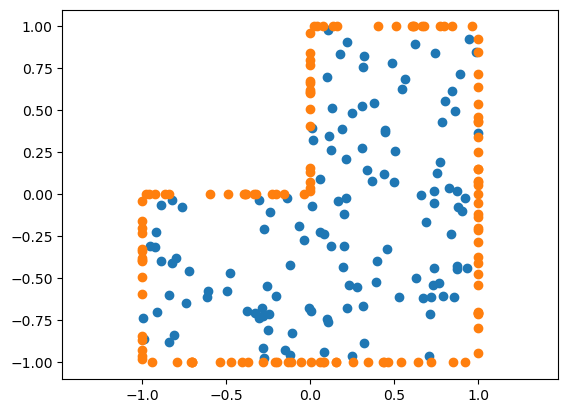

srnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 381.76214599609375 loss_r: 0.6371027231216431 loss_b: 381.1250305175781
Interior L2 error: 0.36928102374076843
Boundary L2 error: 0.8082672953605652


/tmp/ipykernel_190/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_190/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_190/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 78.93013000488281 loss_r: 0.9418110251426697 loss_b: 77.98831939697266
Interior L2 error: 0.19945771992206573
Boundary L2 error: 0.39771395921707153
epoch: 200 loss: 15.283636093139648 loss_r: 1.0044759511947632 loss_b: 14.279160499572754
Interior L2 error: 0.127344012260437
Boundary L2 error: 0.16762828826904297
epoch: 300 loss: 6.3404436111450195 loss_r: 1.0616223812103271 loss_b: 5.278820991516113
Interior L2 error: 0.12190695852041245
Boundary L2 error: 0.09942816942930222
epoch: 400 loss: 4.761753559112549 loss_r: 1.025748372077942 loss_b: 3.7360050678253174
Interior L2 error: 0.11250156909227371
Boundary L2 error: 0.09813809394836426
epoch: 500 loss: 4.979200839996338 loss_r: 1.0268522500991821 loss_b: 3.9523487091064453
Interior L2 error: 0.12464874237775803
Boundary L2 error: 0.08951001614332199
epoch: 600 loss: 4.7397589683532715 loss_r: 1.0467840433120728 loss_b: 3.6929750442504883
Interior L2 error: 0.1290518343448639
Boundary L2 error: 0.08550996333360672
e

epoch: 5000 loss: 1.190950632095337 loss_r: 1.0563573837280273 loss_b: 0.13459323346614838
Interior L2 error: 0.061065830290317535
Boundary L2 error: 0.014431813731789589
best epoch: 4700 best loss: 0.9634572863578796 L2 error: 0.06759744137525558
load from ckpt!


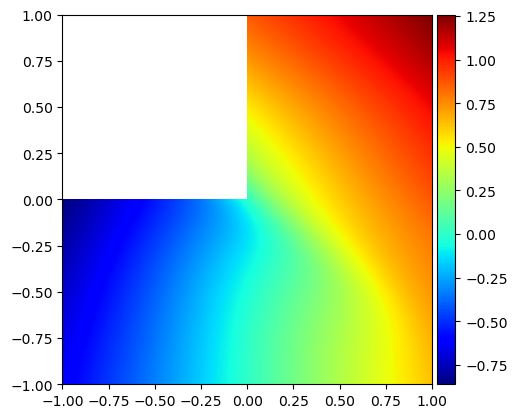

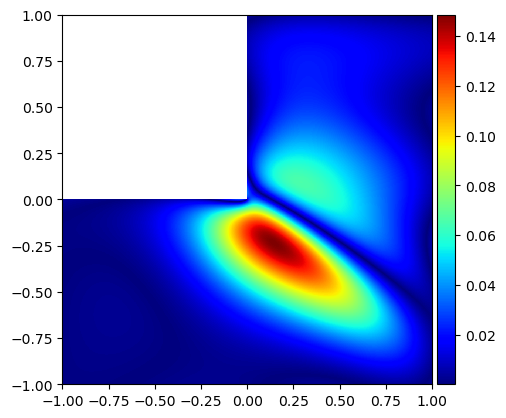

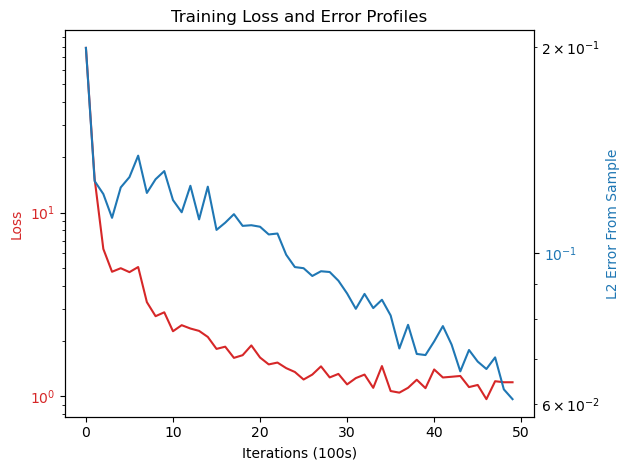

In [26]:
main(domain='l_shape', arch='srnn_Tanh', epochs=5000, lr=3e-3, pretrain=0)

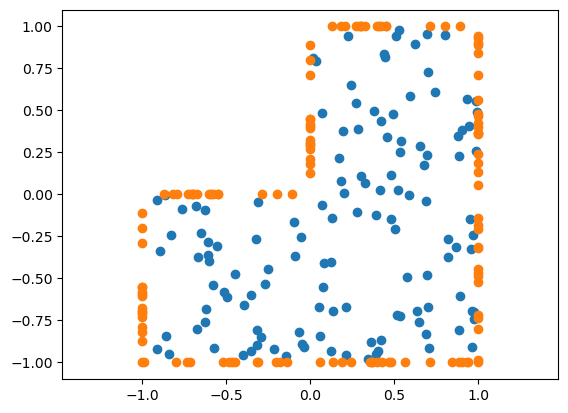

srnn_Tanh


IntProgress(value=0, max=200)

epoch: 0 loss: 2845.031982421875 loss_r: 0.3974617123603821 loss_b: 2844.634521484375
Interior L2 error: 1.1473530530929565
Boundary L2 error: 2.2198338508605957


/tmp/ipykernel_190/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_190/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_190/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 78.03517150878906 loss_r: 1.0524613857269287 loss_b: 76.98271179199219
Interior L2 error: 0.16187652945518494
Boundary L2 error: 0.3944892883300781
epoch: 200 loss: 30.417566299438477 loss_r: 1.0912590026855469 loss_b: 29.32630729675293
Interior L2 error: 0.10639101266860962
Boundary L2 error: 0.23513899743556976
epoch: 300 loss: 11.871138572692871 loss_r: 1.0850934982299805 loss_b: 10.78604507446289
Interior L2 error: 0.1007307916879654
Boundary L2 error: 0.14524884521961212
epoch: 400 loss: 9.96033763885498 loss_r: 0.9950013756752014 loss_b: 8.965335845947266
Interior L2 error: 0.10466062277555466
Boundary L2 error: 0.13105548918247223
epoch: 500 loss: 7.370689392089844 loss_r: 1.0134518146514893 loss_b: 6.357237339019775
Interior L2 error: 0.10501761734485626
Boundary L2 error: 0.12481065094470978
epoch: 600 loss: 7.576229572296143 loss_r: 1.0354920625686646 loss_b: 6.540737628936768
Interior L2 error: 0.10169825702905655
Boundary L2 error: 0.11770402640104294
epoch

epoch: 5000 loss: 1.6321171522140503 loss_r: 1.0293591022491455 loss_b: 0.6027580499649048
Interior L2 error: 0.0891096219420433
Boundary L2 error: 0.03058617375791073
epoch: 5100 loss: 1.5516035556793213 loss_r: 0.9987947344779968 loss_b: 0.5528088212013245
Interior L2 error: 0.09572075307369232
Boundary L2 error: 0.030804326757788658
epoch: 5200 loss: 1.3837754726409912 loss_r: 0.9288954734802246 loss_b: 0.4548800587654114
Interior L2 error: 0.09040974080562592
Boundary L2 error: 0.030258391052484512
epoch: 5300 loss: 1.5975797176361084 loss_r: 1.0649863481521606 loss_b: 0.532593309879303
Interior L2 error: 0.08004242926836014
Boundary L2 error: 0.034513555467128754
epoch: 5400 loss: 1.5328541994094849 loss_r: 0.9849877953529358 loss_b: 0.5478664040565491
Interior L2 error: 0.08856827765703201
Boundary L2 error: 0.033297810703516006
epoch: 5500 loss: 1.3389766216278076 loss_r: 0.9111267328262329 loss_b: 0.42784982919692993
Interior L2 error: 0.07769772410392761
Boundary L2 error: 0.0

epoch: 9900 loss: 1.098021149635315 loss_r: 0.9841103553771973 loss_b: 0.11391083896160126
Interior L2 error: 0.03434843569993973
Boundary L2 error: 0.017644179984927177
epoch: 10000 loss: 0.9559708833694458 loss_r: 0.82546067237854 loss_b: 0.13051018118858337
Interior L2 error: 0.03619192913174629
Boundary L2 error: 0.015774711966514587
epoch: 10100 loss: 1.1648273468017578 loss_r: 1.0447596311569214 loss_b: 0.12006767839193344
Interior L2 error: 0.03980119898915291
Boundary L2 error: 0.01710955984890461
epoch: 10200 loss: 1.1373965740203857 loss_r: 0.969452440738678 loss_b: 0.16794419288635254
Interior L2 error: 0.0401700958609581
Boundary L2 error: 0.01517817284911871
epoch: 10300 loss: 1.0588083267211914 loss_r: 0.8770045638084412 loss_b: 0.18180379271507263
Interior L2 error: 0.03784291073679924
Boundary L2 error: 0.015007676556706429
epoch: 10400 loss: 1.111964225769043 loss_r: 0.9601051807403564 loss_b: 0.15185898542404175
Interior L2 error: 0.039388928562402725
Boundary L2 erro

epoch: 14700 loss: 1.0220458507537842 loss_r: 0.934967041015625 loss_b: 0.0870787501335144
Interior L2 error: 0.029894908890128136
Boundary L2 error: 0.015294610522687435
epoch: 14800 loss: 1.100291132926941 loss_r: 0.9491628408432007 loss_b: 0.15112832188606262
Interior L2 error: 0.027765629813075066
Boundary L2 error: 0.011822840198874474
epoch: 14900 loss: 1.0301241874694824 loss_r: 0.9180253744125366 loss_b: 0.11209879070520401
Interior L2 error: 0.027298154309391975
Boundary L2 error: 0.011006520129740238
epoch: 15000 loss: 1.1102895736694336 loss_r: 1.0195808410644531 loss_b: 0.0907086730003357
Interior L2 error: 0.028230415657162666
Boundary L2 error: 0.009867394343018532
epoch: 15100 loss: 1.0272623300552368 loss_r: 0.9682604670524597 loss_b: 0.05900188907980919
Interior L2 error: 0.025748349726200104
Boundary L2 error: 0.011595062911510468
epoch: 15200 loss: 1.191827654838562 loss_r: 1.0320942401885986 loss_b: 0.1597333699464798
Interior L2 error: 0.029504122212529182
Boundary

epoch: 19500 loss: 1.0519590377807617 loss_r: 0.9756571054458618 loss_b: 0.07630196958780289
Interior L2 error: 0.0220757108181715
Boundary L2 error: 0.007609810680150986
epoch: 19600 loss: 1.0605034828186035 loss_r: 0.9545966386795044 loss_b: 0.10590678453445435
Interior L2 error: 0.02191285975277424
Boundary L2 error: 0.007491400931030512
epoch: 19700 loss: 1.0020742416381836 loss_r: 0.9365794658660889 loss_b: 0.06549480557441711
Interior L2 error: 0.022624554112553596
Boundary L2 error: 0.008609502576291561
epoch: 19800 loss: 1.0111074447631836 loss_r: 0.9403417110443115 loss_b: 0.07076575607061386
Interior L2 error: 0.0218352060765028
Boundary L2 error: 0.006650606170296669
epoch: 19900 loss: 0.9628369808197021 loss_r: 0.8728027939796448 loss_b: 0.09003417938947678
Interior L2 error: 0.020726278424263
Boundary L2 error: 0.00799503829330206
epoch: 20000 loss: 1.2065486907958984 loss_r: 1.100786805152893 loss_b: 0.10576185584068298
Interior L2 error: 0.01868295483291149
Boundary L2 e

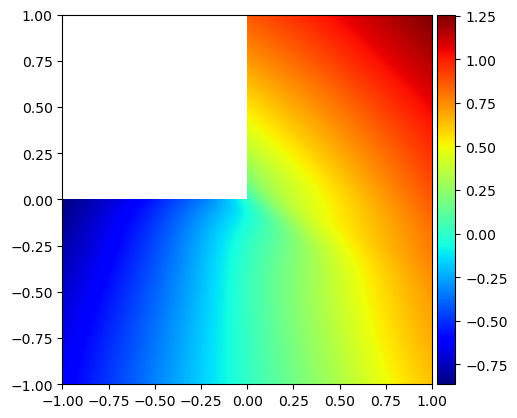

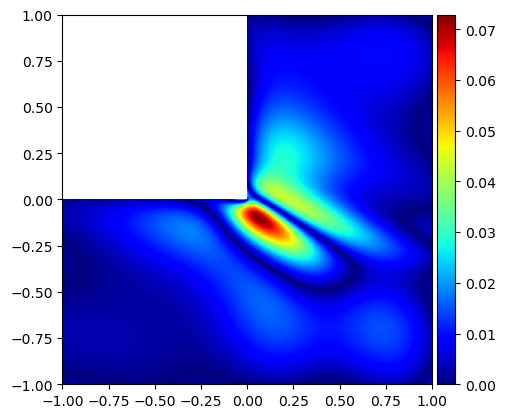

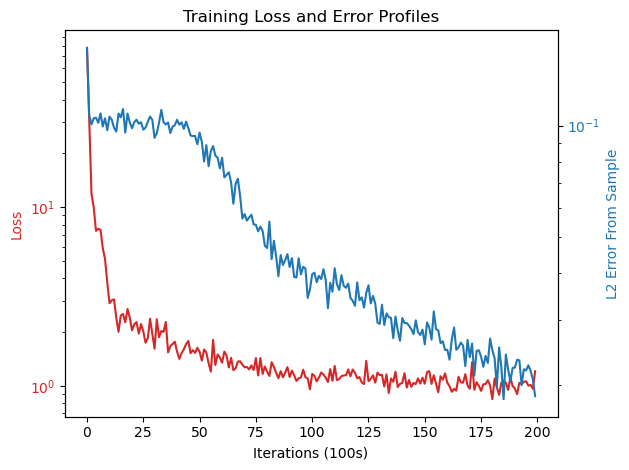

In [27]:
main(domain='l_shape', arch='srnn_Tanh', epochs=20000, lr=3e-3, pretrain=0)

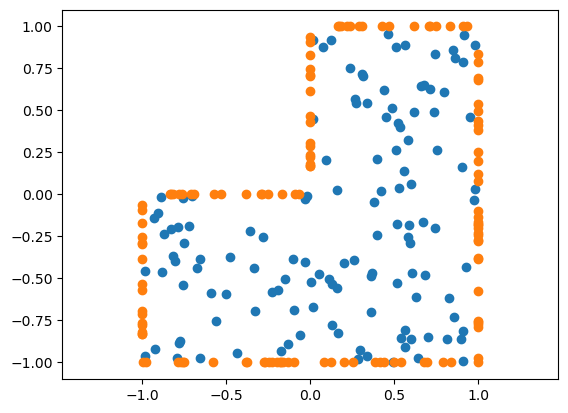

srnn_Tanh


IntProgress(value=0, max=400)

epoch: 0 loss: 3543.68994140625 loss_r: 0.1879018396139145 loss_b: 3543.501953125
Interior L2 error: 1.2902179956436157
Boundary L2 error: 2.5628349781036377


/tmp/ipykernel_190/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_190/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_190/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 42.17819595336914 loss_r: 0.9780362844467163 loss_b: 41.20016098022461
Interior L2 error: 0.09540172666311264
Boundary L2 error: 0.27340373396873474
epoch: 200 loss: 20.803281784057617 loss_r: 1.0167256593704224 loss_b: 19.786556243896484
Interior L2 error: 0.07272060960531235
Boundary L2 error: 0.20592743158340454
epoch: 300 loss: 15.167752265930176 loss_r: 1.0212939977645874 loss_b: 14.146458625793457
Interior L2 error: 0.06736583262681961
Boundary L2 error: 0.16971170902252197
epoch: 400 loss: 10.24743938446045 loss_r: 1.0608114004135132 loss_b: 9.186628341674805
Interior L2 error: 0.0698232352733612
Boundary L2 error: 0.14317378401756287
epoch: 500 loss: 9.094035148620605 loss_r: 1.085347294807434 loss_b: 8.008687973022461
Interior L2 error: 0.07555896043777466
Boundary L2 error: 0.13081040978431702
epoch: 600 loss: 9.542952537536621 loss_r: 1.0955573320388794 loss_b: 8.447395324707031
Interior L2 error: 0.08991328626871109
Boundary L2 error: 0.12384705990552902
ep

epoch: 5000 loss: 1.6807043552398682 loss_r: 1.0539891719818115 loss_b: 0.6267151236534119
Interior L2 error: 0.08433262258768082
Boundary L2 error: 0.04075470194220543
epoch: 5100 loss: 1.5503653287887573 loss_r: 0.9102900624275208 loss_b: 0.6400752663612366
Interior L2 error: 0.08569185435771942
Boundary L2 error: 0.037563249468803406
epoch: 5200 loss: 1.900301456451416 loss_r: 0.9935487508773804 loss_b: 0.9067527651786804
Interior L2 error: 0.08525730669498444
Boundary L2 error: 0.035094402730464935
epoch: 5300 loss: 1.6918113231658936 loss_r: 1.0105035305023193 loss_b: 0.6813077926635742
Interior L2 error: 0.09426143020391464
Boundary L2 error: 0.03563749045133591
epoch: 5400 loss: 1.4886469841003418 loss_r: 0.9244054555892944 loss_b: 0.5642415285110474
Interior L2 error: 0.08163120597600937
Boundary L2 error: 0.03236467391252518
epoch: 5500 loss: 1.5921051502227783 loss_r: 0.9348889589309692 loss_b: 0.6572162508964539
Interior L2 error: 0.0810103565454483
Boundary L2 error: 0.0321

epoch: 9900 loss: 1.1712477207183838 loss_r: 1.000206708908081 loss_b: 0.17104099690914154
Interior L2 error: 0.053179237991571426
Boundary L2 error: 0.014059112407267094
epoch: 10000 loss: 1.25401771068573 loss_r: 1.100329875946045 loss_b: 0.15368784964084625
Interior L2 error: 0.052238356322050095
Boundary L2 error: 0.01523535791784525
epoch: 10100 loss: 0.9696263670921326 loss_r: 0.9269407987594604 loss_b: 0.042685553431510925
Interior L2 error: 0.05216936394572258
Boundary L2 error: 0.013766744174063206
epoch: 10200 loss: 1.123223900794983 loss_r: 0.9685972929000854 loss_b: 0.15462660789489746
Interior L2 error: 0.053413864225149155
Boundary L2 error: 0.013913511298596859
epoch: 10300 loss: 1.1033716201782227 loss_r: 0.9446058869361877 loss_b: 0.1587657481431961
Interior L2 error: 0.05180756002664566
Boundary L2 error: 0.012958959676325321
epoch: 10400 loss: 0.9938861727714539 loss_r: 0.9060786366462708 loss_b: 0.0878075510263443
Interior L2 error: 0.05000073462724686
Boundary L2 e

epoch: 14700 loss: 0.8740866184234619 loss_r: 0.8473404049873352 loss_b: 0.026746241375803947
Interior L2 error: 0.02100258879363537
Boundary L2 error: 0.009930728934705257
epoch: 14800 loss: 0.9667767286300659 loss_r: 0.9017632007598877 loss_b: 0.06501355022192001
Interior L2 error: 0.022655699402093887
Boundary L2 error: 0.007364205084741116
epoch: 14900 loss: 1.0058318376541138 loss_r: 0.9644234776496887 loss_b: 0.04140837490558624
Interior L2 error: 0.025513559579849243
Boundary L2 error: 0.01081699039787054
epoch: 15000 loss: 1.066240668296814 loss_r: 1.0432294607162476 loss_b: 0.02301122061908245
Interior L2 error: 0.02196974866092205
Boundary L2 error: 0.005264332052320242
epoch: 15100 loss: 0.9460585117340088 loss_r: 0.8871418833732605 loss_b: 0.05891665443778038
Interior L2 error: 0.02103590965270996
Boundary L2 error: 0.00919564813375473
epoch: 15200 loss: 1.008205771446228 loss_r: 0.9534709453582764 loss_b: 0.05473477393388748
Interior L2 error: 0.019984090700745583
Boundary

epoch: 19500 loss: 0.904947817325592 loss_r: 0.8631376028060913 loss_b: 0.04181022569537163
Interior L2 error: 0.018080320209264755
Boundary L2 error: 0.009607793763279915
epoch: 19600 loss: 1.0026721954345703 loss_r: 0.9809641242027283 loss_b: 0.021708091720938683
Interior L2 error: 0.019957082346081734
Boundary L2 error: 0.005253849551081657
epoch: 19700 loss: 0.9107617735862732 loss_r: 0.8927695155143738 loss_b: 0.017992231994867325
Interior L2 error: 0.016834553331136703
Boundary L2 error: 0.004413620103150606
epoch: 19800 loss: 0.9541537165641785 loss_r: 0.9341378211975098 loss_b: 0.02001587301492691
Interior L2 error: 0.0179862342774868
Boundary L2 error: 0.007047083228826523
epoch: 19900 loss: 0.9176724553108215 loss_r: 0.9015628695487976 loss_b: 0.016109589487314224
Interior L2 error: 0.017020169645547867
Boundary L2 error: 0.005456430371850729
epoch: 20000 loss: 0.9210885763168335 loss_r: 0.8677695393562317 loss_b: 0.053319014608860016
Interior L2 error: 0.020298397168517113
B

epoch: 24300 loss: 1.0002375841140747 loss_r: 0.9852142333984375 loss_b: 0.015023304149508476
Interior L2 error: 0.01683567278087139
Boundary L2 error: 0.004168706014752388
epoch: 24400 loss: 1.1108553409576416 loss_r: 1.0914509296417236 loss_b: 0.019404452294111252
Interior L2 error: 0.014974815770983696
Boundary L2 error: 0.007938873954117298
epoch: 24500 loss: 1.0687317848205566 loss_r: 1.025089144706726 loss_b: 0.043642692267894745
Interior L2 error: 0.01616095006465912
Boundary L2 error: 0.007768838666379452
epoch: 24600 loss: 0.9497008323669434 loss_r: 0.9324773550033569 loss_b: 0.01722348853945732
Interior L2 error: 0.015223034657537937
Boundary L2 error: 0.007748265750706196
epoch: 24700 loss: 0.8577384948730469 loss_r: 0.8212729096412659 loss_b: 0.0364655926823616
Interior L2 error: 0.016308618709445
Boundary L2 error: 0.004954297095537186
epoch: 24800 loss: 0.9167941808700562 loss_r: 0.8960167169570923 loss_b: 0.020777447149157524
Interior L2 error: 0.014596237801015377
Bound

epoch: 29100 loss: 1.0038026571273804 loss_r: 0.9952241778373718 loss_b: 0.008578428998589516
Interior L2 error: 0.01328976172953844
Boundary L2 error: 0.0058806464076042175
epoch: 29200 loss: 0.9503403902053833 loss_r: 0.9233008623123169 loss_b: 0.027039512991905212
Interior L2 error: 0.013166614808142185
Boundary L2 error: 0.005986385978758335
epoch: 29300 loss: 1.0610328912734985 loss_r: 1.0257312059402466 loss_b: 0.03530168905854225
Interior L2 error: 0.012575598433613777
Boundary L2 error: 0.005599702708423138
epoch: 29400 loss: 0.8370695114135742 loss_r: 0.8202219009399414 loss_b: 0.016847623512148857
Interior L2 error: 0.015171837992966175
Boundary L2 error: 0.00963289849460125
epoch: 29500 loss: 0.9606782793998718 loss_r: 0.9282944798469543 loss_b: 0.03238379582762718
Interior L2 error: 0.011434310115873814
Boundary L2 error: 0.005354651715606451
epoch: 29600 loss: 0.923291802406311 loss_r: 0.9091651439666748 loss_b: 0.01412663608789444
Interior L2 error: 0.013095207512378693
B

epoch: 33900 loss: 0.9385852813720703 loss_r: 0.9160759449005127 loss_b: 0.02250930666923523
Interior L2 error: 0.012402270920574665
Boundary L2 error: 0.004252270795404911
epoch: 34000 loss: 0.8964418172836304 loss_r: 0.8742358684539795 loss_b: 0.02220594696700573
Interior L2 error: 0.01431233435869217
Boundary L2 error: 0.008533556014299393
epoch: 34100 loss: 0.9728416800498962 loss_r: 0.9371429681777954 loss_b: 0.035698726773262024
Interior L2 error: 0.014382981695234776
Boundary L2 error: 0.007752014324069023
epoch: 34200 loss: 1.01547372341156 loss_r: 0.9677926898002625 loss_b: 0.047681063413619995
Interior L2 error: 0.012237495742738247
Boundary L2 error: 0.005936410278081894
epoch: 34300 loss: 0.9078684449195862 loss_r: 0.9000613689422607 loss_b: 0.007807072717696428
Interior L2 error: 0.013361507095396519
Boundary L2 error: 0.0038698737043887377
epoch: 34400 loss: 0.9124255180358887 loss_r: 0.8979541063308716 loss_b: 0.014471395872533321
Interior L2 error: 0.013773188926279545


epoch: 38700 loss: 0.8772722482681274 loss_r: 0.855591893196106 loss_b: 0.021680379286408424
Interior L2 error: 0.012596801854670048
Boundary L2 error: 0.004979499615728855
epoch: 38800 loss: 0.8912009000778198 loss_r: 0.8873974084854126 loss_b: 0.0038034911267459393
Interior L2 error: 0.0129399374127388
Boundary L2 error: 0.0035298073198646307
epoch: 38900 loss: 0.8786027431488037 loss_r: 0.871532678604126 loss_b: 0.007070042658597231
Interior L2 error: 0.011668521910905838
Boundary L2 error: 0.004985193256288767
epoch: 39000 loss: 0.864980936050415 loss_r: 0.8249752521514893 loss_b: 0.04000568017363548
Interior L2 error: 0.012104763649404049
Boundary L2 error: 0.0037703204434365034
epoch: 39100 loss: 0.9174754023551941 loss_r: 0.8978666067123413 loss_b: 0.019608767703175545
Interior L2 error: 0.012549900449812412
Boundary L2 error: 0.004180836491286755
epoch: 39200 loss: 0.9378742575645447 loss_r: 0.9275935292243958 loss_b: 0.01028070505708456
Interior L2 error: 0.012133938260376453


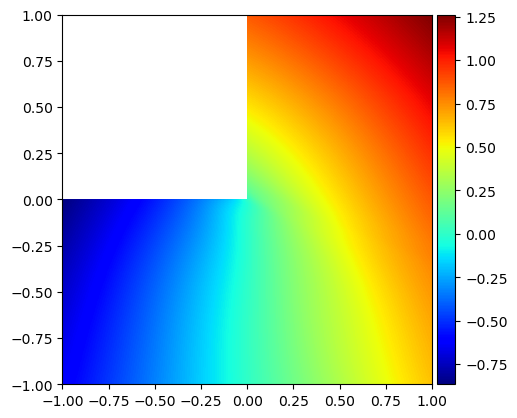

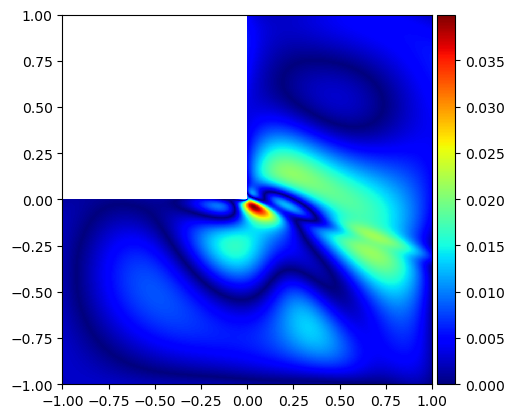

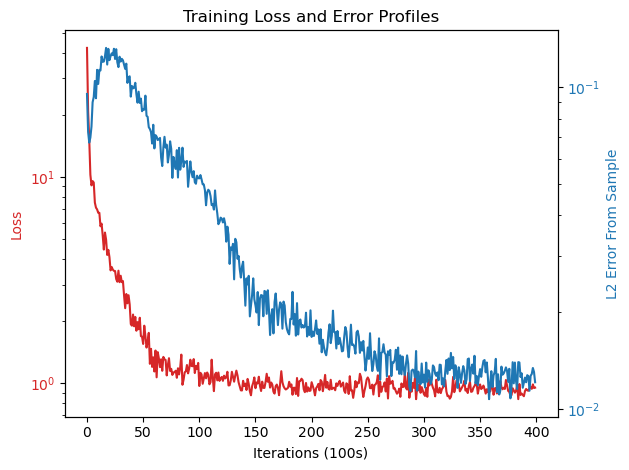

In [28]:
main(domain='l_shape', arch='srnn_Tanh', epochs=40000, lr=3e-3, pretrain=0)

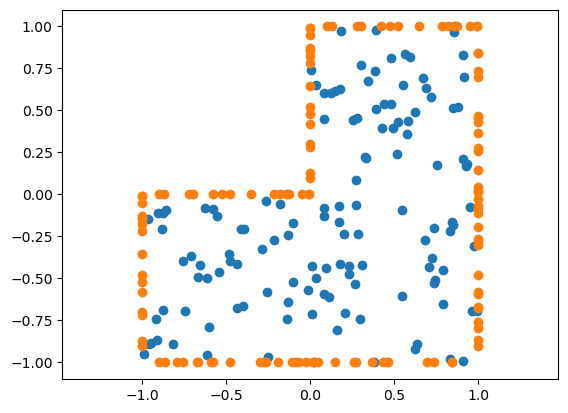

srnn_Tanh


IntProgress(value=0, max=600)

epoch: 0 loss: 2879.798583984375 loss_r: 0.6312992572784424 loss_b: 2879.167236328125
Interior L2 error: 1.152710199356079
Boundary L2 error: 2.27060604095459


/tmp/ipykernel_190/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_190/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_190/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 62.03935623168945 loss_r: 0.9994215965270996 loss_b: 61.03993606567383
Interior L2 error: 0.16685901582241058
Boundary L2 error: 0.35959649085998535
epoch: 200 loss: 30.457015991210938 loss_r: 1.0562944412231445 loss_b: 29.400720596313477
Interior L2 error: 0.11487136781215668
Boundary L2 error: 0.2288428544998169
epoch: 300 loss: 10.782435417175293 loss_r: 1.0197808742523193 loss_b: 9.762654304504395
Interior L2 error: 0.0974842831492424
Boundary L2 error: 0.1514616757631302
epoch: 400 loss: 6.9171977043151855 loss_r: 1.084320068359375 loss_b: 5.8328776359558105
Interior L2 error: 0.10435301810503006
Boundary L2 error: 0.1168065220117569
epoch: 500 loss: 5.776094913482666 loss_r: 1.0183097124099731 loss_b: 4.757785320281982
Interior L2 error: 0.10244230180978775
Boundary L2 error: 0.10225657373666763
epoch: 600 loss: 6.09912633895874 loss_r: 0.8266716003417969 loss_b: 5.272454738616943
Interior L2 error: 0.10671699792146683
Boundary L2 error: 0.09252262115478516
epoch

epoch: 5000 loss: 1.5819216966629028 loss_r: 0.9286424517631531 loss_b: 0.6532792448997498
Interior L2 error: 0.0923154205083847
Boundary L2 error: 0.03203055262565613
epoch: 5100 loss: 1.4118643999099731 loss_r: 1.0170683860778809 loss_b: 0.3947960436344147
Interior L2 error: 0.09139980375766754
Boundary L2 error: 0.030853809788823128
epoch: 5200 loss: 1.6485439538955688 loss_r: 1.1039644479751587 loss_b: 0.5445795059204102
Interior L2 error: 0.09140259772539139
Boundary L2 error: 0.02910837158560753
epoch: 5300 loss: 1.5828869342803955 loss_r: 1.0682300329208374 loss_b: 0.5146569013595581
Interior L2 error: 0.08097928017377853
Boundary L2 error: 0.028202347457408905
epoch: 5400 loss: 1.4428822994232178 loss_r: 0.9742096662521362 loss_b: 0.4686726927757263
Interior L2 error: 0.07717830687761307
Boundary L2 error: 0.02717014029622078
epoch: 5500 loss: 1.4741291999816895 loss_r: 1.010046362876892 loss_b: 0.464082807302475
Interior L2 error: 0.07788894325494766
Boundary L2 error: 0.02872

epoch: 9900 loss: 1.1328314542770386 loss_r: 1.0162240266799927 loss_b: 0.11660737544298172
Interior L2 error: 0.03962397202849388
Boundary L2 error: 0.014704239554703236
epoch: 10000 loss: 1.0318238735198975 loss_r: 0.9249091744422913 loss_b: 0.1069147139787674
Interior L2 error: 0.04273118078708649
Boundary L2 error: 0.016691816970705986
epoch: 10100 loss: 1.046764850616455 loss_r: 0.9925063848495483 loss_b: 0.05425843223929405
Interior L2 error: 0.0480625182390213
Boundary L2 error: 0.016668960452079773
epoch: 10200 loss: 1.2040246725082397 loss_r: 1.0626733303070068 loss_b: 0.1413513422012329
Interior L2 error: 0.042600929737091064
Boundary L2 error: 0.013748402707278728
epoch: 10300 loss: 1.09113347530365 loss_r: 0.973806619644165 loss_b: 0.11732685565948486
Interior L2 error: 0.04497791826725006
Boundary L2 error: 0.013914703391492367
epoch: 10400 loss: 1.0469613075256348 loss_r: 0.9645833373069763 loss_b: 0.08237796276807785
Interior L2 error: 0.05044788122177124
Boundary L2 err

epoch: 14700 loss: 1.0479334592819214 loss_r: 0.9993242025375366 loss_b: 0.04860920459032059
Interior L2 error: 0.03488893806934357
Boundary L2 error: 0.009533539414405823
epoch: 14800 loss: 1.0559182167053223 loss_r: 1.0231084823608398 loss_b: 0.032809700816869736
Interior L2 error: 0.034029122442007065
Boundary L2 error: 0.010689729824662209
epoch: 14900 loss: 1.1073750257492065 loss_r: 0.9986683130264282 loss_b: 0.1087067648768425
Interior L2 error: 0.04174341633915901
Boundary L2 error: 0.014250120148062706
epoch: 15000 loss: 1.0098199844360352 loss_r: 0.9370526075363159 loss_b: 0.07276740670204163
Interior L2 error: 0.033275313675403595
Boundary L2 error: 0.013535473495721817
epoch: 15100 loss: 0.9923924207687378 loss_r: 0.8829847574234009 loss_b: 0.10940767824649811
Interior L2 error: 0.039152663201093674
Boundary L2 error: 0.011536046862602234
epoch: 15200 loss: 1.044135570526123 loss_r: 0.9318522214889526 loss_b: 0.11228331923484802
Interior L2 error: 0.04123048856854439
Bounda

epoch: 19500 loss: 0.9117286205291748 loss_r: 0.876482367515564 loss_b: 0.035246267914772034
Interior L2 error: 0.032773859798908234
Boundary L2 error: 0.010384812019765377
epoch: 19600 loss: 0.8885689973831177 loss_r: 0.8494235873222351 loss_b: 0.03914541006088257
Interior L2 error: 0.03243616223335266
Boundary L2 error: 0.01024981215596199
epoch: 19700 loss: 1.0895787477493286 loss_r: 1.0516471862792969 loss_b: 0.03793160617351532
Interior L2 error: 0.029592717066407204
Boundary L2 error: 0.006575314793735743
epoch: 19800 loss: 1.0254021883010864 loss_r: 0.9871525764465332 loss_b: 0.03824959322810173
Interior L2 error: 0.03447658196091652
Boundary L2 error: 0.009843802079558372
epoch: 19900 loss: 1.1040592193603516 loss_r: 1.0700675249099731 loss_b: 0.033991649746894836
Interior L2 error: 0.030782364308834076
Boundary L2 error: 0.008666476234793663
epoch: 20000 loss: 1.005231261253357 loss_r: 0.9616590738296509 loss_b: 0.04357219487428665
Interior L2 error: 0.027847163379192352
Bound

epoch: 24300 loss: 0.9651943445205688 loss_r: 0.8995490074157715 loss_b: 0.06564530730247498
Interior L2 error: 0.026104889810085297
Boundary L2 error: 0.007772237528115511
epoch: 24400 loss: 1.018800139427185 loss_r: 0.9511672854423523 loss_b: 0.06763284653425217
Interior L2 error: 0.022343505173921585
Boundary L2 error: 0.005289776250720024
epoch: 24500 loss: 1.0270981788635254 loss_r: 1.006128191947937 loss_b: 0.020970022305846214
Interior L2 error: 0.025000538676977158
Boundary L2 error: 0.007668282836675644
epoch: 24600 loss: 0.9537999629974365 loss_r: 0.8796600103378296 loss_b: 0.07413995265960693
Interior L2 error: 0.02427777647972107
Boundary L2 error: 0.006739211268723011
epoch: 24700 loss: 0.9557174444198608 loss_r: 0.9282686710357666 loss_b: 0.027448745444417
Interior L2 error: 0.025673897936940193
Boundary L2 error: 0.008417882025241852
epoch: 24800 loss: 1.0925400257110596 loss_r: 1.0695698261260986 loss_b: 0.022970201447606087
Interior L2 error: 0.024736125022172928
Bound

epoch: 29100 loss: 0.9826552867889404 loss_r: 0.9546102285385132 loss_b: 0.028045063838362694
Interior L2 error: 0.019680678844451904
Boundary L2 error: 0.0051814233884215355
epoch: 29200 loss: 1.0279762744903564 loss_r: 0.9677407741546631 loss_b: 0.06023551523685455
Interior L2 error: 0.018109291791915894
Boundary L2 error: 0.010071158409118652
epoch: 29300 loss: 1.0396580696105957 loss_r: 1.009127140045166 loss_b: 0.03053087182343006
Interior L2 error: 0.019549664109945297
Boundary L2 error: 0.0040996382012963295
epoch: 29400 loss: 0.9298866391181946 loss_r: 0.8870653510093689 loss_b: 0.04282126575708389
Interior L2 error: 0.01985814981162548
Boundary L2 error: 0.004479160066694021
epoch: 29500 loss: 1.023587703704834 loss_r: 1.0070403814315796 loss_b: 0.016547294333577156
Interior L2 error: 0.019128484651446342
Boundary L2 error: 0.007623782381415367
epoch: 29600 loss: 1.0067322254180908 loss_r: 0.9816014766693115 loss_b: 0.025130730122327805
Interior L2 error: 0.02109348028898239
B

epoch: 33900 loss: 0.9408077001571655 loss_r: 0.9294745922088623 loss_b: 0.011333130300045013
Interior L2 error: 0.019701652228832245
Boundary L2 error: 0.00492828618735075
epoch: 34000 loss: 1.0241910219192505 loss_r: 0.9797408580780029 loss_b: 0.044450193643569946
Interior L2 error: 0.018046880140900612
Boundary L2 error: 0.007063973229378462
epoch: 34100 loss: 0.8698098063468933 loss_r: 0.8575211763381958 loss_b: 0.012288609519600868
Interior L2 error: 0.018025720492005348
Boundary L2 error: 0.007748626638203859
epoch: 34200 loss: 1.149757981300354 loss_r: 1.1092197895050049 loss_b: 0.04053813964128494
Interior L2 error: 0.020630396902561188
Boundary L2 error: 0.005032165441662073
epoch: 34300 loss: 1.1206281185150146 loss_r: 1.0546417236328125 loss_b: 0.06598640233278275
Interior L2 error: 0.021425725892186165
Boundary L2 error: 0.009537066332995892
epoch: 34400 loss: 0.9263520836830139 loss_r: 0.9067173004150391 loss_b: 0.019634759053587914
Interior L2 error: 0.020776785910129547


epoch: 38700 loss: 0.928990364074707 loss_r: 0.8730952739715576 loss_b: 0.05589510500431061
Interior L2 error: 0.018538136035203934
Boundary L2 error: 0.0061065820045769215
epoch: 38800 loss: 0.9115744829177856 loss_r: 0.8953325748443604 loss_b: 0.01624188758432865
Interior L2 error: 0.017350776121020317
Boundary L2 error: 0.003712343517690897
epoch: 38900 loss: 0.9096736311912537 loss_r: 0.8923739194869995 loss_b: 0.017299693077802658
Interior L2 error: 0.018831660971045494
Boundary L2 error: 0.003491166513413191
epoch: 39000 loss: 0.8701231479644775 loss_r: 0.8609638214111328 loss_b: 0.009159339591860771
Interior L2 error: 0.01769070141017437
Boundary L2 error: 0.003637788351625204
epoch: 39100 loss: 1.0670745372772217 loss_r: 1.059370517730713 loss_b: 0.007703977636992931
Interior L2 error: 0.01829567551612854
Boundary L2 error: 0.007617848925292492
epoch: 39200 loss: 0.901482105255127 loss_r: 0.8734633326530457 loss_b: 0.028018774464726448
Interior L2 error: 0.021877968683838844
Bo

epoch: 43500 loss: 0.8676616549491882 loss_r: 0.832379937171936 loss_b: 0.03528173267841339
Interior L2 error: 0.018726330250501633
Boundary L2 error: 0.005552586168050766
epoch: 43600 loss: 0.9258307814598083 loss_r: 0.8737931251525879 loss_b: 0.05203768238425255
Interior L2 error: 0.018832579255104065
Boundary L2 error: 0.007774902507662773
epoch: 43700 loss: 0.8912882804870605 loss_r: 0.8848820924758911 loss_b: 0.006406180560588837
Interior L2 error: 0.01706204004585743
Boundary L2 error: 0.0032437932677567005
epoch: 43800 loss: 1.0061588287353516 loss_r: 0.9698665142059326 loss_b: 0.03629230335354805
Interior L2 error: 0.01724027656018734
Boundary L2 error: 0.004823571536689997
epoch: 43900 loss: 1.0236682891845703 loss_r: 0.9923620820045471 loss_b: 0.03130625560879707
Interior L2 error: 0.020521679893136024
Boundary L2 error: 0.009126474149525166
epoch: 44000 loss: 0.9993875026702881 loss_r: 0.9906305074691772 loss_b: 0.008756978437304497
Interior L2 error: 0.01869576796889305
Bou

epoch: 48300 loss: 0.9006731510162354 loss_r: 0.8769935369491577 loss_b: 0.023679589852690697
Interior L2 error: 0.018275059759616852
Boundary L2 error: 0.004935761447995901
epoch: 48400 loss: 0.9586488604545593 loss_r: 0.9427027702331543 loss_b: 0.015946079045534134
Interior L2 error: 0.015698695555329323
Boundary L2 error: 0.008539984002709389
epoch: 48500 loss: 0.989316463470459 loss_r: 0.968700647354126 loss_b: 0.020615844056010246
Interior L2 error: 0.017770836129784584
Boundary L2 error: 0.0047898138873279095
epoch: 48600 loss: 1.1125566959381104 loss_r: 1.0999010801315308 loss_b: 0.012655656784772873
Interior L2 error: 0.02065305784344673
Boundary L2 error: 0.009323621168732643
epoch: 48700 loss: 0.938209056854248 loss_r: 0.9063819050788879 loss_b: 0.031827159225940704
Interior L2 error: 0.02042294852435589
Boundary L2 error: 0.009634527377784252
epoch: 48800 loss: 0.9356023669242859 loss_r: 0.8919501900672913 loss_b: 0.04365220293402672
Interior L2 error: 0.01619981974363327
Bo

epoch: 53100 loss: 0.9635602831840515 loss_r: 0.9137529134750366 loss_b: 0.049807362258434296
Interior L2 error: 0.018270865082740784
Boundary L2 error: 0.009260052815079689
epoch: 53200 loss: 0.8815748691558838 loss_r: 0.872912585735321 loss_b: 0.008662253618240356
Interior L2 error: 0.018007881939411163
Boundary L2 error: 0.007667262572795153
epoch: 53300 loss: 0.98908931016922 loss_r: 0.9760704040527344 loss_b: 0.013018920086324215
Interior L2 error: 0.01713060773909092
Boundary L2 error: 0.004397462587803602
epoch: 53400 loss: 0.9761241674423218 loss_r: 0.9556519985198975 loss_b: 0.020472196862101555
Interior L2 error: 0.016977526247501373
Boundary L2 error: 0.003934417385607958
epoch: 53500 loss: 0.8850314617156982 loss_r: 0.8546993136405945 loss_b: 0.030332142487168312
Interior L2 error: 0.017337637022137642
Boundary L2 error: 0.007319081109017134
epoch: 53600 loss: 1.088138461112976 loss_r: 1.0716038942337036 loss_b: 0.01653461717069149
Interior L2 error: 0.01557076070457697
Bou

epoch: 57900 loss: 0.9514491558074951 loss_r: 0.9286147356033325 loss_b: 0.022834405303001404
Interior L2 error: 0.017176197841763496
Boundary L2 error: 0.00514670554548502
epoch: 58000 loss: 0.8798515796661377 loss_r: 0.8609978556632996 loss_b: 0.018853724002838135
Interior L2 error: 0.016669629141688347
Boundary L2 error: 0.004262243863195181
epoch: 58100 loss: 0.9181418418884277 loss_r: 0.8867231011390686 loss_b: 0.031418729573488235
Interior L2 error: 0.017460806295275688
Boundary L2 error: 0.005558638833463192
epoch: 58200 loss: 0.9077914357185364 loss_r: 0.8879773020744324 loss_b: 0.019814113155007362
Interior L2 error: 0.016568364575505257
Boundary L2 error: 0.0037205705884844065
epoch: 58300 loss: 0.9715090990066528 loss_r: 0.9563119411468506 loss_b: 0.015197133645415306
Interior L2 error: 0.017827076837420464
Boundary L2 error: 0.006638311315327883
epoch: 58400 loss: 0.9890483617782593 loss_r: 0.966480016708374 loss_b: 0.02256833016872406
Interior L2 error: 0.01535015553236007

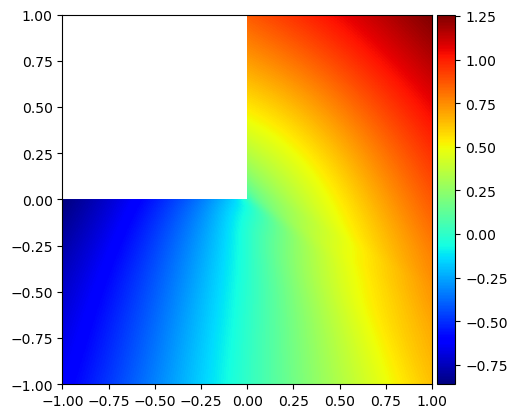

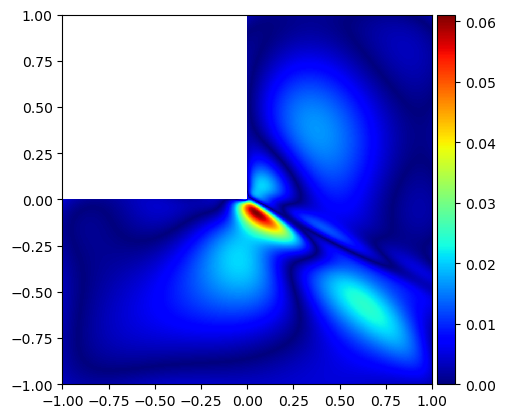

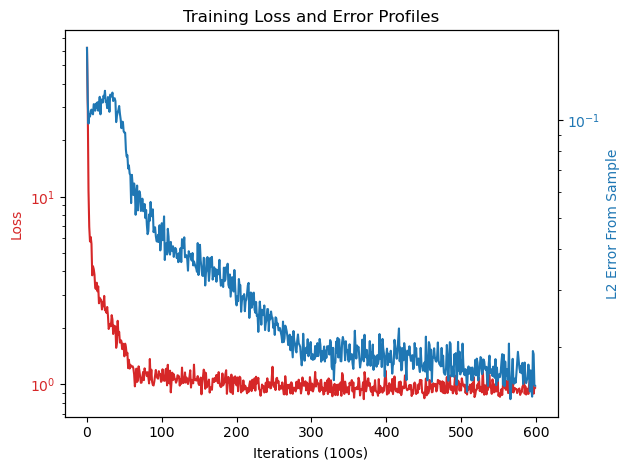

In [29]:
main(domain='l_shape', arch='srnn_Tanh', epochs=60000, lr=3e-3, pretrain=2)

In [32]:
main(domain='l_shape', arch='srnn_Tanh', epochs=5000, lr=3e-7, pretrain=1)

srnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 0.9851976037025452 loss_r: 0.9535201787948608 loss_b: 0.03167739883065224
Interior L2 error: 0.015474106185138226
Boundary L2 error: 0.007820717059075832


/tmp/ipykernel_190/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_190/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_190/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 0.9617927074432373 loss_r: 0.9222634434700012 loss_b: 0.039529282599687576
Interior L2 error: 0.01696431078016758
Boundary L2 error: 0.006754833739250898
epoch: 200 loss: 0.9217429161071777 loss_r: 0.895195722579956 loss_b: 0.026547204703092575
Interior L2 error: 0.015561528503894806
Boundary L2 error: 0.005851389840245247
epoch: 300 loss: 0.9198691248893738 loss_r: 0.9059836864471436 loss_b: 0.013885448686778545
Interior L2 error: 0.015877336263656616
Boundary L2 error: 0.005100652575492859
epoch: 400 loss: 0.8389581441879272 loss_r: 0.8239374160766602 loss_b: 0.015020700171589851
Interior L2 error: 0.01580234058201313
Boundary L2 error: 0.004525080788880587
epoch: 500 loss: 0.9075871109962463 loss_r: 0.9013793468475342 loss_b: 0.0062077403999865055
Interior L2 error: 0.016311436891555786
Boundary L2 error: 0.004087651148438454
epoch: 600 loss: 0.9287490248680115 loss_r: 0.9195003509521484 loss_b: 0.009248689748346806
Interior L2 error: 0.01592034474015236
Boundary L2

epoch: 4900 loss: 0.9151324033737183 loss_r: 0.90558922290802 loss_b: 0.009543204680085182
Interior L2 error: 0.016798825934529305
Boundary L2 error: 0.0032423767261207104
epoch: 5000 loss: 0.9185824394226074 loss_r: 0.8995120525360107 loss_b: 0.01907040737569332
Interior L2 error: 0.017578527331352234
Boundary L2 error: 0.0032379524782299995
best epoch: 4200 best loss: 0.8752882480621338 L2 error: 0.017866507172584534
load from ckpt!


### Standard/Original Architecture, ReLU Activation

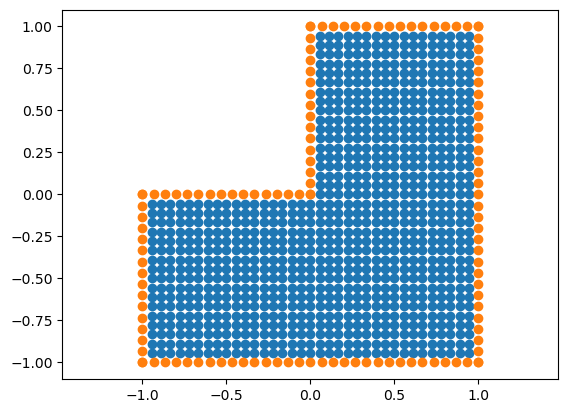

drrnn_ReLU


IntProgress(value=0)

epoch: 0 loss: 2340.483642578125 loss_r: 0.271932989358902 loss_b: 2340.211669921875
Interior L2 error: 0.8826935887336731
Boundary L2 error: 1.8262304067611694


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 1.606515884399414 loss_r: 0.9742326736450195 loss_b: 0.6322832107543945
Interior L2 error: 0.04563318192958832
Boundary L2 error: 0.03500961512327194
epoch: 200 loss: 1.2224491834640503 loss_r: 0.9712970852851868 loss_b: 0.2511520981788635
Interior L2 error: 0.06354393810033798
Boundary L2 error: 0.022368645295500755
epoch: 300 loss: 1.1320370435714722 loss_r: 0.9716311097145081 loss_b: 0.16040590405464172
Interior L2 error: 0.06022799760103226
Boundary L2 error: 0.01786535419523716
epoch: 400 loss: 1.1090404987335205 loss_r: 0.9884880781173706 loss_b: 0.12055245786905289
Interior L2 error: 0.06130928918719292
Boundary L2 error: 0.01550859585404396
epoch: 500 loss: 1.1140382289886475 loss_r: 1.0123088359832764 loss_b: 0.10172944515943527
Interior L2 error: 0.06576333940029144
Boundary L2 error: 0.014263925142586231
epoch: 600 loss: 1.091314435005188 loss_r: 1.00108802318573 loss_b: 0.09022637456655502
Interior L2 error: 0.06908062100410461
Boundary L2 error: 0.01343065

epoch: 5000 loss: 3.455636501312256 loss_r: 1.0181554555892944 loss_b: 2.437481164932251
Interior L2 error: 0.06312784552574158
Boundary L2 error: 0.08402707427740097
epoch: 5100 loss: 1.0736793279647827 loss_r: 1.0071710348129272 loss_b: 0.06650827080011368
Interior L2 error: 0.08597057312726974
Boundary L2 error: 0.011484320275485516
epoch: 5200 loss: 1.0862951278686523 loss_r: 1.013896107673645 loss_b: 0.07239898294210434
Interior L2 error: 0.08559665828943253
Boundary L2 error: 0.011988718062639236
epoch: 5300 loss: 1.2178846597671509 loss_r: 1.0101670026779175 loss_b: 0.2077176421880722
Interior L2 error: 0.08381423354148865
Boundary L2 error: 0.016291562467813492
epoch: 5400 loss: 1.069939374923706 loss_r: 1.0099533796310425 loss_b: 0.05998605117201805
Interior L2 error: 0.0732201337814331
Boundary L2 error: 0.010704399086534977
epoch: 5500 loss: 1.066542625427246 loss_r: 1.0054917335510254 loss_b: 0.061050895601511
Interior L2 error: 0.07521265000104904
Boundary L2 error: 0.0107

epoch: 9900 loss: 2.3558669090270996 loss_r: 1.091076135635376 loss_b: 1.264790654182434
Interior L2 error: 0.10276183485984802
Boundary L2 error: 0.037119582295417786
epoch: 10000 loss: 1.2631170749664307 loss_r: 1.0953258275985718 loss_b: 0.16779127717018127
Interior L2 error: 0.1087723970413208
Boundary L2 error: 0.02023960091173649
best epoch: 8900 best loss: 1.080313801765442 L2 error: 0.09835661202669144
load from ckpt!


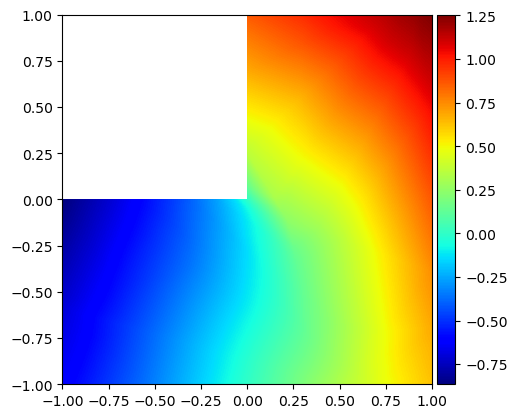

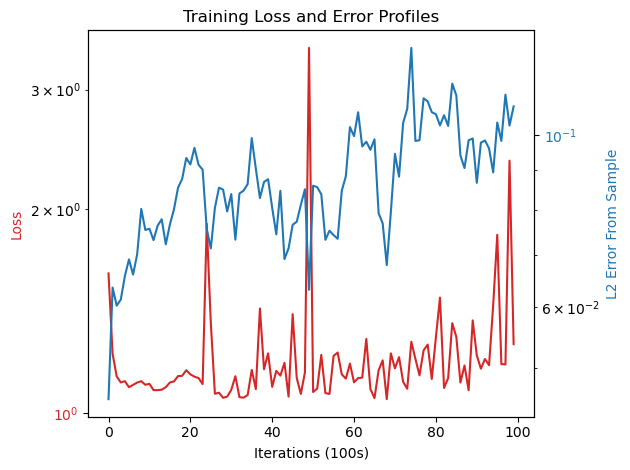

In [53]:
main(domain='l_shape_reg', density=19, arch='drrnn_ReLU', epochs=10000, lr=3e-3, pretrain=0)

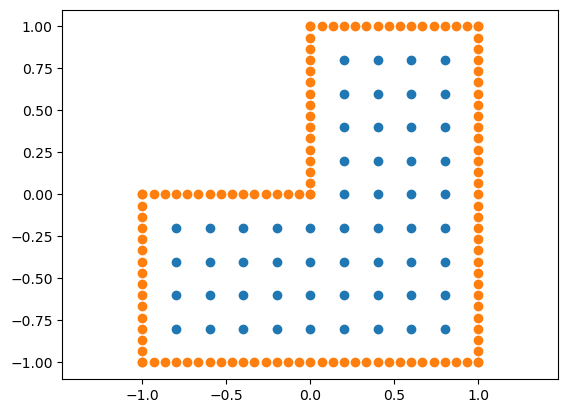

drrnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 3629.705322265625 loss_r: 1.0645484924316406 loss_b: 3628.640869140625
Interior L2 error: 1.1396828889846802
Boundary L2 error: 2.428053855895996


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 18.34697151184082 loss_r: 1.0358943939208984 loss_b: 17.311077117919922
Interior L2 error: 0.11932344734668732
Boundary L2 error: 0.18464775383472443
epoch: 200 loss: 2.915130138397217 loss_r: 1.0503854751586914 loss_b: 1.8647445440292358
Interior L2 error: 0.0760272666811943
Boundary L2 error: 0.06049482524394989
epoch: 300 loss: 1.57638680934906 loss_r: 1.067312240600586 loss_b: 0.5090745687484741
Interior L2 error: 0.06945095211267471
Boundary L2 error: 0.03169000893831253
epoch: 400 loss: 1.2661865949630737 loss_r: 1.0542480945587158 loss_b: 0.21193848550319672
Interior L2 error: 0.07812497764825821
Boundary L2 error: 0.0205495934933424
epoch: 500 loss: 1.2323026657104492 loss_r: 1.069699764251709 loss_b: 0.16260294616222382
Interior L2 error: 0.07807113975286484
Boundary L2 error: 0.018001172691583633
epoch: 600 loss: 1.2236253023147583 loss_r: 1.0924522876739502 loss_b: 0.1311730146408081
Interior L2 error: 0.08581969141960144
Boundary L2 error: 0.016188004985451

epoch: 5000 loss: 1.1037849187850952 loss_r: 1.047583818435669 loss_b: 0.05620107054710388
Interior L2 error: 0.08830134570598602
Boundary L2 error: 0.010884799994528294
best epoch: 4600 best loss: 1.0392566919326782 L2 error: 0.08173075318336487
load from ckpt!


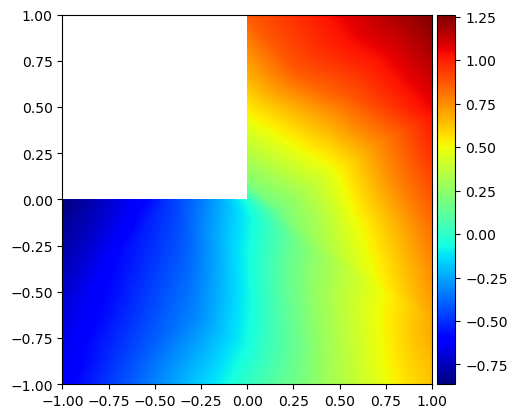

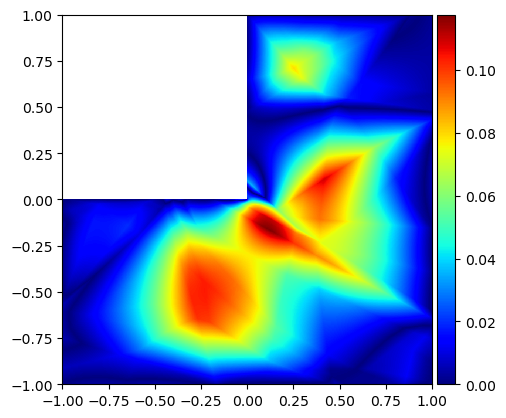

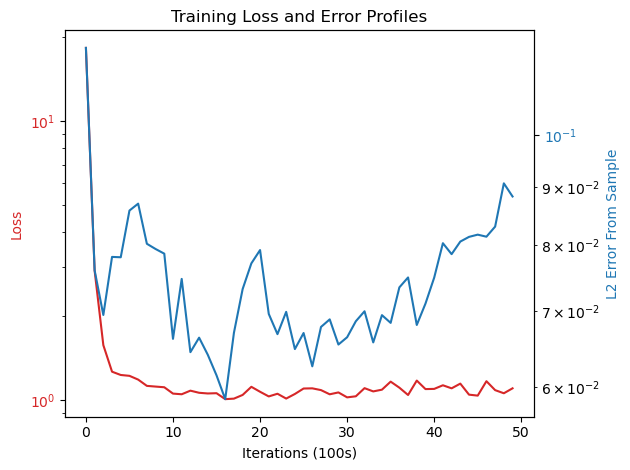

In [44]:
main(domain='l_shape_reg', density=6, arch='drrnn_ReLU', epochs=5000, lr=3e-3, pretrain=0)

### Standard/Original Architecture, Tanh Activation

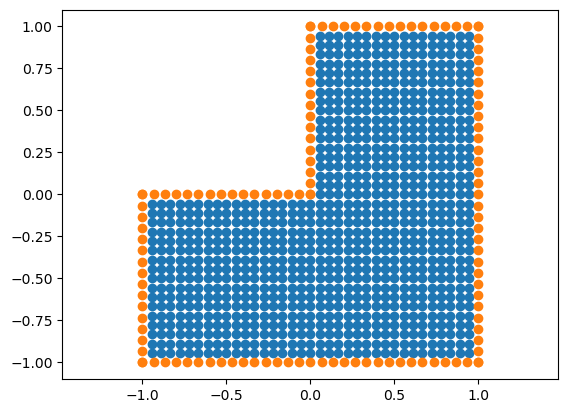

drrnn_Tanh


IntProgress(value=0, max=400)

epoch: 0 loss: 996.076904296875 loss_r: 2.6004579067230225 loss_b: 993.4764404296875
Interior L2 error: 0.42961108684539795
Boundary L2 error: 0.8301806449890137


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 6.861844062805176 loss_r: 1.1215033531188965 loss_b: 5.740340709686279
Interior L2 error: 0.1485583633184433
Boundary L2 error: 0.10675548017024994
epoch: 200 loss: 4.061540603637695 loss_r: 1.0706052780151367 loss_b: 2.9909350872039795
Interior L2 error: 0.12743419408798218
Boundary L2 error: 0.07712297886610031
epoch: 300 loss: 2.8741445541381836 loss_r: 1.041832447052002 loss_b: 1.8323121070861816
Interior L2 error: 0.11533063650131226
Boundary L2 error: 0.06041157245635986
epoch: 400 loss: 2.322108030319214 loss_r: 1.027986764907837 loss_b: 1.294121265411377
Interior L2 error: 0.10237853974103928
Boundary L2 error: 0.05080055445432663
epoch: 500 loss: 2.022373676300049 loss_r: 1.0217359066009521 loss_b: 1.0006377696990967
Interior L2 error: 0.10351129621267319
Boundary L2 error: 0.04468425735831261
epoch: 600 loss: 1.8262025117874146 loss_r: 1.0185551643371582 loss_b: 0.8076473474502563
Interior L2 error: 0.09485559165477753
Boundary L2 error: 0.04015012085437775
e

epoch: 5000 loss: 0.9602528810501099 loss_r: 0.9400018453598022 loss_b: 0.020251018926501274
Interior L2 error: 0.02446461282670498
Boundary L2 error: 0.005110499449074268
epoch: 5100 loss: 1.3758971691131592 loss_r: 0.9158182740211487 loss_b: 0.4600789546966553
Interior L2 error: 0.029073916375637054
Boundary L2 error: 0.013024245388805866
epoch: 5200 loss: 0.9482756853103638 loss_r: 0.9369374513626099 loss_b: 0.011338253505527973
Interior L2 error: 0.027429873123764992
Boundary L2 error: 0.004694775212556124
epoch: 5300 loss: 0.9464855790138245 loss_r: 0.9361938238143921 loss_b: 0.010291756130754948
Interior L2 error: 0.024237828329205513
Boundary L2 error: 0.004534791689366102
epoch: 5400 loss: 1.0058144330978394 loss_r: 0.9329627752304077 loss_b: 0.07285165041685104
Interior L2 error: 0.024034379050135612
Boundary L2 error: 0.00901249423623085
epoch: 5500 loss: 1.6920690536499023 loss_r: 0.9657479524612427 loss_b: 0.7263210415840149
Interior L2 error: 0.03612922132015228
Boundary L

epoch: 9800 loss: 0.9763532280921936 loss_r: 0.9124138355255127 loss_b: 0.06393937766551971
Interior L2 error: 0.012333431281149387
Boundary L2 error: 0.011638467200100422
epoch: 9900 loss: 0.9216971397399902 loss_r: 0.9194077849388123 loss_b: 0.0022893527057021856
Interior L2 error: 0.013607719913125038
Boundary L2 error: 0.0019193082116544247
epoch: 10000 loss: 1.061521291732788 loss_r: 0.9312094449996948 loss_b: 0.13031186163425446
Interior L2 error: 0.013333718292415142
Boundary L2 error: 0.0039002918638288975
epoch: 10100 loss: 0.9213270545005798 loss_r: 0.9192379117012024 loss_b: 0.002089158399030566
Interior L2 error: 0.013943299651145935
Boundary L2 error: 0.002113848924636841
epoch: 10200 loss: 0.9228556156158447 loss_r: 0.918819785118103 loss_b: 0.004035845398902893
Interior L2 error: 0.014134938828647137
Boundary L2 error: 0.004037837497889996
epoch: 10300 loss: 1.1420350074768066 loss_r: 0.9025528430938721 loss_b: 0.2394821047782898
Interior L2 error: 0.016451971605420113
B

epoch: 14600 loss: 0.9136555194854736 loss_r: 0.9118971824645996 loss_b: 0.0017583600711077452
Interior L2 error: 0.014798013493418694
Boundary L2 error: 0.0018492265371605754
epoch: 14700 loss: 0.9149201512336731 loss_r: 0.9129568934440613 loss_b: 0.0019632293842732906
Interior L2 error: 0.016588721424341202
Boundary L2 error: 0.002820112043991685
epoch: 14800 loss: 0.9137569665908813 loss_r: 0.9112398624420166 loss_b: 0.0025171006564050913
Interior L2 error: 0.014255700632929802
Boundary L2 error: 0.0018689901335164905
epoch: 14900 loss: 0.9130591154098511 loss_r: 0.9113807678222656 loss_b: 0.0016783735482022166
Interior L2 error: 0.014943510293960571
Boundary L2 error: 0.0019179180962964892
epoch: 15000 loss: 0.9130262732505798 loss_r: 0.9111530184745789 loss_b: 0.0018732724711298943
Interior L2 error: 0.017016438767313957
Boundary L2 error: 0.0018446854082867503
epoch: 15100 loss: 0.9136553406715393 loss_r: 0.9119319319725037 loss_b: 0.001723423833027482
Interior L2 error: 0.014868

epoch: 19400 loss: 0.8315883278846741 loss_r: 0.8254150152206421 loss_b: 0.006173288449645042
Interior L2 error: 0.03168356791138649
Boundary L2 error: 0.0033787365537136793
epoch: 19500 loss: 2.629408836364746 loss_r: 1.7128876447677612 loss_b: 0.9165212512016296
Interior L2 error: 0.052799224853515625
Boundary L2 error: 0.06889675557613373
epoch: 19600 loss: 0.7824843525886536 loss_r: 0.7723703384399414 loss_b: 0.010114013217389584
Interior L2 error: 0.0543251670897007
Boundary L2 error: 0.0045106010511517525
epoch: 19700 loss: 0.7410480380058289 loss_r: 0.7271104454994202 loss_b: 0.013937612995505333
Interior L2 error: 0.07554737478494644
Boundary L2 error: 0.005430425517261028
epoch: 19800 loss: 0.707955539226532 loss_r: 0.6987830996513367 loss_b: 0.009172428399324417
Interior L2 error: 0.09462020546197891
Boundary L2 error: 0.004287077113986015
epoch: 19900 loss: 0.6815627813339233 loss_r: 0.6736348867416382 loss_b: 0.007927889935672283
Interior L2 error: 0.12069065868854523
Bound

epoch: 24200 loss: 1.1459259986877441 loss_r: 0.9092725515365601 loss_b: 0.23665344715118408
Interior L2 error: 0.01965472847223282
Boundary L2 error: 0.025322631001472473
epoch: 24300 loss: 0.9454692006111145 loss_r: 0.9204245805740356 loss_b: 0.02504463493824005
Interior L2 error: 0.013610877096652985
Boundary L2 error: 0.0061712381429970264
epoch: 24400 loss: 0.9175029993057251 loss_r: 0.9153789281845093 loss_b: 0.002124098362401128
Interior L2 error: 0.013861088082194328
Boundary L2 error: 0.0020302252378314734
epoch: 24500 loss: 0.9172982573509216 loss_r: 0.9149470925331116 loss_b: 0.00235113687813282
Interior L2 error: 0.012472796253859997
Boundary L2 error: 0.0019979416392743587
epoch: 24600 loss: 0.9166787266731262 loss_r: 0.914677083492279 loss_b: 0.002001661341637373
Interior L2 error: 0.013277164660394192
Boundary L2 error: 0.002029345603659749
epoch: 24700 loss: 0.9165958762168884 loss_r: 0.9146146774291992 loss_b: 0.0019811897072941065
Interior L2 error: 0.0128512568771839

epoch: 29000 loss: 1.2434345483779907 loss_r: 1.041902780532837 loss_b: 0.2015317678451538
Interior L2 error: 0.0733824074268341
Boundary L2 error: 0.01989867351949215
epoch: 29100 loss: 1.0542218685150146 loss_r: 0.9736262559890747 loss_b: 0.08059561997652054
Interior L2 error: 0.05257982760667801
Boundary L2 error: 0.012710732407867908
epoch: 29200 loss: 0.9987064599990845 loss_r: 0.9576517343521118 loss_b: 0.041054755449295044
Interior L2 error: 0.046412739902734756
Boundary L2 error: 0.00910006370395422
epoch: 29300 loss: 0.9736437201499939 loss_r: 0.9440500736236572 loss_b: 0.02959361858665943
Interior L2 error: 0.03959932550787926
Boundary L2 error: 0.007683416362851858
epoch: 29400 loss: 0.9599345922470093 loss_r: 0.9344896674156189 loss_b: 0.02544490061700344
Interior L2 error: 0.03450470790266991
Boundary L2 error: 0.00677773542702198
epoch: 29500 loss: 0.9464926719665527 loss_r: 0.9287272095680237 loss_b: 0.017765436321496964
Interior L2 error: 0.030852457508444786
Boundary L

epoch: 33800 loss: 0.8204934597015381 loss_r: 0.8081405162811279 loss_b: 0.01235292199999094
Interior L2 error: 0.0568053163588047
Boundary L2 error: 0.005449004005640745
epoch: 33900 loss: 0.8051767945289612 loss_r: 0.80057692527771 loss_b: 0.004599872976541519
Interior L2 error: 0.05898261442780495
Boundary L2 error: 0.003025609999895096
epoch: 34000 loss: 0.7997468709945679 loss_r: 0.7954503893852234 loss_b: 0.004296510946005583
Interior L2 error: 0.06686750799417496
Boundary L2 error: 0.00297509110532701
epoch: 34100 loss: 0.7955117225646973 loss_r: 0.7910549640655518 loss_b: 0.004456762690097094
Interior L2 error: 0.06676223874092102
Boundary L2 error: 0.0030099512077867985
epoch: 34200 loss: 0.7904499769210815 loss_r: 0.7864536046981812 loss_b: 0.0039963917806744576
Interior L2 error: 0.06715675443410873
Boundary L2 error: 0.0029151751659810543
epoch: 34300 loss: 0.7863397598266602 loss_r: 0.7821973562240601 loss_b: 0.0041424306109547615
Interior L2 error: 0.07192207872867584
Bou

epoch: 38600 loss: 0.600025475025177 loss_r: 0.5871778726577759 loss_b: 0.01284762192517519
Interior L2 error: 0.24267752468585968
Boundary L2 error: 0.0057663205079734325
epoch: 38700 loss: 0.6304851770401001 loss_r: 0.5911599397659302 loss_b: 0.03932526707649231
Interior L2 error: 0.2272331416606903
Boundary L2 error: 0.008764534257352352
epoch: 38800 loss: 0.5950890779495239 loss_r: 0.5842568874359131 loss_b: 0.010832192376255989
Interior L2 error: 0.23329295217990875
Boundary L2 error: 0.004383459221571684
epoch: 38900 loss: 0.6080033779144287 loss_r: 0.5831235647201538 loss_b: 0.024879807606339455
Interior L2 error: 0.21879813075065613
Boundary L2 error: 0.006554797291755676
epoch: 39000 loss: 0.5964511632919312 loss_r: 0.5863296985626221 loss_b: 0.010121483355760574
Interior L2 error: 0.22846291959285736
Boundary L2 error: 0.004034495446830988
epoch: 39100 loss: 0.6036416292190552 loss_r: 0.5859223008155823 loss_b: 0.017719298601150513
Interior L2 error: 0.22288553416728973
Bound

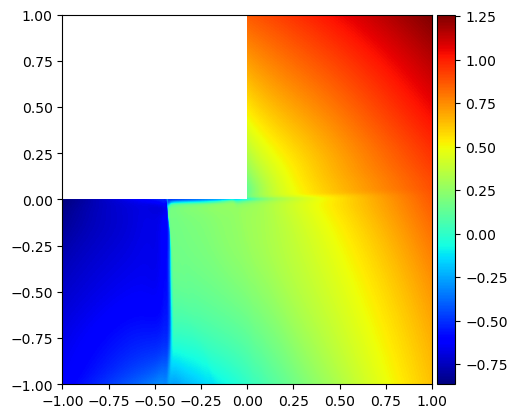

In [41]:
main(domain='l_shape_reg', density=19, arch='drrnn_Tanh', epochs=40000, lr=3e-3, pretrain=0)

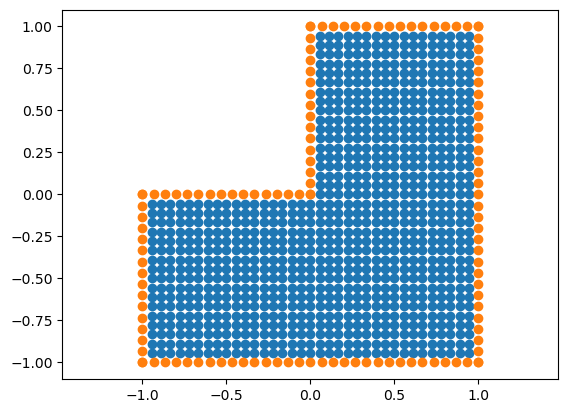

drrnn_Tanh


IntProgress(value=0)

epoch: 0 loss: 4104.400390625 loss_r: 3.376610279083252 loss_b: 4101.02392578125
Interior L2 error: 1.128931999206543
Boundary L2 error: 2.071342706680298


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 6.745255947113037 loss_r: 1.0770339965820312 loss_b: 5.668221950531006
Interior L2 error: 0.13895568251609802
Boundary L2 error: 0.1054234504699707
epoch: 200 loss: 2.9767041206359863 loss_r: 1.0220050811767578 loss_b: 1.954699158668518
Interior L2 error: 0.09991089999675751
Boundary L2 error: 0.06237653270363808
epoch: 300 loss: 2.4380993843078613 loss_r: 1.0073599815368652 loss_b: 1.4307392835617065
Interior L2 error: 0.09229465574026108
Boundary L2 error: 0.05343393608927727
epoch: 400 loss: 2.1859917640686035 loss_r: 1.0025546550750732 loss_b: 1.1834369897842407
Interior L2 error: 0.08649089932441711
Boundary L2 error: 0.04860934615135193
epoch: 500 loss: 2.0073275566101074 loss_r: 1.0001657009124756 loss_b: 1.0071618556976318
Interior L2 error: 0.08923090994358063
Boundary L2 error: 0.04484611749649048
epoch: 600 loss: 1.8603918552398682 loss_r: 0.9985808730125427 loss_b: 0.8618110418319702
Interior L2 error: 0.08394177258014679
Boundary L2 error: 0.04148398712277

epoch: 5000 loss: 1.4797471761703491 loss_r: 0.9744831323623657 loss_b: 0.5052640438079834
Interior L2 error: 0.04263994097709656
Boundary L2 error: 0.04108620434999466
epoch: 5100 loss: 0.9731942415237427 loss_r: 0.9487704038619995 loss_b: 0.02442382276058197
Interior L2 error: 0.02443905919790268
Boundary L2 error: 0.006891236640512943
epoch: 5200 loss: 0.9707014560699463 loss_r: 0.9481943249702454 loss_b: 0.02250712364912033
Interior L2 error: 0.027174707502126694
Boundary L2 error: 0.006708088330924511
epoch: 5300 loss: 0.9839996695518494 loss_r: 0.9428848028182983 loss_b: 0.041114844381809235
Interior L2 error: 0.025926830247044563
Boundary L2 error: 0.00812066625803709
epoch: 5400 loss: 0.9673919081687927 loss_r: 0.946039080619812 loss_b: 0.021352827548980713
Interior L2 error: 0.024855030700564384
Boundary L2 error: 0.0065180230885744095
epoch: 5500 loss: 1.0088016986846924 loss_r: 0.9431056976318359 loss_b: 0.06569597870111465
Interior L2 error: 0.028985677286982536
Boundary L2

epoch: 9800 loss: 1.1838805675506592 loss_r: 0.9324726462364197 loss_b: 0.2514078617095947
Interior L2 error: 0.017760852351784706
Boundary L2 error: 0.009825540706515312
epoch: 9900 loss: 1.3137788772583008 loss_r: 0.9505263566970825 loss_b: 0.36325255036354065
Interior L2 error: 0.02568676695227623
Boundary L2 error: 0.029852673411369324
epoch: 10000 loss: 0.9326256513595581 loss_r: 0.9283955097198486 loss_b: 0.004230167716741562
Interior L2 error: 0.01541905663907528
Boundary L2 error: 0.0029385529924184084
best epoch: 10000 best loss: 0.9326256513595581 L2 error: 0.01541905663907528
load from ckpt!


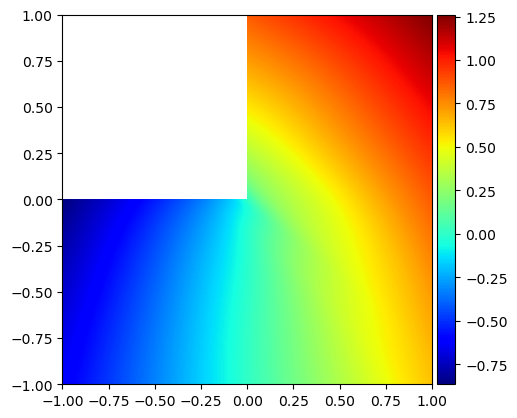

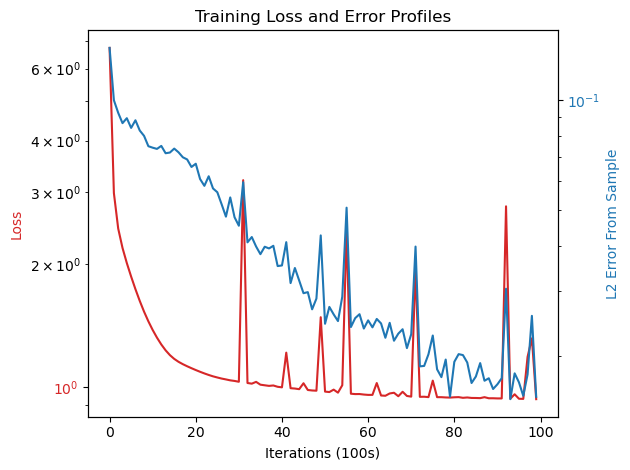

In [50]:
main(domain='l_shape_reg', density=19, arch='drrnn_Tanh', epochs=10000, lr=3e-3, pretrain=0)

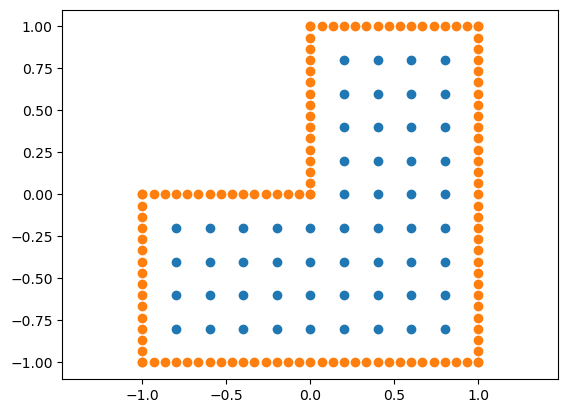

drrnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 3802.09716796875 loss_r: 1.225246787071228 loss_b: 3800.871826171875
Interior L2 error: 1.1147900819778442
Boundary L2 error: 2.233616828918457


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 5.620651721954346 loss_r: 1.0887012481689453 loss_b: 4.5319504737854
Interior L2 error: 0.1072416752576828
Boundary L2 error: 0.09468872100114822
epoch: 200 loss: 3.2088160514831543 loss_r: 1.0336806774139404 loss_b: 2.175135374069214
Interior L2 error: 0.07466263324022293
Boundary L2 error: 0.06578551232814789
epoch: 300 loss: 2.4056453704833984 loss_r: 1.01750910282135 loss_b: 1.3881361484527588
Interior L2 error: 0.0717092975974083
Boundary L2 error: 0.052589017897844315
epoch: 400 loss: 2.016408920288086 loss_r: 1.0128552913665771 loss_b: 1.0035537481307983
Interior L2 error: 0.07298776507377625
Boundary L2 error: 0.04474072530865669
epoch: 500 loss: 1.8115763664245605 loss_r: 1.0127954483032227 loss_b: 0.7987808585166931
Interior L2 error: 0.07317670434713364
Boundary L2 error: 0.0399305634200573
epoch: 600 loss: 1.6845158338546753 loss_r: 1.0140950679779053 loss_b: 0.67042076587677
Interior L2 error: 0.07158376276493073
Boundary L2 error: 0.03658819571137428
epoc

epoch: 5000 loss: 0.9052098393440247 loss_r: 0.8894696235656738 loss_b: 0.01574021950364113
Interior L2 error: 0.04028449207544327
Boundary L2 error: 0.005611116997897625
best epoch: 5000 best loss: 0.9052098393440247 L2 error: 0.04028449207544327
load from ckpt!


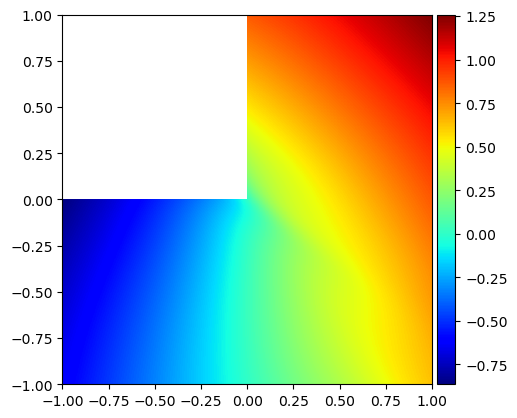

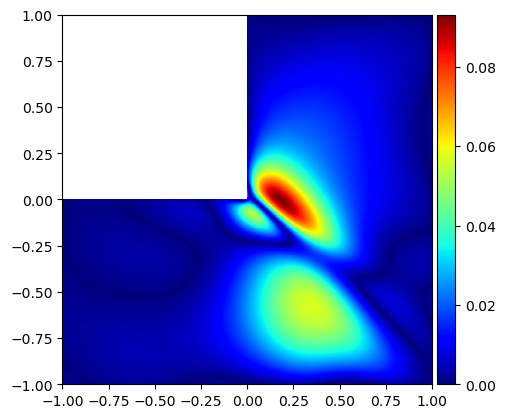

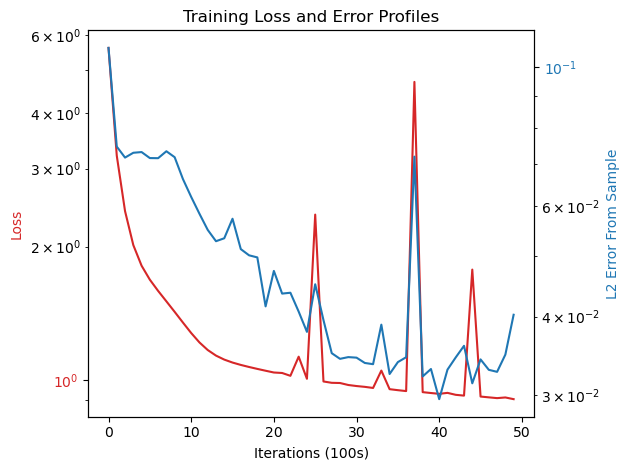

In [45]:
main(domain='l_shape_reg', density=6, arch='drrnn_Tanh', epochs=5000, lr=3e-3, pretrain=0)

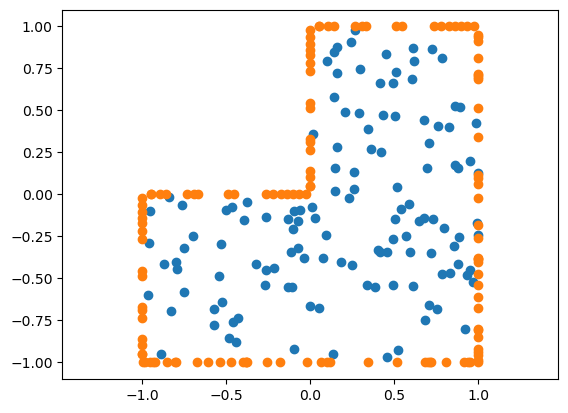

drrnn_Tanh


IntProgress(value=0, max=400)

epoch: 0 loss: 4866.4140625 loss_r: 1.6299487352371216 loss_b: 4864.7841796875
Interior L2 error: 1.3442959785461426
Boundary L2 error: 2.6606335639953613


/tmp/ipykernel_175/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_175/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_175/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 5.312351226806641 loss_r: 1.1518375873565674 loss_b: 4.160513401031494
Interior L2 error: 0.10282746702432632
Boundary L2 error: 0.09338296949863434
epoch: 200 loss: 3.629763603210449 loss_r: 0.9945789575576782 loss_b: 2.6351845264434814
Interior L2 error: 0.10438483953475952
Boundary L2 error: 0.07308531552553177
epoch: 300 loss: 2.653010368347168 loss_r: 0.9726439714431763 loss_b: 1.6803665161132812
Interior L2 error: 0.10272455960512161
Boundary L2 error: 0.05625152960419655
epoch: 400 loss: 2.071139335632324 loss_r: 0.8883458375930786 loss_b: 1.182793378829956
Interior L2 error: 0.10271009802818298
Boundary L2 error: 0.04735540226101875
epoch: 500 loss: 2.0517468452453613 loss_r: 0.9748058319091797 loss_b: 1.076940894126892
Interior L2 error: 0.10898838192224503
Boundary L2 error: 0.04204731434583664
epoch: 600 loss: 1.8440783023834229 loss_r: 1.107033371925354 loss_b: 0.7370449304580688
Interior L2 error: 0.11892059445381165
Boundary L2 error: 0.03918386995792389


epoch: 5000 loss: 1.0742067098617554 loss_r: 0.9551963210105896 loss_b: 0.11901034414768219
Interior L2 error: 0.029129071161150932
Boundary L2 error: 0.011988455429673195
epoch: 5100 loss: 1.0153319835662842 loss_r: 0.9209555387496948 loss_b: 0.09437646716833115
Interior L2 error: 0.028958840295672417
Boundary L2 error: 0.013939069584012032
epoch: 5200 loss: 1.2006213665008545 loss_r: 0.9849504232406616 loss_b: 0.21567092835903168
Interior L2 error: 0.034693438559770584
Boundary L2 error: 0.017026152461767197
epoch: 5300 loss: 1.0063377618789673 loss_r: 0.8648656606674194 loss_b: 0.14147211611270905
Interior L2 error: 0.028916973620653152
Boundary L2 error: 0.0145313311368227
epoch: 5400 loss: 0.9342594742774963 loss_r: 0.8701990842819214 loss_b: 0.06406039744615555
Interior L2 error: 0.030947325751185417
Boundary L2 error: 0.01445395965129137
epoch: 5500 loss: 1.157588005065918 loss_r: 1.0080405473709106 loss_b: 0.14954744279384613
Interior L2 error: 0.023448148742318153
Boundary L2 

epoch: 9800 loss: 0.9823266267776489 loss_r: 0.8539257049560547 loss_b: 0.12840092182159424
Interior L2 error: 0.01685047708451748
Boundary L2 error: 0.00943021196871996
epoch: 9900 loss: 0.9256235361099243 loss_r: 0.8662359714508057 loss_b: 0.05938757583498955
Interior L2 error: 0.017829403281211853
Boundary L2 error: 0.010861805640161037
epoch: 10000 loss: 1.0605167150497437 loss_r: 0.9609172344207764 loss_b: 0.0995994582772255
Interior L2 error: 0.01529932301491499
Boundary L2 error: 0.013109998777508736
epoch: 10100 loss: 0.9445823431015015 loss_r: 0.8833521604537964 loss_b: 0.061230167746543884
Interior L2 error: 0.01634780503809452
Boundary L2 error: 0.013192277401685715
epoch: 10200 loss: 1.1113500595092773 loss_r: 1.004724383354187 loss_b: 0.10662566870450974
Interior L2 error: 0.02140279859304428
Boundary L2 error: 0.017865756526589394
epoch: 10300 loss: 1.0273783206939697 loss_r: 0.9238119721412659 loss_b: 0.10356630384922028
Interior L2 error: 0.014852945692837238
Boundary L

epoch: 14600 loss: 0.9932073354721069 loss_r: 0.9197374582290649 loss_b: 0.0734698548913002
Interior L2 error: 0.01117931678891182
Boundary L2 error: 0.006384400185197592
epoch: 14700 loss: 0.962600588798523 loss_r: 0.8816146850585938 loss_b: 0.0809859037399292
Interior L2 error: 0.013443957082927227
Boundary L2 error: 0.010431863367557526
epoch: 14800 loss: 1.019540786743164 loss_r: 0.9650411009788513 loss_b: 0.054499682039022446
Interior L2 error: 0.012897706590592861
Boundary L2 error: 0.013487135991454124
epoch: 14900 loss: 0.9974355697631836 loss_r: 0.9159635305404663 loss_b: 0.08147202432155609
Interior L2 error: 0.010908383876085281
Boundary L2 error: 0.012898881919682026
epoch: 15000 loss: 0.9684178233146667 loss_r: 0.8847032189369202 loss_b: 0.08371458202600479
Interior L2 error: 0.015152609907090664
Boundary L2 error: 0.015026948414742947
epoch: 15100 loss: 0.9682113528251648 loss_r: 0.938666582107544 loss_b: 0.02954479306936264
Interior L2 error: 0.01079605333507061
Boundary

epoch: 19400 loss: 1.0720218420028687 loss_r: 0.955503523349762 loss_b: 0.1165183037519455
Interior L2 error: 0.009450940415263176
Boundary L2 error: 0.01233504805713892
epoch: 19500 loss: 1.009132981300354 loss_r: 0.9447610974311829 loss_b: 0.06437186151742935
Interior L2 error: 0.009202288463711739
Boundary L2 error: 0.006410016678273678
epoch: 19600 loss: 0.9978590607643127 loss_r: 0.9491091370582581 loss_b: 0.04874991253018379
Interior L2 error: 0.009620092809200287
Boundary L2 error: 0.010728312656283379
epoch: 19700 loss: 1.147011160850525 loss_r: 0.963959276676178 loss_b: 0.18305186927318573
Interior L2 error: 0.012570132501423359
Boundary L2 error: 0.021734585985541344
epoch: 19800 loss: 0.90318363904953 loss_r: 0.8246655464172363 loss_b: 0.0785180926322937
Interior L2 error: 0.015847889706492424
Boundary L2 error: 0.013557720929384232
epoch: 19900 loss: 0.971818745136261 loss_r: 0.9321557283401489 loss_b: 0.03966299816966057
Interior L2 error: 0.011091720312833786
Boundary L2 

epoch: 24200 loss: 0.9316065907478333 loss_r: 0.8691420555114746 loss_b: 0.06246451660990715
Interior L2 error: 0.00955937709659338
Boundary L2 error: 0.00908643938601017
epoch: 24300 loss: 1.003348708152771 loss_r: 0.945726752281189 loss_b: 0.057621922343969345
Interior L2 error: 0.009260449558496475
Boundary L2 error: 0.009548578411340714
epoch: 24400 loss: 0.9354132413864136 loss_r: 0.8912395238876343 loss_b: 0.04417369142174721
Interior L2 error: 0.009057520888745785
Boundary L2 error: 0.008372054435312748
epoch: 24500 loss: 1.0333738327026367 loss_r: 0.9680945873260498 loss_b: 0.06527922302484512
Interior L2 error: 0.0111839072778821
Boundary L2 error: 0.010226498357951641
epoch: 24600 loss: 0.9700573682785034 loss_r: 0.9422723650932312 loss_b: 0.027784978970885277
Interior L2 error: 0.008962047286331654
Boundary L2 error: 0.006620372645556927
epoch: 24700 loss: 1.022812843322754 loss_r: 0.9283528327941895 loss_b: 0.09446004778146744
Interior L2 error: 0.012089033611118793
Boundar

epoch: 29000 loss: 1.0851643085479736 loss_r: 1.0214961767196655 loss_b: 0.06366812437772751
Interior L2 error: 0.01050558127462864
Boundary L2 error: 0.013988430611789227
epoch: 29100 loss: 0.9411709904670715 loss_r: 0.9119184017181396 loss_b: 0.029252570122480392
Interior L2 error: 0.010929841548204422
Boundary L2 error: 0.008061029016971588
epoch: 29200 loss: 0.9316807389259338 loss_r: 0.9101788401603699 loss_b: 0.021501906216144562
Interior L2 error: 0.009547519497573376
Boundary L2 error: 0.005387658718973398
epoch: 29300 loss: 0.9184046387672424 loss_r: 0.9009190797805786 loss_b: 0.01748557947576046
Interior L2 error: 0.012405344285070896
Boundary L2 error: 0.015109941363334656
epoch: 29400 loss: 0.9272439479827881 loss_r: 0.9163926839828491 loss_b: 0.010851274244487286
Interior L2 error: 0.00836801715195179
Boundary L2 error: 0.005013670772314072
epoch: 29500 loss: 0.932573676109314 loss_r: 0.9155677556991577 loss_b: 0.017005927860736847
Interior L2 error: 0.009776940569281578
B

epoch: 33800 loss: 0.9803204536437988 loss_r: 0.9551458954811096 loss_b: 0.025174550712108612
Interior L2 error: 0.009284306317567825
Boundary L2 error: 0.008631735108792782
epoch: 33900 loss: 0.8911914229393005 loss_r: 0.8756414651870728 loss_b: 0.015549985691905022
Interior L2 error: 0.00817847903817892
Boundary L2 error: 0.00446004094555974
epoch: 34000 loss: 0.9825059175491333 loss_r: 0.9667026400566101 loss_b: 0.015803270041942596
Interior L2 error: 0.008162708021700382
Boundary L2 error: 0.007075618486851454
epoch: 34100 loss: 0.9612990021705627 loss_r: 0.9059491157531738 loss_b: 0.05534989386796951
Interior L2 error: 0.011460053734481335
Boundary L2 error: 0.011299388483166695
epoch: 34200 loss: 1.0972163677215576 loss_r: 0.9253515005111694 loss_b: 0.1718648225069046
Interior L2 error: 0.010050328448414803
Boundary L2 error: 0.014706308953464031
epoch: 34300 loss: 0.9864699840545654 loss_r: 0.8981428146362305 loss_b: 0.08832717686891556
Interior L2 error: 0.009786972776055336
Bo

epoch: 38600 loss: 0.9173988699913025 loss_r: 0.9002528190612793 loss_b: 0.017146050930023193
Interior L2 error: 0.008394725620746613
Boundary L2 error: 0.00741253886371851
epoch: 38700 loss: 0.9433475732803345 loss_r: 0.9283592700958252 loss_b: 0.014988301321864128
Interior L2 error: 0.007958575151860714
Boundary L2 error: 0.004824180621653795
epoch: 38800 loss: 0.9455150961875916 loss_r: 0.9385004043579102 loss_b: 0.007014695089310408
Interior L2 error: 0.008039962500333786
Boundary L2 error: 0.0033628386445343494
epoch: 38900 loss: 0.925758421421051 loss_r: 0.907545268535614 loss_b: 0.0182131789624691
Interior L2 error: 0.007359256036579609
Boundary L2 error: 0.005930467043071985
epoch: 39000 loss: 1.0014086961746216 loss_r: 0.8488395810127258 loss_b: 0.15256915986537933
Interior L2 error: 0.017341943457722664
Boundary L2 error: 0.01746617816388607
epoch: 39100 loss: 0.9529948234558105 loss_r: 0.943783700466156 loss_b: 0.00921113695949316
Interior L2 error: 0.0075347814708948135
Bou

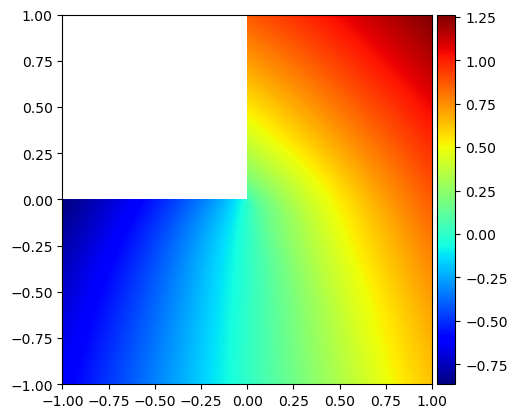

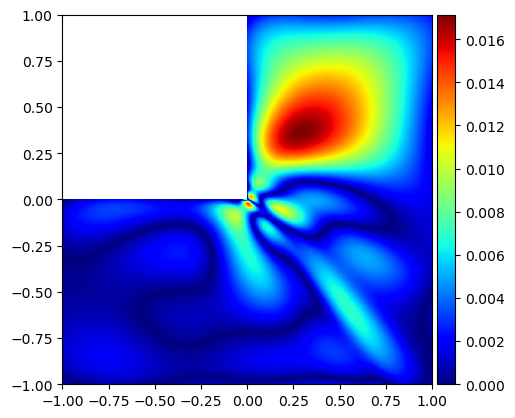

In [25]:
main(domain='l_shape', arch='drrnn_Tanh', epochs=40000, lr=3e-3, pretrain=0)

drrnn_Tanh


IntProgress(value=0, max=600)

epoch: 0 loss: 3941.04931640625 loss_r: 0.5654230713844299 loss_b: 3940.48388671875
Interior L2 error: 1.1860402822494507
Boundary L2 error: 2.2792112827301025


/tmp/ipykernel_175/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_175/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_175/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 5.170395374298096 loss_r: 0.9961904287338257 loss_b: 4.1742048263549805
Interior L2 error: 0.174219012260437
Boundary L2 error: 0.0950942113995552
epoch: 200 loss: 3.520022392272949 loss_r: 1.1553514003753662 loss_b: 2.364670991897583
Interior L2 error: 0.13597147166728973
Boundary L2 error: 0.07444348186254501
epoch: 300 loss: 3.309107780456543 loss_r: 1.1821492910385132 loss_b: 2.1269586086273193
Interior L2 error: 0.11522188782691956
Boundary L2 error: 0.06640790402889252
epoch: 400 loss: 2.654374361038208 loss_r: 0.8979100584983826 loss_b: 1.7564643621444702
Interior L2 error: 0.1113978698849678
Boundary L2 error: 0.05724217742681503
epoch: 500 loss: 2.53621244430542 loss_r: 0.8901852369308472 loss_b: 1.6460273265838623
Interior L2 error: 0.10751029849052429
Boundary L2 error: 0.05126171186566353
epoch: 600 loss: 1.79618239402771 loss_r: 1.119598627090454 loss_b: 0.6765837073326111
Interior L2 error: 0.09781195968389511
Boundary L2 error: 0.04568726196885109
epoch:

epoch: 5000 loss: 1.0641734600067139 loss_r: 0.9380097389221191 loss_b: 0.12616375088691711
Interior L2 error: 0.025731178000569344
Boundary L2 error: 0.016264542937278748
epoch: 5100 loss: 1.1143380403518677 loss_r: 1.048851490020752 loss_b: 0.06548658013343811
Interior L2 error: 0.022915640845894814
Boundary L2 error: 0.004374288488179445
epoch: 5200 loss: 1.0438205003738403 loss_r: 0.9414798021316528 loss_b: 0.10234065353870392
Interior L2 error: 0.024536244571208954
Boundary L2 error: 0.008747796528041363
epoch: 5300 loss: 0.9796860218048096 loss_r: 0.9354039430618286 loss_b: 0.04428208991885185
Interior L2 error: 0.025647344067692757
Boundary L2 error: 0.007991768419742584
epoch: 5400 loss: 1.1498245000839233 loss_r: 1.1420725584030151 loss_b: 0.007751887198537588
Interior L2 error: 0.02074984274804592
Boundary L2 error: 0.008024279028177261
epoch: 5500 loss: 0.8664897680282593 loss_r: 0.859005331993103 loss_b: 0.007484409026801586
Interior L2 error: 0.023449476808309555
Boundary 

epoch: 9800 loss: 1.0278936624526978 loss_r: 0.9278252124786377 loss_b: 0.10006846487522125
Interior L2 error: 0.015378785319626331
Boundary L2 error: 0.013251854106783867
epoch: 9900 loss: 0.9591041803359985 loss_r: 0.8925792574882507 loss_b: 0.06652489304542542
Interior L2 error: 0.010148690082132816
Boundary L2 error: 0.01592717319726944
epoch: 10000 loss: 0.9909965395927429 loss_r: 0.906661868095398 loss_b: 0.08433467149734497
Interior L2 error: 0.011620493605732918
Boundary L2 error: 0.011491658166050911
epoch: 10100 loss: 1.0106239318847656 loss_r: 0.9375208616256714 loss_b: 0.07310310751199722
Interior L2 error: 0.012690287083387375
Boundary L2 error: 0.009476370178163052
epoch: 10200 loss: 0.9861382842063904 loss_r: 0.9197335839271545 loss_b: 0.06640470027923584
Interior L2 error: 0.011586311273276806
Boundary L2 error: 0.008834637701511383
epoch: 10300 loss: 0.9365561008453369 loss_r: 0.9173420667648315 loss_b: 0.019214030355215073
Interior L2 error: 0.01287001371383667
Bounda

epoch: 14600 loss: 0.9551248550415039 loss_r: 0.9098973274230957 loss_b: 0.045227523893117905
Interior L2 error: 0.007152104284614325
Boundary L2 error: 0.008345927111804485
epoch: 14700 loss: 0.978858232498169 loss_r: 0.8952553272247314 loss_b: 0.08360293507575989
Interior L2 error: 0.009013887494802475
Boundary L2 error: 0.015322213992476463
epoch: 14800 loss: 0.9190520644187927 loss_r: 0.8994098901748657 loss_b: 0.019642183557152748
Interior L2 error: 0.006687472574412823
Boundary L2 error: 0.007829980924725533
epoch: 14900 loss: 0.9131414294242859 loss_r: 0.9026435613632202 loss_b: 0.010497896932065487
Interior L2 error: 0.00608892273157835
Boundary L2 error: 0.008623877540230751
epoch: 15000 loss: 0.9280861020088196 loss_r: 0.8858896493911743 loss_b: 0.04219647869467735
Interior L2 error: 0.0085481908172369
Boundary L2 error: 0.007277597673237324
epoch: 15100 loss: 1.129422903060913 loss_r: 0.8903956413269043 loss_b: 0.23902732133865356
Interior L2 error: 0.014256762340664864
Boun

epoch: 19400 loss: 0.9333332180976868 loss_r: 0.9226056933403015 loss_b: 0.010727537795901299
Interior L2 error: 0.0055785588920116425
Boundary L2 error: 0.006863236892968416
epoch: 19500 loss: 0.9915223121643066 loss_r: 0.9709707498550415 loss_b: 0.020551536232233047
Interior L2 error: 0.005580475553870201
Boundary L2 error: 0.0042492542415857315
epoch: 19600 loss: 0.8674428462982178 loss_r: 0.8367878794670105 loss_b: 0.030654991045594215
Interior L2 error: 0.007367986254394054
Boundary L2 error: 0.008692043833434582
epoch: 19700 loss: 0.9187489748001099 loss_r: 0.9125444889068604 loss_b: 0.006204479373991489
Interior L2 error: 0.007803496904671192
Boundary L2 error: 0.008611707016825676
epoch: 19800 loss: 0.8976174592971802 loss_r: 0.8767597675323486 loss_b: 0.020857704803347588
Interior L2 error: 0.006507386919111013
Boundary L2 error: 0.009125720709562302
epoch: 19900 loss: 0.8995335698127747 loss_r: 0.8434587121009827 loss_b: 0.0560748428106308
Interior L2 error: 0.007831837981939

epoch: 24200 loss: 1.008999228477478 loss_r: 0.9523224830627441 loss_b: 0.05667673796415329
Interior L2 error: 0.008634920231997967
Boundary L2 error: 0.009370459243655205
epoch: 24300 loss: 0.9431686401367188 loss_r: 0.9280099868774414 loss_b: 0.015158665366470814
Interior L2 error: 0.005260040517896414
Boundary L2 error: 0.005212088115513325
epoch: 24400 loss: 1.0071444511413574 loss_r: 0.9774727821350098 loss_b: 0.029671713709831238
Interior L2 error: 0.005579064134508371
Boundary L2 error: 0.01278787199407816
epoch: 24500 loss: 0.9459779858589172 loss_r: 0.9319438934326172 loss_b: 0.014034073799848557
Interior L2 error: 0.004805860575288534
Boundary L2 error: 0.007033304311335087
epoch: 24600 loss: 0.9530662298202515 loss_r: 0.9382381439208984 loss_b: 0.014828059822320938
Interior L2 error: 0.00788802094757557
Boundary L2 error: 0.008044288493692875
epoch: 24700 loss: 1.0557008981704712 loss_r: 0.9323539137840271 loss_b: 0.12334699928760529
Interior L2 error: 0.010829854756593704
B

epoch: 29000 loss: 0.9327341914176941 loss_r: 0.9154388308525085 loss_b: 0.017295341938734055
Interior L2 error: 0.005901121534407139
Boundary L2 error: 0.0036238087341189384
epoch: 29100 loss: 1.0240205526351929 loss_r: 1.0080208778381348 loss_b: 0.01599966734647751
Interior L2 error: 0.006264675408601761
Boundary L2 error: 0.008884835056960583
epoch: 29200 loss: 0.9965344071388245 loss_r: 0.9790711402893066 loss_b: 0.01746325194835663
Interior L2 error: 0.006204253528267145
Boundary L2 error: 0.006548610981553793
epoch: 29300 loss: 0.8797044157981873 loss_r: 0.852839469909668 loss_b: 0.02686494030058384
Interior L2 error: 0.009752454236149788
Boundary L2 error: 0.007663342636078596
epoch: 29400 loss: 0.9013012647628784 loss_r: 0.8784976601600647 loss_b: 0.02280357852578163
Interior L2 error: 0.006501162890344858
Boundary L2 error: 0.009219248779118061
epoch: 29500 loss: 0.9098631143569946 loss_r: 0.9005168080329895 loss_b: 0.009346314705908298
Interior L2 error: 0.0075192940421402454

epoch: 33800 loss: 1.0271368026733398 loss_r: 1.013779878616333 loss_b: 0.013356896117329597
Interior L2 error: 0.007172951474785805
Boundary L2 error: 0.00387851195409894
epoch: 33900 loss: 0.8662028908729553 loss_r: 0.8618924617767334 loss_b: 0.004310403484851122
Interior L2 error: 0.004101507365703583
Boundary L2 error: 0.0025206897407770157
epoch: 34000 loss: 1.0264500379562378 loss_r: 1.0158250331878662 loss_b: 0.0106250224635005
Interior L2 error: 0.008630042895674706
Boundary L2 error: 0.006099769379943609
epoch: 34100 loss: 0.9379130601882935 loss_r: 0.9229475259780884 loss_b: 0.014965560287237167
Interior L2 error: 0.007756446022540331
Boundary L2 error: 0.0058214240707457066
epoch: 34200 loss: 1.0026613473892212 loss_r: 0.9679197072982788 loss_b: 0.03474166989326477
Interior L2 error: 0.006543611641973257
Boundary L2 error: 0.009207969531416893
epoch: 34300 loss: 1.0784752368927002 loss_r: 1.0674071311950684 loss_b: 0.01106808241456747
Interior L2 error: 0.006377818062901497


epoch: 38600 loss: 0.9582628011703491 loss_r: 0.9501317739486694 loss_b: 0.00813103374093771
Interior L2 error: 0.007011151872575283
Boundary L2 error: 0.003555956296622753
epoch: 38700 loss: 0.9698755741119385 loss_r: 0.9644356966018677 loss_b: 0.0054398998618125916
Interior L2 error: 0.00919171329587698
Boundary L2 error: 0.0046710907481610775
epoch: 38800 loss: 0.9059872627258301 loss_r: 0.9008567333221436 loss_b: 0.0051305172964930534
Interior L2 error: 0.0052180178463459015
Boundary L2 error: 0.0036049329210072756
epoch: 38900 loss: 1.0128209590911865 loss_r: 0.9900303483009338 loss_b: 0.022790607064962387
Interior L2 error: 0.020381443202495575
Boundary L2 error: 0.007086044177412987
epoch: 39000 loss: 1.0584361553192139 loss_r: 0.9045546054840088 loss_b: 0.15388156473636627
Interior L2 error: 0.010969982482492924
Boundary L2 error: 0.02527512051165104
epoch: 39100 loss: 0.9513346552848816 loss_r: 0.9432665705680847 loss_b: 0.008068092167377472
Interior L2 error: 0.00645213294774

epoch: 43400 loss: 0.948554515838623 loss_r: 0.9244427680969238 loss_b: 0.02411177009344101
Interior L2 error: 0.0068995151668787
Boundary L2 error: 0.0066915759816765785
epoch: 43500 loss: 1.4183096885681152 loss_r: 0.916225790977478 loss_b: 0.5020838379859924
Interior L2 error: 0.02196803130209446
Boundary L2 error: 0.02102324552834034
epoch: 43600 loss: 0.9969638586044312 loss_r: 0.9643262028694153 loss_b: 0.032637666910886765
Interior L2 error: 0.01907777041196823
Boundary L2 error: 0.008062864653766155
epoch: 43700 loss: 0.9638290405273438 loss_r: 0.9314638376235962 loss_b: 0.03236519917845726
Interior L2 error: 0.008123847655951977
Boundary L2 error: 0.007754895836114883
epoch: 43800 loss: 0.8739538192749023 loss_r: 0.862789511680603 loss_b: 0.011164297349750996
Interior L2 error: 0.007769186981022358
Boundary L2 error: 0.005696001462638378
epoch: 43900 loss: 0.9648765325546265 loss_r: 0.923622727394104 loss_b: 0.04125381261110306
Interior L2 error: 0.009494025260210037
Boundary 

epoch: 48200 loss: 0.9013819098472595 loss_r: 0.8774323463439941 loss_b: 0.023949559777975082
Interior L2 error: 0.008097924292087555
Boundary L2 error: 0.007254123222082853
epoch: 48300 loss: 0.9605475664138794 loss_r: 0.9223072528839111 loss_b: 0.03824028745293617
Interior L2 error: 0.008021974936127663
Boundary L2 error: 0.007217965088784695
epoch: 48400 loss: 0.945349931716919 loss_r: 0.9383862018585205 loss_b: 0.00696372427046299
Interior L2 error: 0.006622428074479103
Boundary L2 error: 0.004952976014465094
epoch: 48500 loss: 0.9449165463447571 loss_r: 0.9348416328430176 loss_b: 0.010074906051158905
Interior L2 error: 0.009123134426772594
Boundary L2 error: 0.007192566990852356
epoch: 48600 loss: 0.9607930183410645 loss_r: 0.9412147998809814 loss_b: 0.01957819052040577
Interior L2 error: 0.006419449113309383
Boundary L2 error: 0.009169304743409157
epoch: 48700 loss: 1.0059688091278076 loss_r: 0.9915603399276733 loss_b: 0.014408433809876442
Interior L2 error: 0.00813517440110445
B

epoch: 53000 loss: 0.9429162740707397 loss_r: 0.9200189113616943 loss_b: 0.022897351533174515
Interior L2 error: 0.007751632947474718
Boundary L2 error: 0.005975720006972551
epoch: 53100 loss: 0.9441210031509399 loss_r: 0.9307678937911987 loss_b: 0.013353121466934681
Interior L2 error: 0.006553546525537968
Boundary L2 error: 0.005242637824267149
epoch: 53200 loss: 0.9370087385177612 loss_r: 0.9191513657569885 loss_b: 0.017857380211353302
Interior L2 error: 0.007631502579897642
Boundary L2 error: 0.0050134859047830105
epoch: 53300 loss: 0.9335867762565613 loss_r: 0.9186396598815918 loss_b: 0.014947125688195229
Interior L2 error: 0.005903547164052725
Boundary L2 error: 0.008862712420523167
epoch: 53400 loss: 1.0031431913375854 loss_r: 0.9684666395187378 loss_b: 0.034676581621170044
Interior L2 error: 0.005319555755704641
Boundary L2 error: 0.005447693169116974
epoch: 53500 loss: 0.9518614411354065 loss_r: 0.9410257339477539 loss_b: 0.01083572767674923
Interior L2 error: 0.007563516031950

epoch: 57800 loss: 0.9253061413764954 loss_r: 0.8844218254089355 loss_b: 0.04088432714343071
Interior L2 error: 0.015540363267064095
Boundary L2 error: 0.005609159357845783
epoch: 57900 loss: 0.9419692754745483 loss_r: 0.9364925622940063 loss_b: 0.005476708989590406
Interior L2 error: 0.006520207971334457
Boundary L2 error: 0.00437717093154788
epoch: 58000 loss: 1.024364709854126 loss_r: 1.0025877952575684 loss_b: 0.021776869893074036
Interior L2 error: 0.007326294202357531
Boundary L2 error: 0.00525793107226491
epoch: 58100 loss: 1.092917561531067 loss_r: 1.022485375404358 loss_b: 0.07043220847845078
Interior L2 error: 0.007254548836499453
Boundary L2 error: 0.005054797511547804
epoch: 58200 loss: 0.8764783143997192 loss_r: 0.8664017915725708 loss_b: 0.010076549835503101
Interior L2 error: 0.008018169552087784
Boundary L2 error: 0.003703820751979947
epoch: 58300 loss: 0.998989462852478 loss_r: 0.962334394454956 loss_b: 0.03665505349636078
Interior L2 error: 0.006958668120205402
Bounda

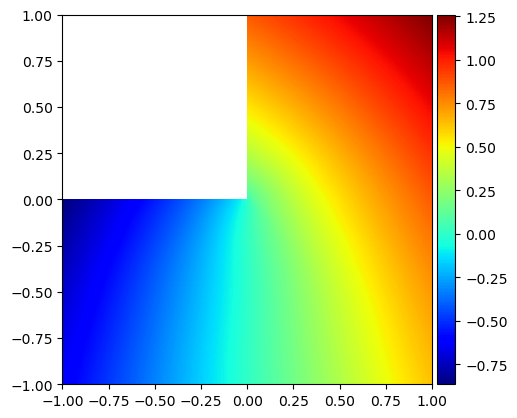

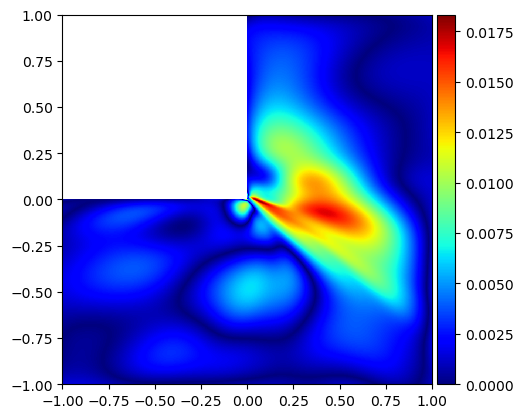

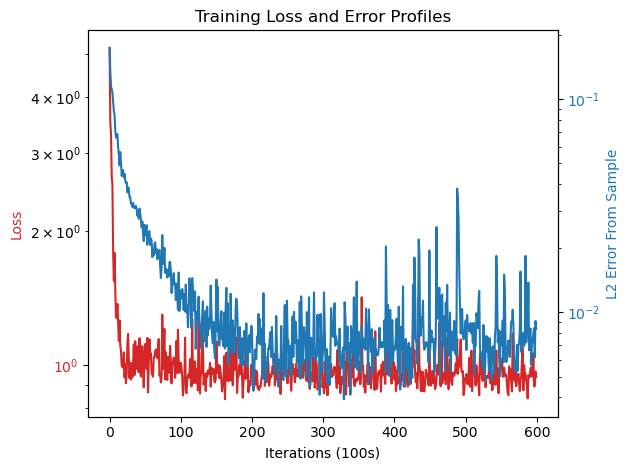

In [28]:
main(domain='l_shape', arch='drrnn_Tanh', epochs=60000, lr=3e-3, pretrain=0)

### Feedforward NN, ReLU Activation

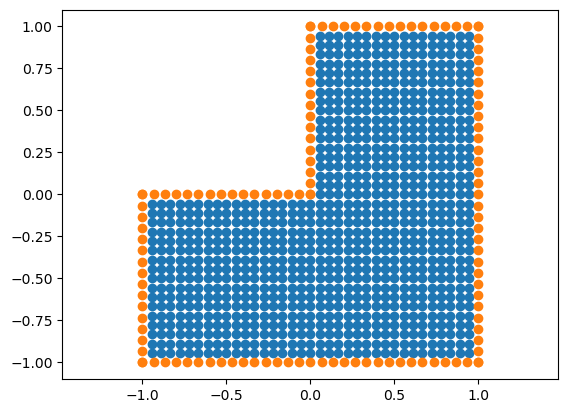

drfnn_ReLU


IntProgress(value=0)

epoch: 0 loss: 1998.0675048828125 loss_r: 0.00834042951464653 loss_b: 1998.0592041015625
Interior L2 error: 0.9819175601005554
Boundary L2 error: 1.9539920091629028


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 26.8911075592041 loss_r: 1.15109121799469 loss_b: 25.74001693725586
Interior L2 error: 0.18681153655052185
Boundary L2 error: 0.21821655333042145
epoch: 200 loss: 2.480538845062256 loss_r: 1.2049548625946045 loss_b: 1.2755839824676514
Interior L2 error: 0.16888272762298584
Boundary L2 error: 0.050320256501436234
epoch: 300 loss: 1.7851178646087646 loss_r: 1.1866165399551392 loss_b: 0.5985012650489807
Interior L2 error: 0.16651132702827454
Boundary L2 error: 0.034509941935539246
epoch: 400 loss: 1.5599634647369385 loss_r: 1.1518244743347168 loss_b: 0.4081389605998993
Interior L2 error: 0.1560285985469818
Boundary L2 error: 0.02852780371904373
epoch: 500 loss: 1.4415473937988281 loss_r: 1.1237523555755615 loss_b: 0.3177950084209442
Interior L2 error: 0.1479978710412979
Boundary L2 error: 0.025182446464896202
epoch: 600 loss: 1.3787728548049927 loss_r: 1.110119104385376 loss_b: 0.2686537504196167
Interior L2 error: 0.1364554613828659
Boundary L2 error: 0.02316976338624954

epoch: 5000 loss: 1.2309057712554932 loss_r: 1.0919514894485474 loss_b: 0.1389542669057846
Interior L2 error: 0.0998368039727211
Boundary L2 error: 0.01813659816980362
epoch: 5100 loss: 1.5322718620300293 loss_r: 1.1007559299468994 loss_b: 0.4315159022808075
Interior L2 error: 0.10769584774971008
Boundary L2 error: 0.033141981810331345
epoch: 5200 loss: 1.6356780529022217 loss_r: 1.1009784936904907 loss_b: 0.5346996188163757
Interior L2 error: 0.11144059151411057
Boundary L2 error: 0.023670721799135208
epoch: 5300 loss: 1.3853663206100464 loss_r: 1.1170358657836914 loss_b: 0.26833048462867737
Interior L2 error: 0.11000711470842361
Boundary L2 error: 0.023882806301116943
epoch: 5400 loss: 1.261458158493042 loss_r: 1.1114482879638672 loss_b: 0.15000984072685242
Interior L2 error: 0.10629229247570038
Boundary L2 error: 0.017449799925088882
epoch: 5500 loss: 1.734359622001648 loss_r: 1.1283679008483887 loss_b: 0.6059917211532593
Interior L2 error: 0.11251115798950195
Boundary L2 error: 0.0

epoch: 9900 loss: 1.2664170265197754 loss_r: 1.1116997003555298 loss_b: 0.15471738576889038
Interior L2 error: 0.10915304720401764
Boundary L2 error: 0.017662223428487778
epoch: 10000 loss: 1.2795926332473755 loss_r: 1.1027330160140991 loss_b: 0.17685964703559875
Interior L2 error: 0.1102077066898346
Boundary L2 error: 0.016797129064798355
best epoch: 9900 best loss: 1.2664170265197754 L2 error: 0.10915304720401764
load from ckpt!


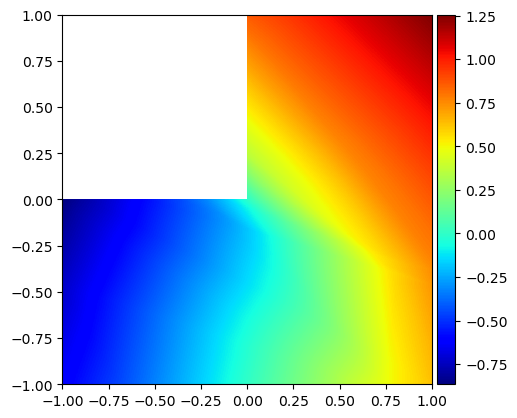

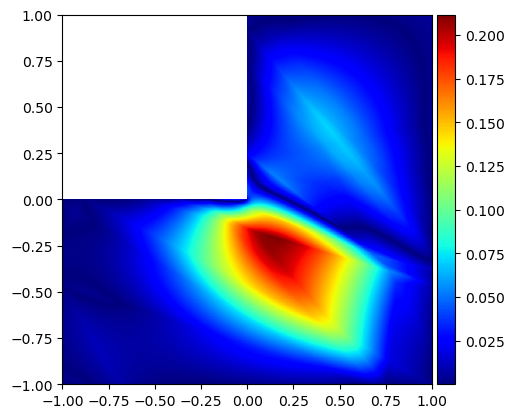

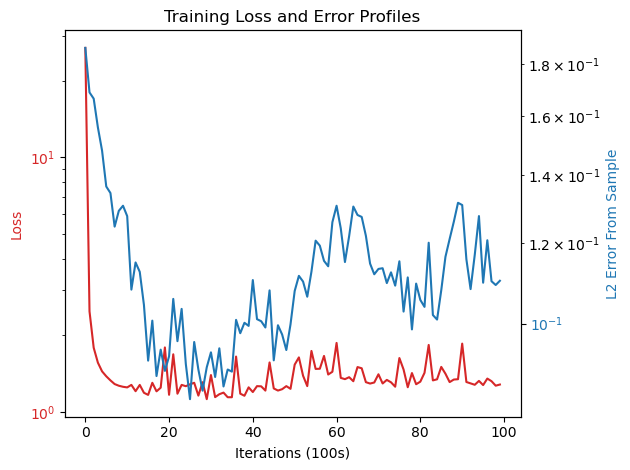

In [52]:
main(domain='l_shape_reg', density=19, arch='drfnn_ReLU', epochs=10000, lr=3e-3, pretrain=0)

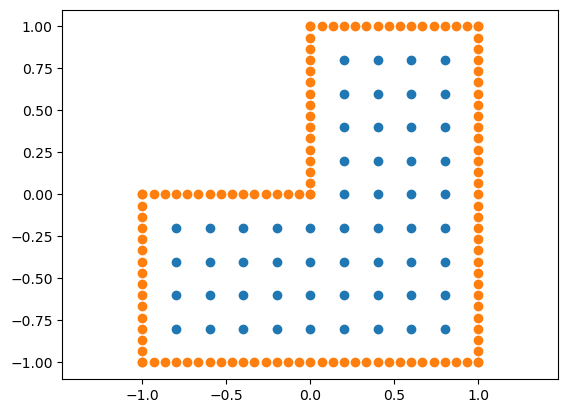

drfnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 2152.569091796875 loss_r: 1.0339103937440086e-06 loss_b: 2152.569091796875
Interior L2 error: 1.0589079856872559
Boundary L2 error: 2.0721864700317383


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 10.639979362487793 loss_r: 0.9264756441116333 loss_b: 9.71350383758545
Interior L2 error: 0.0718480721116066
Boundary L2 error: 0.13604487478733063
epoch: 200 loss: 1.5753453969955444 loss_r: 0.9051563143730164 loss_b: 0.6701890826225281
Interior L2 error: 0.06821417063474655
Boundary L2 error: 0.036489564925432205
epoch: 300 loss: 1.4315900802612305 loss_r: 1.0233548879623413 loss_b: 0.40823525190353394
Interior L2 error: 0.06766945868730545
Boundary L2 error: 0.02859043888747692
epoch: 400 loss: 1.331287145614624 loss_r: 1.025752067565918 loss_b: 0.30553513765335083
Interior L2 error: 0.07112129032611847
Boundary L2 error: 0.02500859461724758
epoch: 500 loss: 1.3892959356307983 loss_r: 1.0533661842346191 loss_b: 0.3359297513961792
Interior L2 error: 0.06758786737918854
Boundary L2 error: 0.02836420387029648
epoch: 600 loss: 1.160779356956482 loss_r: 1.000011682510376 loss_b: 0.16076764464378357
Interior L2 error: 0.07123862206935883
Boundary L2 error: 0.0179643798619

epoch: 5000 loss: 1.2519985437393188 loss_r: 1.123857021331787 loss_b: 0.12814156711101532
Interior L2 error: 0.09801678359508514
Boundary L2 error: 0.016533607617020607
best epoch: 4200 best loss: 1.072892189025879 L2 error: 0.08735652267932892
load from ckpt!


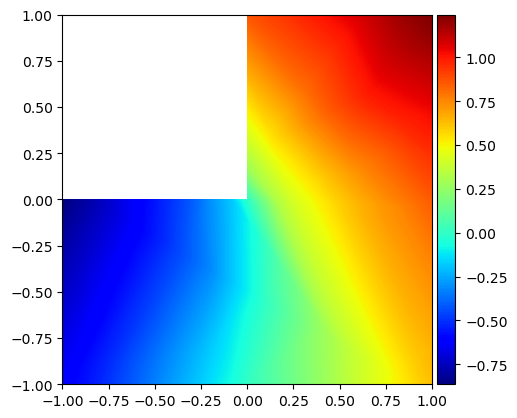

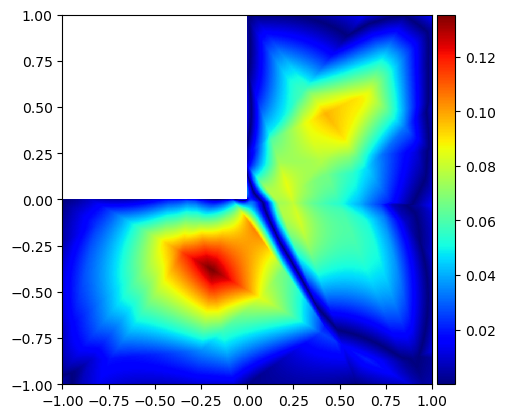

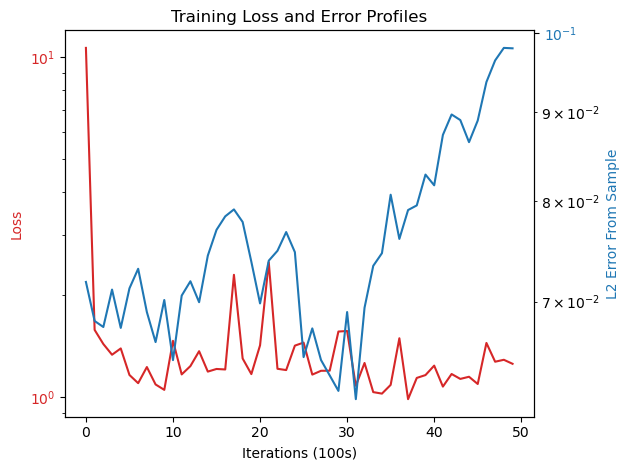

In [46]:
main(domain='l_shape_reg', density=6, arch='drfnn_ReLU', epochs=5000, lr=3e-3, pretrain=0)

### Feedforward NN, Tanh Activation

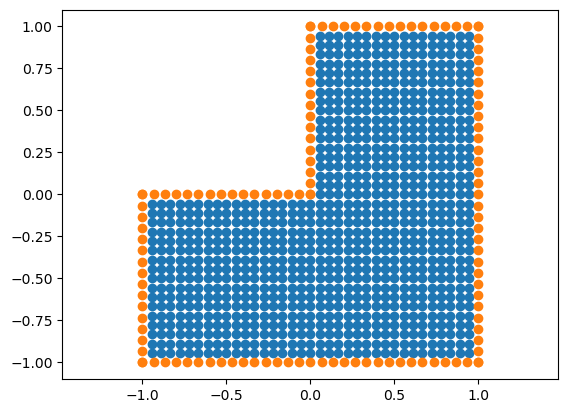

drfnn_Tanh


IntProgress(value=0)

epoch: 0 loss: 2411.96728515625 loss_r: 0.010282520204782486 loss_b: 2411.95703125
Interior L2 error: 0.874775230884552
Boundary L2 error: 1.8060532808303833


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 7.405391693115234 loss_r: 1.1263076066970825 loss_b: 6.279084205627441
Interior L2 error: 0.15975773334503174
Boundary L2 error: 0.11193374544382095
epoch: 200 loss: 6.170447826385498 loss_r: 1.109891414642334 loss_b: 5.060556411743164
Interior L2 error: 0.15036149322986603
Boundary L2 error: 0.10049992054700851
epoch: 300 loss: 5.288985252380371 loss_r: 1.0942471027374268 loss_b: 4.194738388061523
Interior L2 error: 0.137129008769989
Boundary L2 error: 0.09151802211999893
epoch: 400 loss: 4.680759906768799 loss_r: 1.0819032192230225 loss_b: 3.5988566875457764
Interior L2 error: 0.12285136431455612
Boundary L2 error: 0.08477708697319031
epoch: 500 loss: 4.161042213439941 loss_r: 1.0707101821899414 loss_b: 3.090331792831421
Interior L2 error: 0.1255868822336197
Boundary L2 error: 0.07855334877967834
epoch: 600 loss: 3.6394381523132324 loss_r: 1.058246374130249 loss_b: 2.5811917781829834
Interior L2 error: 0.11538788676261902
Boundary L2 error: 0.07177753746509552
epoch:

epoch: 5000 loss: 1.0243867635726929 loss_r: 0.9596713185310364 loss_b: 0.0647154226899147
Interior L2 error: 0.029463445767760277
Boundary L2 error: 0.011375746689736843
epoch: 5100 loss: 1.023728370666504 loss_r: 0.9578580856323242 loss_b: 0.0658702403306961
Interior L2 error: 0.026484990492463112
Boundary L2 error: 0.01129278913140297
epoch: 5200 loss: 1.021141767501831 loss_r: 0.9593555331230164 loss_b: 0.06178624555468559
Interior L2 error: 0.029889682307839394
Boundary L2 error: 0.011191979981958866
epoch: 5300 loss: 1.0183687210083008 loss_r: 0.9586101770401001 loss_b: 0.05975848808884621
Interior L2 error: 0.03145452216267586
Boundary L2 error: 0.010930749587714672
epoch: 5400 loss: 1.0305639505386353 loss_r: 0.9586553573608398 loss_b: 0.0719086304306984
Interior L2 error: 0.0313064344227314
Boundary L2 error: 0.011992324143648148
epoch: 5500 loss: 1.016187310218811 loss_r: 0.956780195236206 loss_b: 0.05940716341137886
Interior L2 error: 0.029220344498753548
Boundary L2 error: 

epoch: 9800 loss: 0.9540392160415649 loss_r: 0.9344006180763245 loss_b: 0.019638607278466225
Interior L2 error: 0.02026616595685482
Boundary L2 error: 0.006720593199133873
epoch: 9900 loss: 0.9920455813407898 loss_r: 0.9363289475440979 loss_b: 0.0557166188955307
Interior L2 error: 0.022487208247184753
Boundary L2 error: 0.0067149861715734005
epoch: 10000 loss: 0.9502155184745789 loss_r: 0.9329976439476013 loss_b: 0.01721787638962269
Interior L2 error: 0.01998772658407688
Boundary L2 error: 0.005860826000571251
best epoch: 10000 best loss: 0.9502155184745789 L2 error: 0.01998772658407688
load from ckpt!


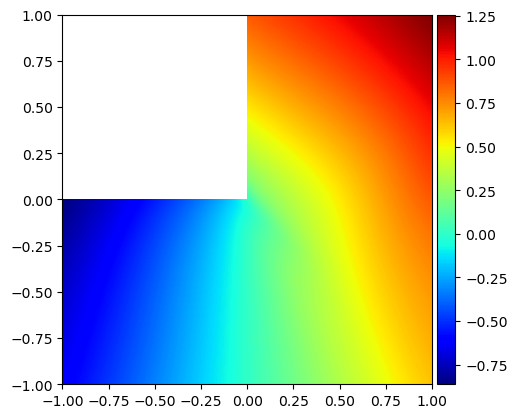

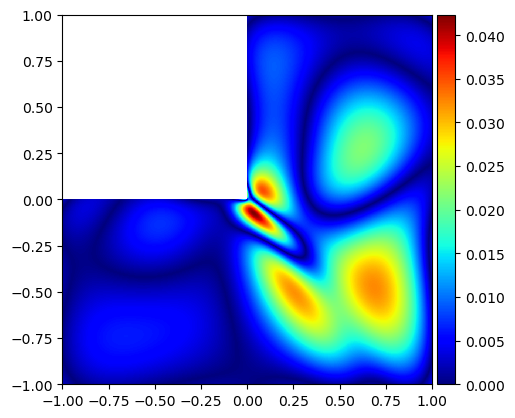

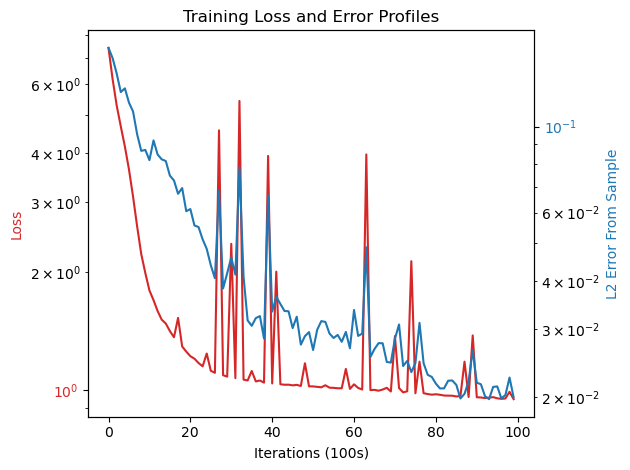

In [51]:
main(domain='l_shape_reg', density=19, arch='drfnn_Tanh', epochs=10000, lr=3e-3, pretrain=0)

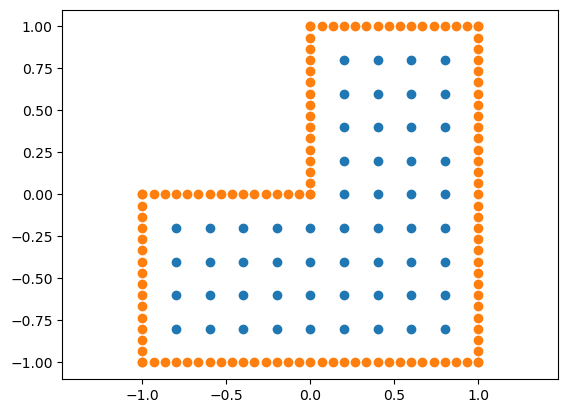

drfnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 1918.0947265625 loss_r: 0.019056592136621475 loss_b: 1918.07568359375
Interior L2 error: 0.857964038848877
Boundary L2 error: 1.7698345184326172


/tmp/ipykernel_29463/3243058833.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.tensor((xb[:,1:] != 0)*(xb[:,:1] != 0)))
/tmp/ipykernel_29463/3243058833.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,:1] == 0)))
/tmp/ipykernel_29463/3243058833.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.sin((-2*torch.atan2(xb[:,1:],xb[:,:1])+torch.pi)/3)*(torch.tensor((xb[:,1:] == 0)))


epoch: 100 loss: 7.2323102951049805 loss_r: 1.0867102146148682 loss_b: 6.145599842071533
Interior L2 error: 0.16691221296787262
Boundary L2 error: 0.11054310947656631
epoch: 200 loss: 5.492114067077637 loss_r: 1.0850284099578857 loss_b: 4.407085418701172
Interior L2 error: 0.14810454845428467
Boundary L2 error: 0.09377725422382355
epoch: 300 loss: 4.724118232727051 loss_r: 1.078909158706665 loss_b: 3.645209312438965
Interior L2 error: 0.12563879787921906
Boundary L2 error: 0.08530940115451813
epoch: 400 loss: 4.095837593078613 loss_r: 1.0704354047775269 loss_b: 3.025402069091797
Interior L2 error: 0.12273784726858139
Boundary L2 error: 0.07770764827728271
epoch: 500 loss: 3.484961986541748 loss_r: 1.0616552829742432 loss_b: 2.423306703567505
Interior L2 error: 0.1206170916557312
Boundary L2 error: 0.06953614205121994
epoch: 600 loss: 2.9835267066955566 loss_r: 1.055314540863037 loss_b: 1.92821204662323
Interior L2 error: 0.11726431548595428
Boundary L2 error: 0.062032803893089294
epoch

epoch: 5000 loss: 0.948479175567627 loss_r: 0.9207037687301636 loss_b: 0.027775410562753677
Interior L2 error: 0.021436478942632675
Boundary L2 error: 0.010198494419455528
best epoch: 4800 best loss: 0.9481731057167053 L2 error: 0.026849517598748207
load from ckpt!


In [47]:
main(domain='l_shape_reg', density=6, arch='drfnn_Tanh', epochs=5000, lr=3e-3, pretrain=0)

--------------------------------------------------------------------------------------------------------------------------------